# Documentation

## Notebook History

**Date | Version | Author | Comments**
- 2022-01-19 | 0.3 | Andre Buser | Completed the advanced/correlation anaylsis section. 
- 2022-01-15 | 0.1 | Andre Buser | Initial draft.

## Open tasks / Last Activitites

Open tasks and/or the latest activities in this section:
- [X] #TODO: **Complete** Data Science Ethics Checklist

## Purpose

The objective of this **stage three** notebook is to explore the correlation between the attributes/features.

## Data Science Ethics Checklist

[![Deon badge](https://img.shields.io/badge/ethics%20checklist-deon-brightgreen.svg?style=popout-square)](http://deon.drivendata.org/)

### C. Analysis
 - [**NA**] **C.1 Missing perspectives**: Have we sought to address blindspots in the analysis through engagement with relevant stakeholders (e.g., checking assumptions and discussing implications with affected communities and subject matter experts)?
 - [**NA**] **C.2 Dataset bias**: Have we examined the data for possible sources of bias and taken steps to mitigate or address these biases (e.g., stereotype perpetuation, confirmation bias, imbalanced classes, or omitted confounding variables)?
 - [**NA**] **C.3 Honest representation**: Are our visualizations, summary statistics, and reports designed to honestly represent the underlying data?
 - [**NA**] **C.4 Privacy in analysis**: Have we ensured that data with PII are not used or displayed unless necessary for the analysis?
 - [**NA**] **C.5 Auditability**: Is the process of generating the analysis well documented and reproducible if we discover issues in the future?

*Data Science Ethics Checklist generated with [deon](http://deon.drivendata.org).*


# Setup Environment

## Install Modules

In [588]:
# Document module versions
!pip install watermark

# To generate an advanced the correlation matrix / not used for the moment
# !pip install dython

## Import Modules

In [589]:
# Base libraries
import os
import sqlite3

# Scientific libraries
import numpy as np
import pandas as pd
import scipy.stats as stats


# Visual libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Helper libraries
import gc # garbage collection to optimize memory usage, use gc.collect()
import warnings
warnings.filterwarnings('ignore')

# Visual setup
import altair as alt
import matplotlib.ticker as ticker
#plt.style.use('fivethirtyeight')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
#custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
#sns.set_palette(custom_colors)
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False

# Pandas options
pd.set_option('display.float_format',  '{:,}'.format)
pd.set_option('max_colwidth', 40)
pd.options.display.max_columns = None  # Possible to limit
pd.options.display.max_rows = None  # Possible to limit
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Load magic commands
%load_ext watermark


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


## Define Parameters

In [590]:
# Using a hybrid path model to ensure that the notebook can be used locally or with Google Colab paths
try:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Paths: Google Colabs Setup
    PATH_EXT = "/content/drive/MyDrive/MADS/SIADS591-592/Project/data/external/"
    PATH_RAW = "/content/drive/MyDrive/MADS/SIADS591-592/Project/data/raw/"
    PATH_INT = "/content/drive/MyDrive/MADS/SIADS591-592/Project/data/interim/"
    PATH_PRO = "/content/drive/MyDrive/MADS/SIADS591-592/Project/data/processed/"
    PATH_REP = "/content/drive/MyDrive/MADS/SIADS591-592/Project/reports/"
    PATH_FIGS = "/content/drive/MyDrive/MADS/SIADS591-592/Project/reports/figures/"

except:
    # Paths: Local Setup
    PATH_EXT = "../data/external/"
    PATH_RAW = "../data/raw/"
    PATH_INT = "../data/interim/"
    PATH_PRO = "../data/processed/"
    PATH_REP = "../reports/"
    PATH_FIGS = "../reports/figures/"

# Load Data

In [591]:
# Loading all tables from the sqlite database file
FILENAME = "project_GDPR-fines.sqlite"
data_path = os.path.join(PATH_PRO, FILENAME)

con = sqlite3.connect(data_path)
df_gdpr = pd.read_sql("select * from GDPR", con)
df_gdp = pd.read_sql("select * from GDP", con)
df_cpi = pd.read_sql("select * from CPI", con)
df_pop = pd.read_sql("select * from POP", con)
con.close()

In [592]:
df_gdpr.shape
df_gdp.shape
df_cpi.shape
df_pop.shape

(978, 16)

(124, 7)

(124, 8)

(124, 7)

In [593]:
# Merging all tables into one dataframe
df = pd.DataFrame()
df_gdp = df_gdp[['mapping_key','gdp','gdp_cat','gdp_cat2']]
df = df_gdpr.merge(df_gdp, on="mapping_key", how='inner')

df_cpi = df_cpi[['iso3','mapping_key','cpi_score','cpi_score_cat','cpi_score_cat2']]
df = df.merge(df_cpi, on="mapping_key", how='inner')

df_pop = df_pop[['mapping_key','population','population_cat','population_cat2']]
df = df.merge(df_pop, on="mapping_key", how='inner')

In [594]:
df.head()
df.shape

etid country     fine                     controller_processor  \
0  ETid-986  GREECE 30,000.0              Info Communication Services   
1  ETid-985  GREECE 25,000.0                  Plus Real Advertisement   
2  ETid-957  GREECE 30,000.0                  One Way Private Company   
3  ETid-919  GREECE 20,000.0  Καπα Λαμδα Ωμεγα Διαφημιστικη Εμπορι...   
4  ETid-897  GREECE  5,000.0  Premiummedia Παραγωγη Οπτικο-Ακουστι...   

                                   article  \
0  Art. 13 GDPR, Art. 14 GDPR, Art. 11 ...   
1  Art. 13 GDPR, Art. 14 GDPR, Art. 11 ...   
2  Art. 28 (3) c) GDPR, Art. 32 (2), (4...   
3  Art. 6 GDPR, Art. 12 (2) GDPR, Art. ...   
4           Art. 21 (3) GDPR, Art. 25 GDPR   

                            violation_type                            sector  \
0  Insufficient fulfilment of informati...             Industry and Commerce   
1  Insufficient fulfilment of informati...             Industry and Commerce   
2  Insufficient technical and organisat...  Media, Telecoms and Broadcasting   
3  Insufficient legal basis for data pr...             Industry and Commerce   
4  Insufficient fulfilment of data subj...             Industry and Commerce   

                                   summary decision_date_imputed  \
0  The Hellenic DPA has imposed a fine ...                    No   
1  The Hellenic DPA has imposed a fine ...                    No   
2  The Hellenic DPA has imposed a fine ...                    No   
3  The Hellenic DPA has fined ΚΑΠΑ ΛΑΜΔ...                    No   
4  The Hellenic DPA has imposed a fine ...                    No   

   decision_year  fine_cat  fine_cat2  mapping_key  country_label  \
0           2021  30,000.0        6.0  GREECE-2021             11   
1           2021  25,000.0        6.0  GREECE-2021             11   
2           2021  30,000.0        6.0  GREECE-2021             11   
3           2021  20,000.0        5.0  GREECE-2021             11   
4           2021   5,000.0        3.0  GREECE-2021             11   

   violation_type_label  sector_label               gdp           gdp_cat  \
0                     4             5 212,266,363,527.0 210,000,000,000.0   
1                     4             5 212,266,363,527.0 210,000,000,000.0   
2                     7             6 212,266,363,527.0 210,000,000,000.0   
3                     6             5 212,266,363,527.0 210,000,000,000.0   
4                     3             5 212,266,363,527.0 210,000,000,000.0   

   gdp_cat2 iso3  cpi_score  cpi_score_cat  cpi_score_cat2  population  \
0       6.0  GRC       44.0           40.0             5.0    10376349   
1       6.0  GRC       44.0           40.0             5.0    10376349   
2       6.0  GRC       44.0           40.0             5.0    10376349   
3       6.0  GRC       44.0           40.0             5.0    10376349   
4       6.0  GRC       44.0           40.0             5.0    10376349   

   population_cat  population_cat2  
0        10400000              6.0  
1        10400000              6.0  
2        10400000              6.0  
3        10400000              6.0  
4        10400000              6.0

(978, 26)

In [595]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 978 entries, 0 to 977
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   etid                   978 non-null    object 
 1   country                978 non-null    object 
 2   fine                   952 non-null    float64
 3   controller_processor   978 non-null    object 
 4   article                978 non-null    object 
 5   violation_type         978 non-null    object 
 6   sector                 978 non-null    object 
 7   summary                978 non-null    object 
 8   decision_date_imputed  978 non-null    object 
 9   decision_year          978 non-null    int64  
 10  fine_cat               952 non-null    float64
 11  fine_cat2              952 non-null    float64
 12  mapping_key            978 non-null    object 
 13  country_label          978 non-null    int64  
 14  violation_type_label   978 non-null    int64  
 15  sector

In [596]:
df.describe().round(0)

fine  decision_year      fine_cat  fine_cat2  country_label  \
count         952.0          978.0         952.0      952.0          978.0   
mean    1,382,942.0        2,020.0   1,382,941.0        4.0           19.0   
std    25,363,689.0            1.0  25,363,689.0        3.0            9.0   
min             0.0        2,018.0           0.0        0.0            0.0   
25%         3,000.0        2,020.0       3,000.0        2.0           12.0   
50%        10,000.0        2,020.0      10,000.0        4.0           23.0   
75%        50,000.0        2,021.0      50,000.0        7.0           27.0   
max   746,000,000.0        2,021.0 746,000,000.0        9.0           30.0   

       violation_type_label  sector_label                 gdp  \
count                 978.0         978.0               975.0   
mean                    6.0           5.0 1,048,908,837,723.0   
std                     2.0           2.0   883,817,360,653.0   
min                     0.0           0.0    15,215,714,309.0   
25%                     5.0           3.0   249,696,854,574.0   
50%                     6.0           5.0 1,281,484,640,044.0   
75%                     7.0           7.0 1,320,033,318,744.0   
max                     9.0          10.0 3,975,347,237,443.0   

                  gdp_cat  gdp_cat2  cpi_score  cpi_score_cat  cpi_score_cat2  \
count               975.0     975.0      975.0          975.0           975.0   
mean  1,048,687,179,487.0       7.0       62.0           61.0             7.0   
std     883,926,116,514.0       1.0       13.0           13.0             1.0   
min      20,000,000,000.0       3.0       42.0           40.0             5.0   
25%     250,000,000,000.0       6.0       53.0           50.0             7.0   
50%   1,280,000,000,000.0       7.0       60.0           60.0             7.0   
75%   1,320,000,000,000.0       8.0       69.0           70.0             8.0   
max   3,980,000,000,000.0       8.0       89.0           90.0             9.0   

        population  population_cat  population_cat2  
count        978.0           978.0            978.0  
mean  33,671,637.0    33,680,879.0              7.0  
std   23,099,693.0    23,102,786.0              2.0  
min       38,128.0             0.0              0.0  
25%   10,099,265.0    10,100,000.0              6.0  
50%   46,736,776.0    46,700,000.0              8.0  
75%   46,771,375.0    46,800,000.0              8.0  
max   84,189,092.0    84,200,000.0              9.0

# Project Objectives

**Objective**: The purpose of the project is to analyze GDPR fines that have been issued since 2018 and to get: 
Basic insights regarding:
- Which industry sectors have been penalized the most?
- **CHANGE** Highest fined company and sector?
- Which EU countries have the most violations?
- **CHANGE** Which GDPR articles have been quoted the most?
- What are the “average costs” of a violation per sector?


Advanced insights by correlating the GDPR fine dataset with the population by country (POP), gross domestic product (GDP), and corruption perception index (CPI) by country, the project intents to verify the following assumptions:
- A higher GDP could lead to: 
  - More violated cases, because a higher GDP could mean more companies in the country
  - Higher fines, because the maximum fine is linked to the total worldwide annual turnover
- A higher CPI could lead to 
  - Fewer violation cases, because the public sector is maybe influenced by the companies
- A higher population could lead to
  - More reported cases because more data subjects could execute their rights

# Correlation Analysis

## Check correlation for the non-aggregated dataset

In [597]:
# Group features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Only se numerical features
df_num = df[numerical_features]

In [598]:
# Correlation check
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_num.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

In [599]:
df_num.shape
df_num.dropna(inplace=True)
df_num.shape

(978, 16)

(949, 16)

In [600]:
# Calcualtion p-value for the higher correlation coefficients
# The p-value is about the strength of a hypothesis.
# The p-value is a proportion: if your p-value is 0.05, that means that 
# 5% of the time you would see a test statistic at least as extreme as 
# the one you found if the null hypothesis was true.

# You want your p-value to be as low as possible for your value to be significant. 
# If your p-value is above your significant level (usually 1% or 5%) then your correlation is not significant. 

stats.spearmanr(df_num['fine'], df_num['violation_type_label'])
stats.spearmanr(df_num['fine'], df_num['gdp'])
stats.spearmanr(df_num['fine'], df_num['cpi_score'])
stats.spearmanr(df_num['fine'], df_num['cpi_score'])
stats.spearmanr(df_num['fine_cat2'], df_num['cpi_score'])
stats.spearmanr(df_num['fine_cat2'], df_num['cpi_score_cat'])



SpearmanrResult(correlation=0.15327616332770205, pvalue=2.099165553461269e-06)

SpearmanrResult(correlation=0.1450992381600876, pvalue=7.196810139544994e-06)

SpearmanrResult(correlation=0.2842620020209822, pvalue=4.250327117220378e-19)

SpearmanrResult(correlation=0.2842620020209822, pvalue=4.250327117220378e-19)

SpearmanrResult(correlation=0.2937760274633299, pvalue=2.4013390407228124e-20)

SpearmanrResult(correlation=0.274546409139027, pvalue=7.147520685931605e-18)

In [601]:
# Formated output / test
r = stats.spearmanr(df_num['fine_cat2'], df_num['cpi_score_cat'])
print("CorrCoef:",r[0].round(2))
print(f"p-value: {r[1].round(5)}")

CorrCoef: 0.27
p-value: 0.0


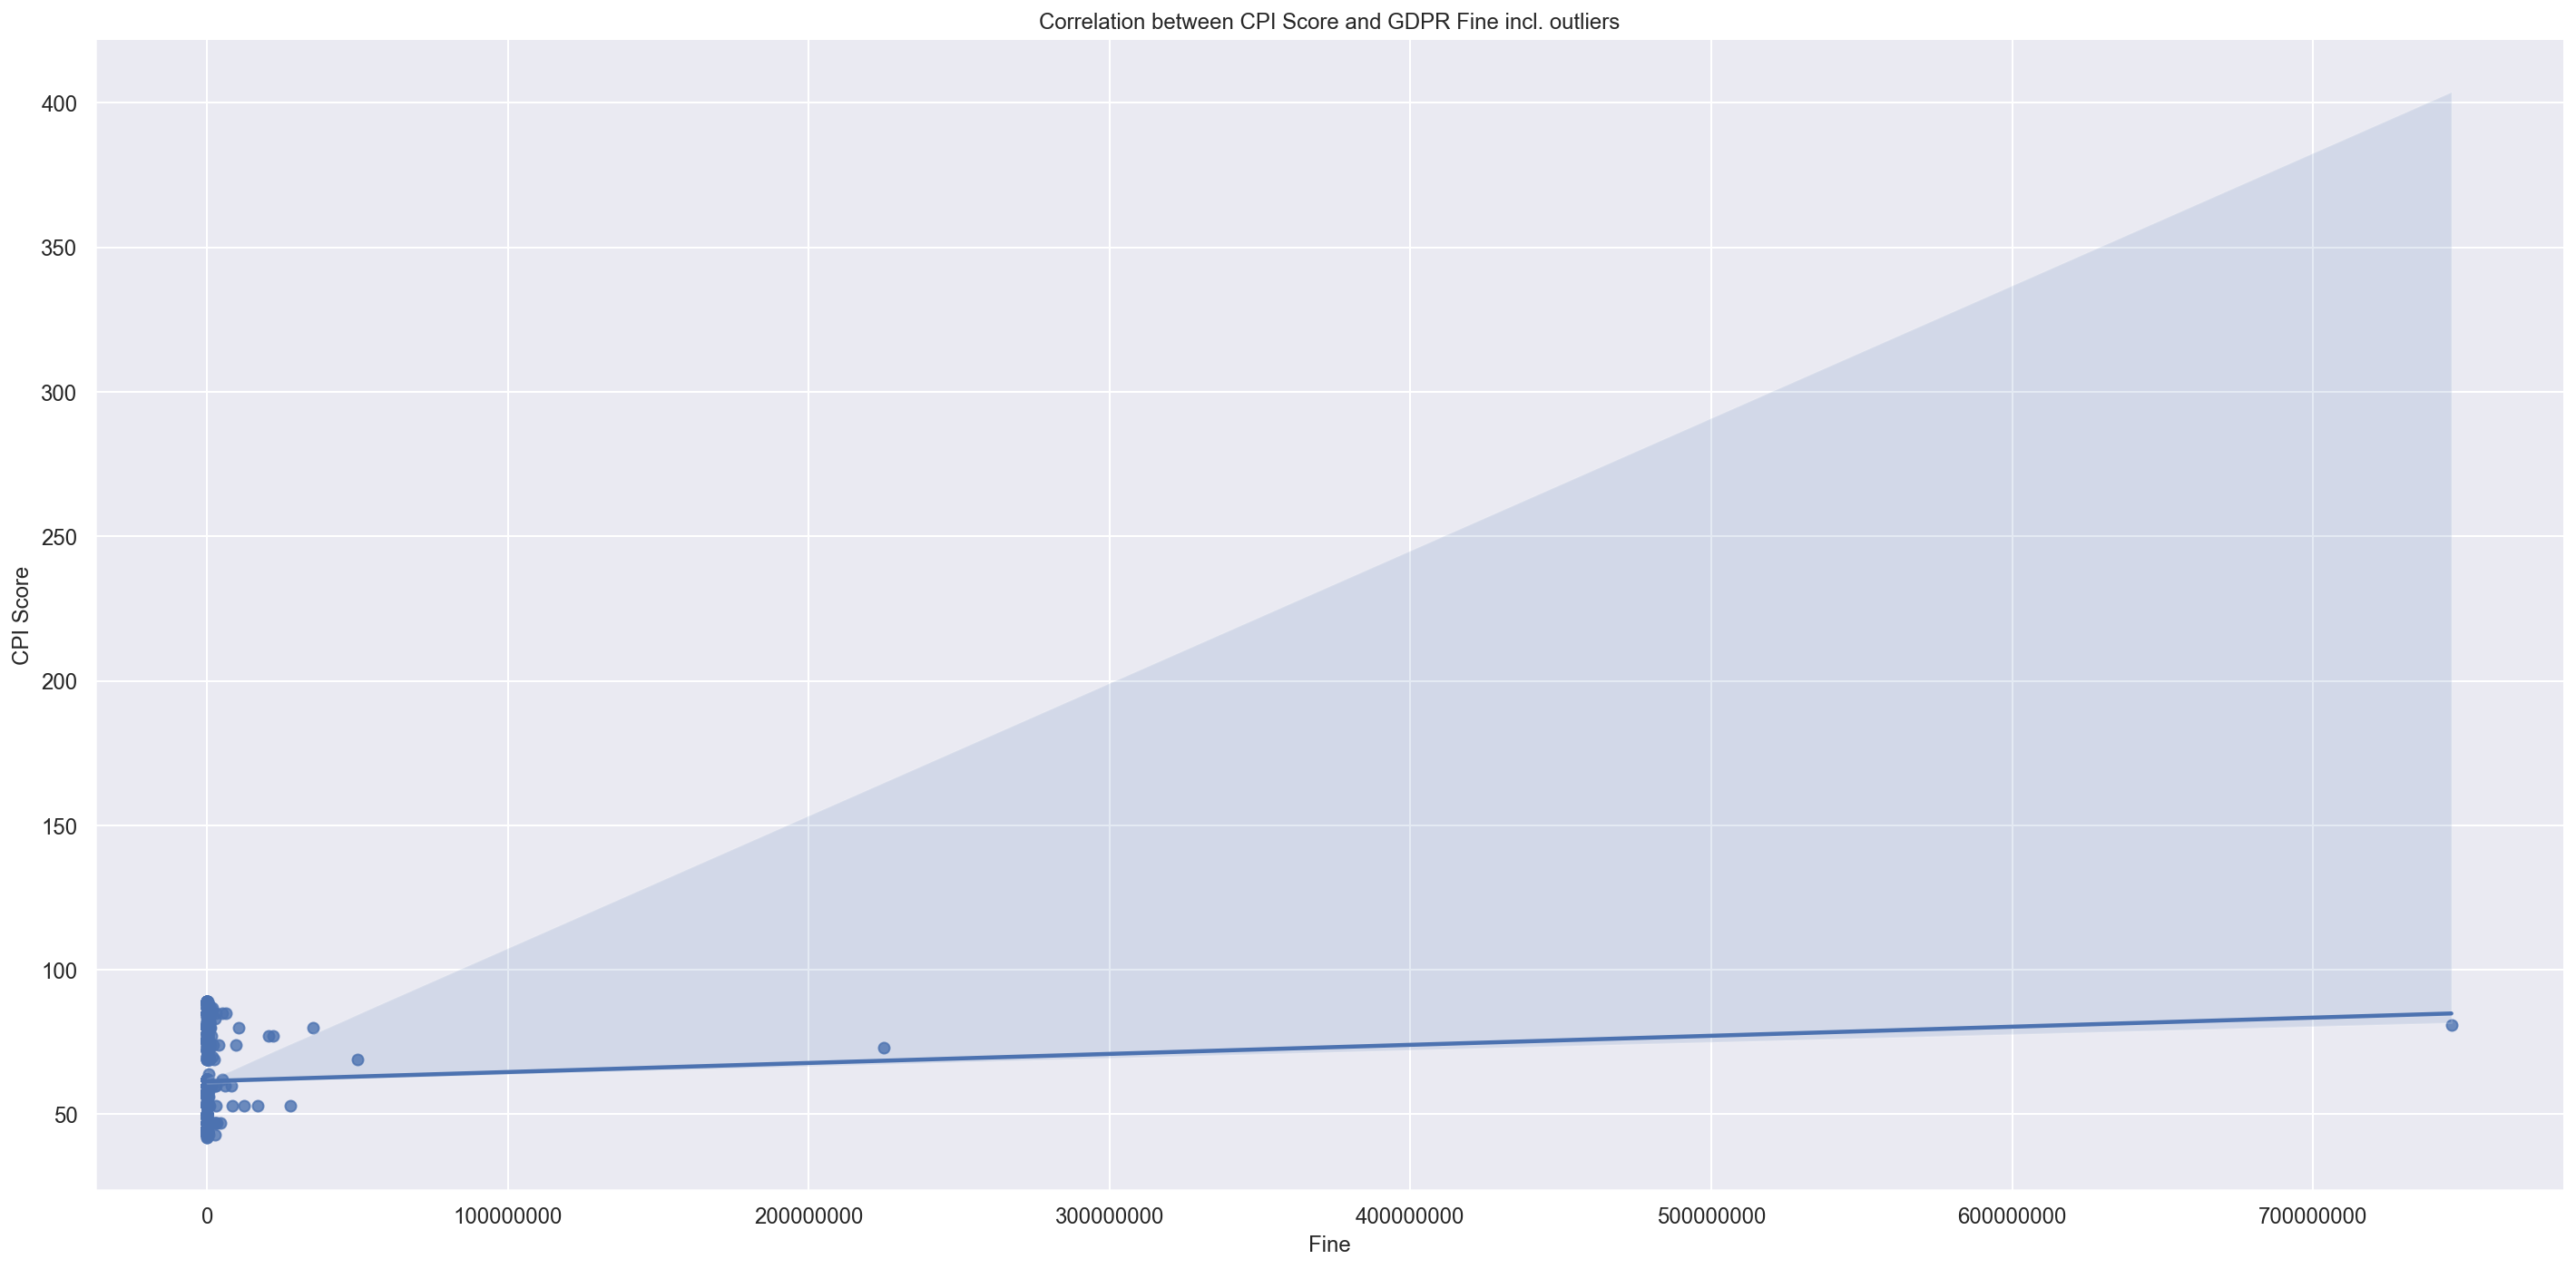

In [602]:
# Visualize strongest correlation
# Checking correlation with "outliers" and trendline
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_num, x="fine", y="cpi_score");
chart.set(title='Correlation between CPI Score and GDPR Fine incl. outliers', xlabel='Fine', ylabel="CPI Score");

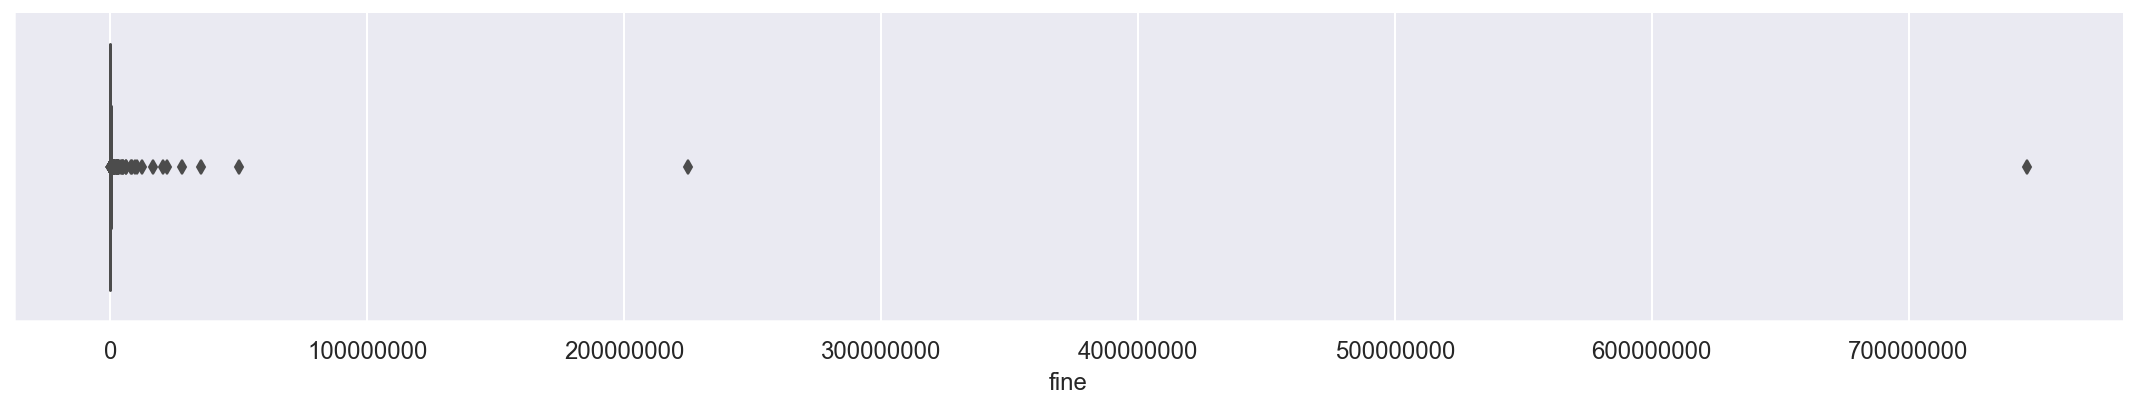

In [603]:
# Identify outliers in fine
plt.figure(figsize=(15, 3))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_num, x="fine");

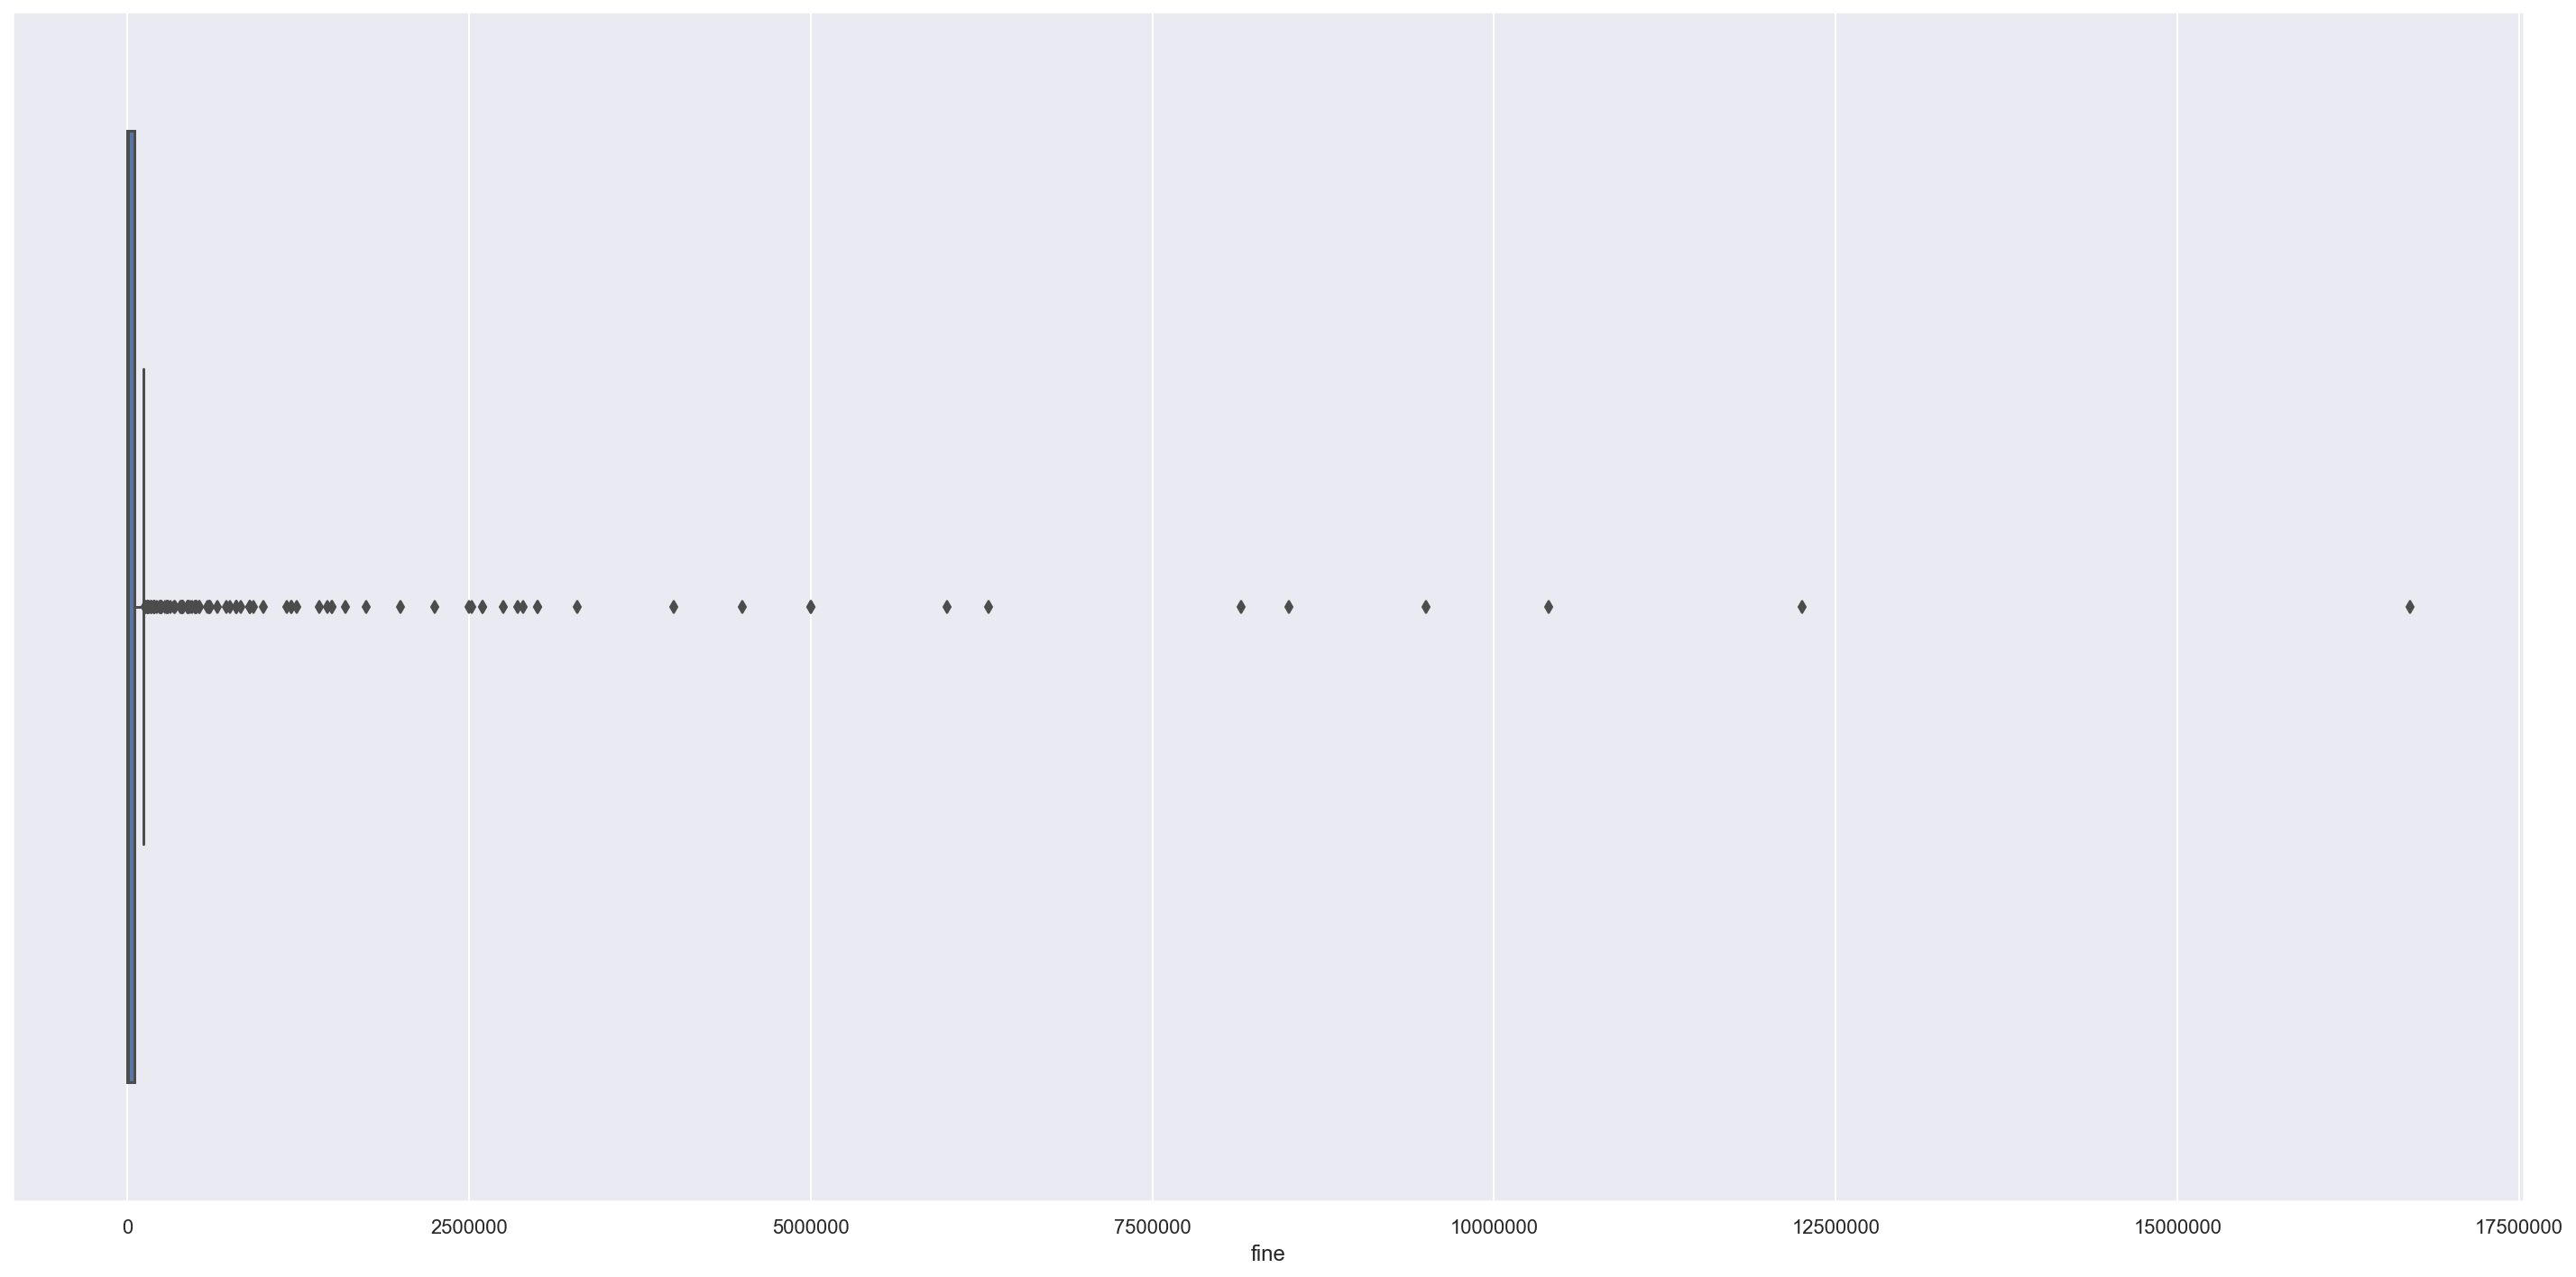

In [604]:
# Remove the two extreme outliers
df_num_filtered = df_num[df_num['fine'] < 20000000]

# Identify outliers in fine
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_num_filtered, x="fine");

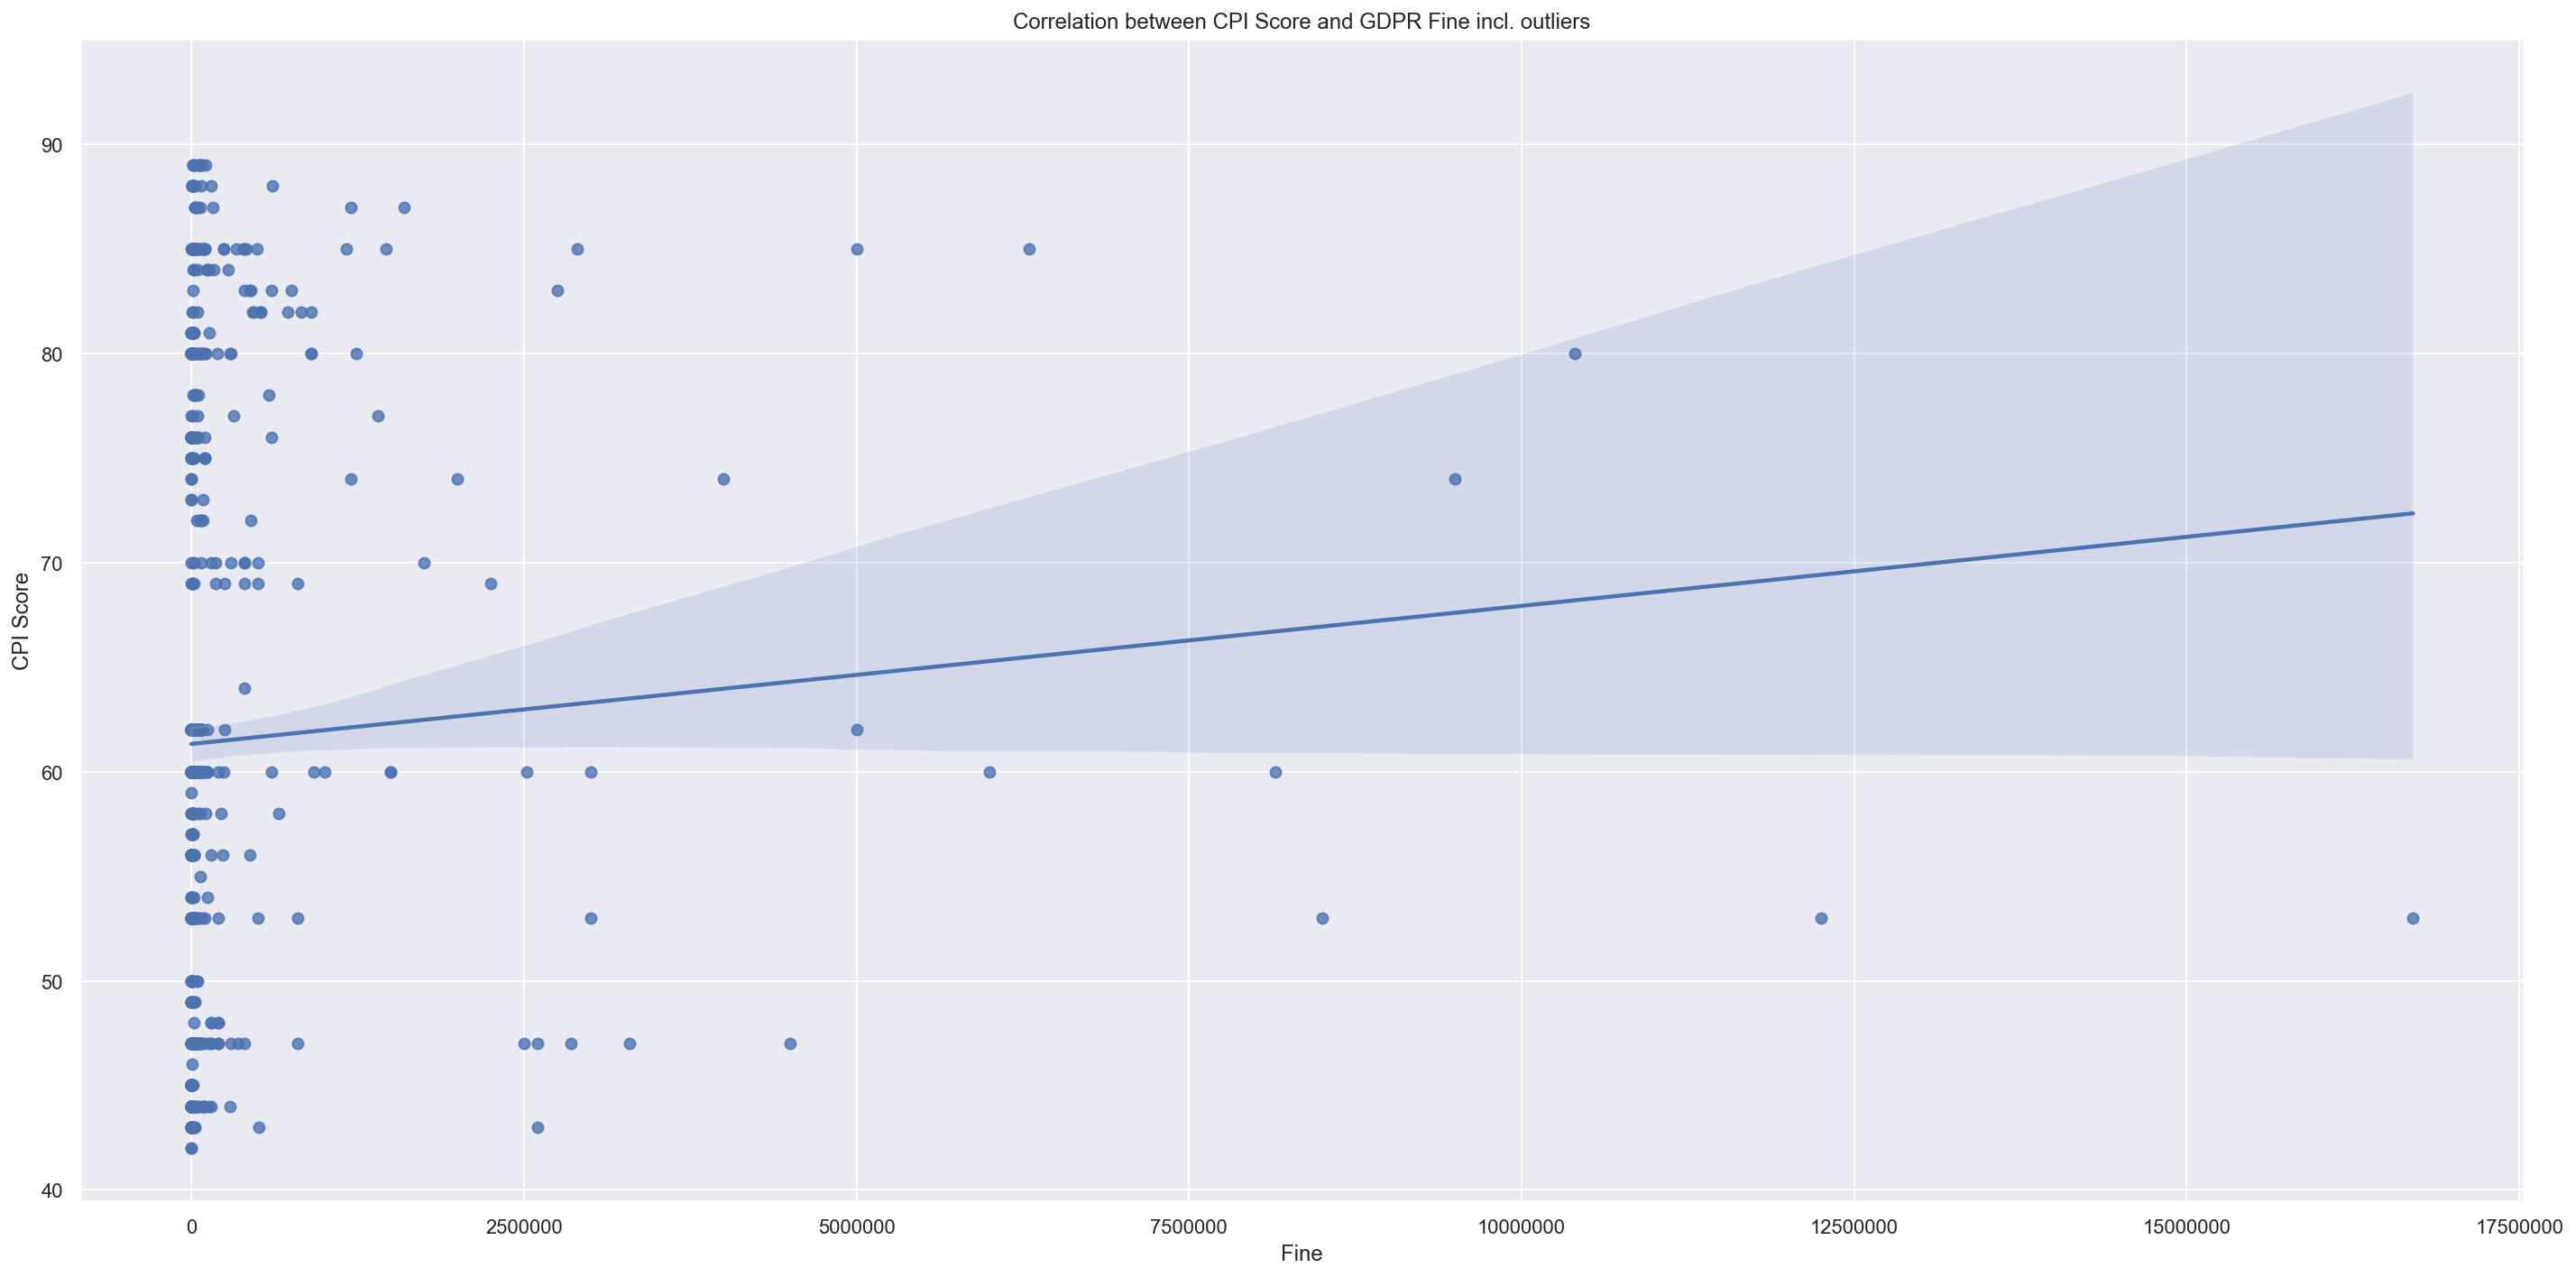

In [605]:
# Visualize strongest correlation
# Checking correlation with "outliers" and trendline
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_num_filtered, x="fine", y="cpi_score");
chart.set(title='Correlation between CPI Score and GDPR Fine incl. outliers', xlabel='Fine', ylabel="CPI Score");

In [606]:
# Re-check Correlation check
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_num_filtered.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

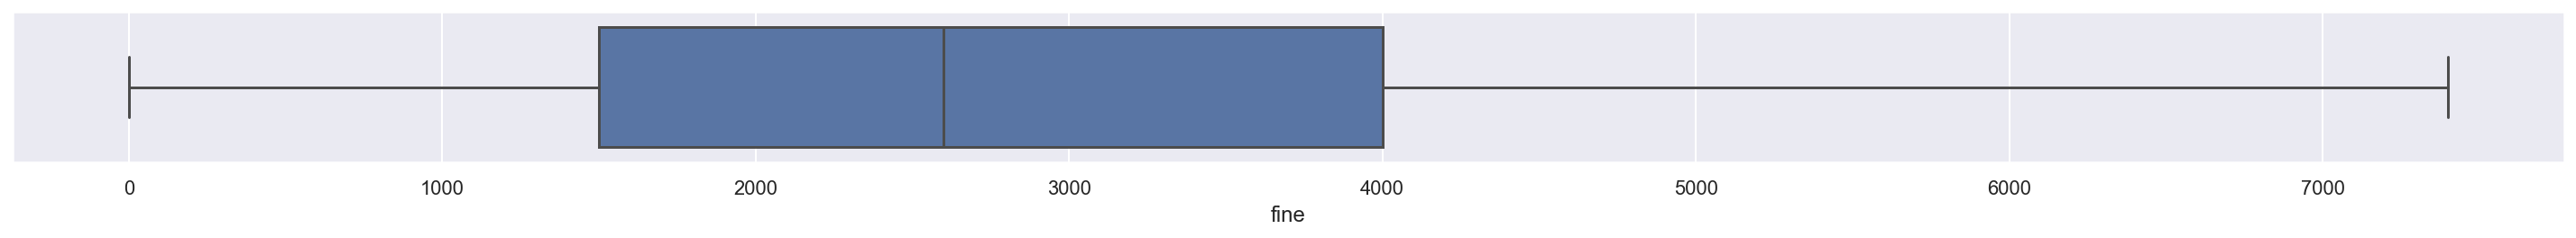

In [607]:
# filter/remove outliers
df_num_filtered = df_num[df_num['fine'] < 7500]

# Identify outliers in fine
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_num_filtered, x="fine");

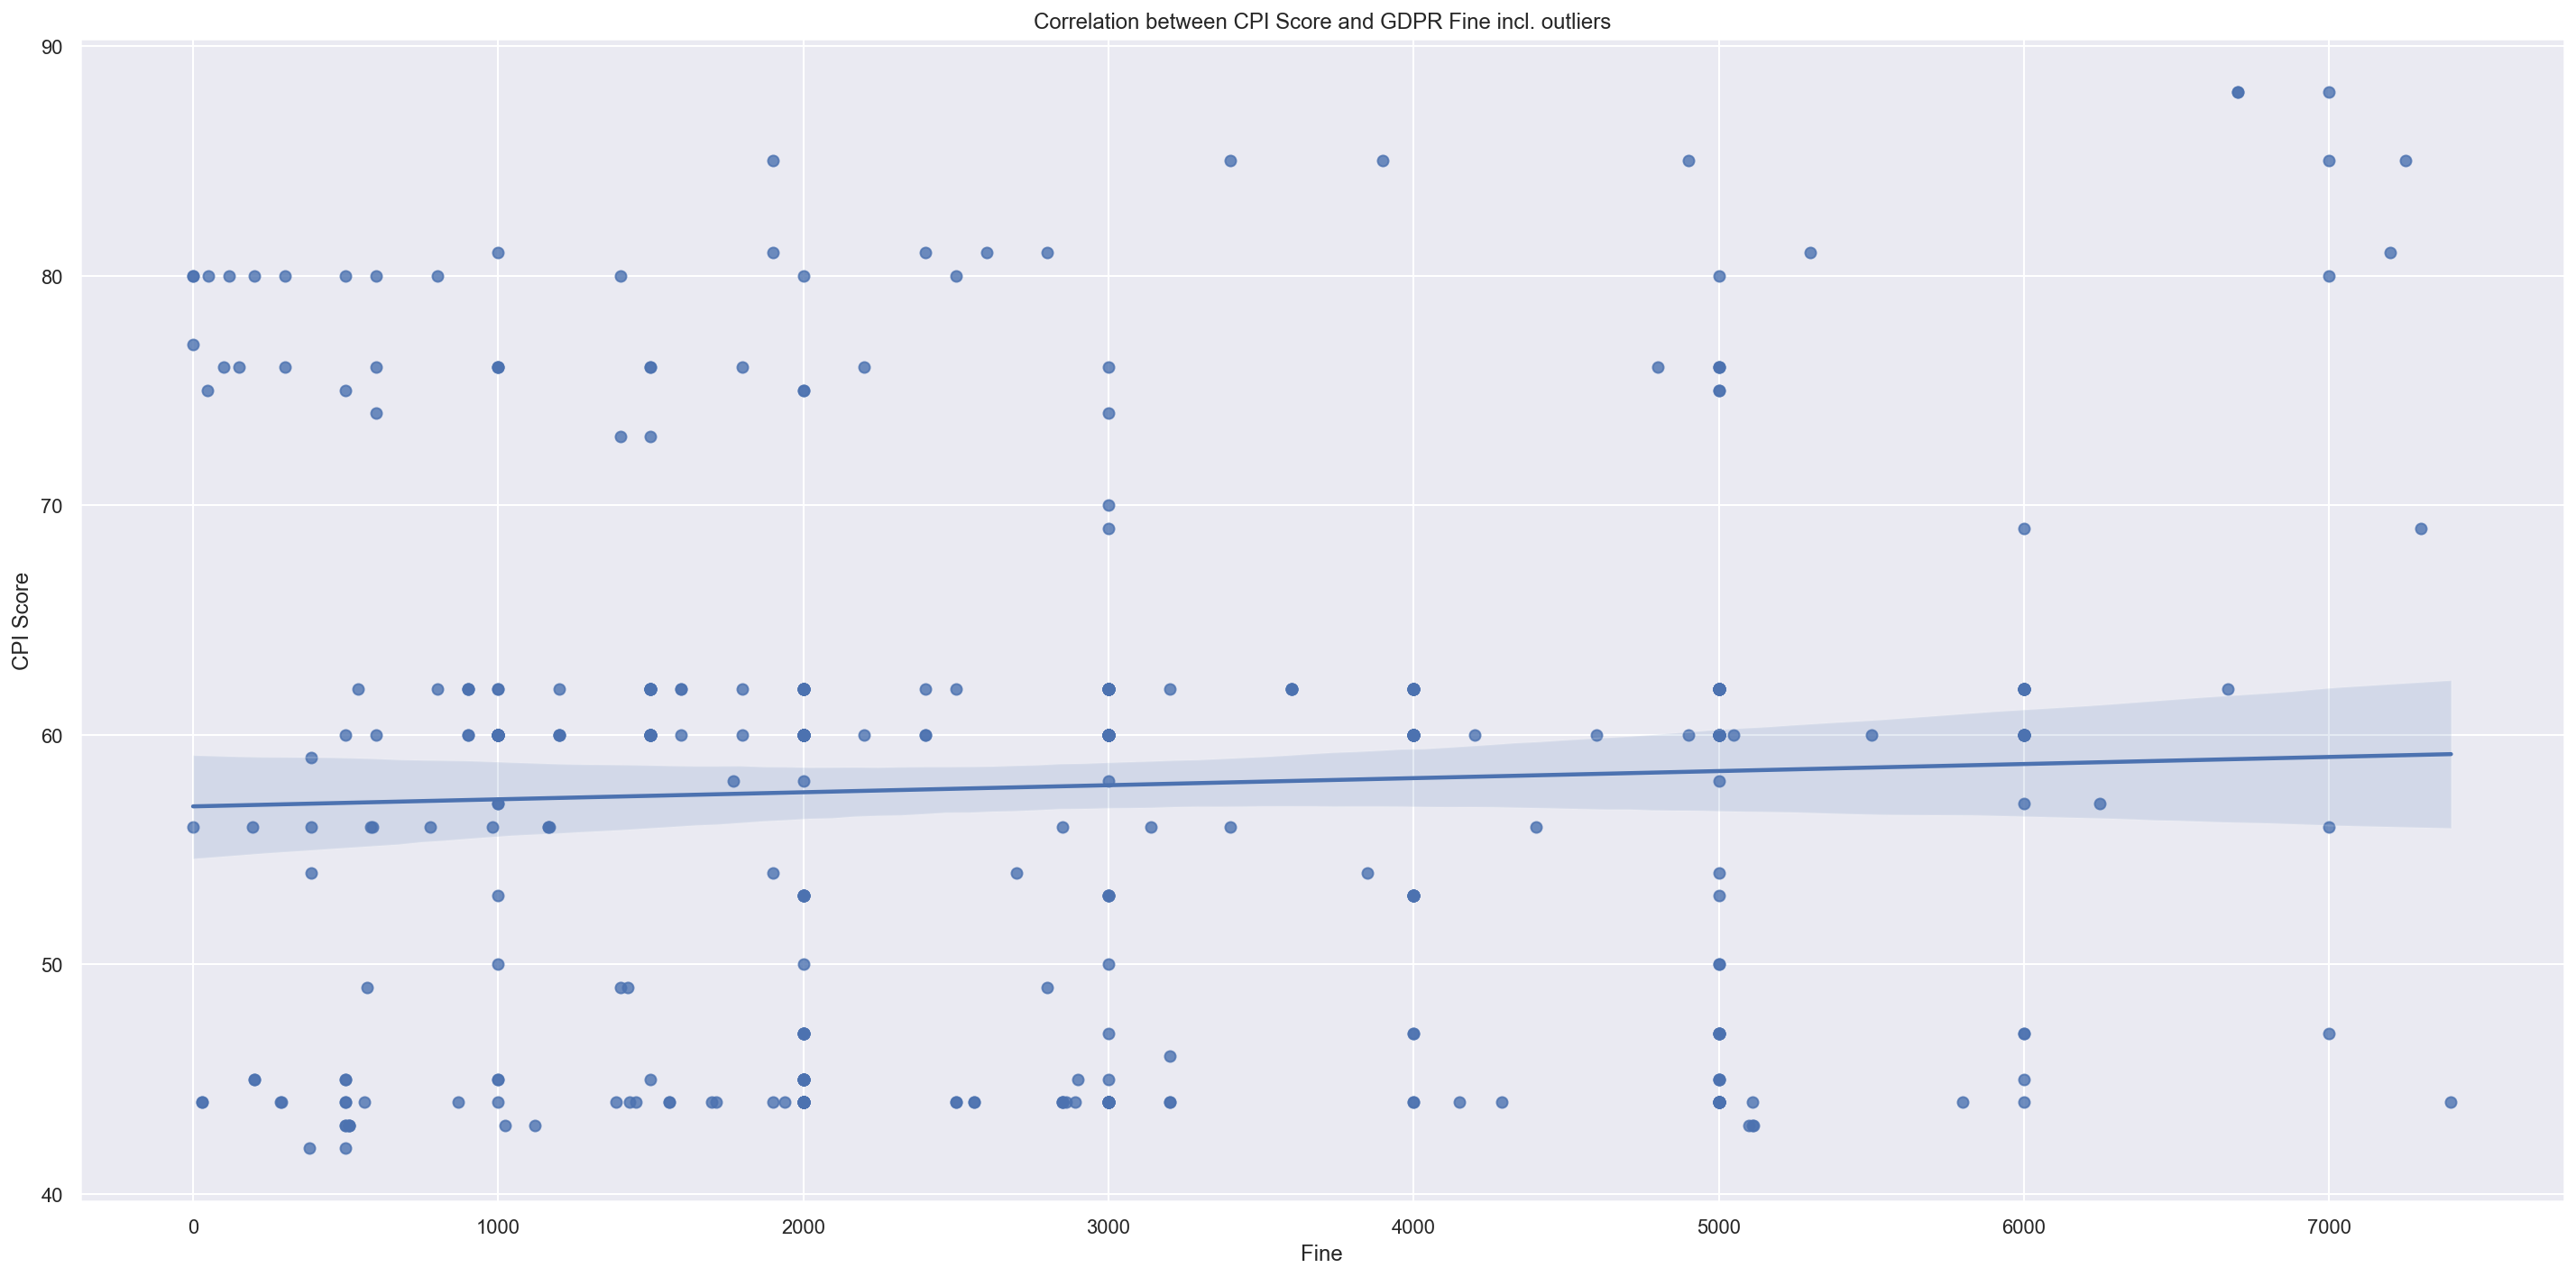

In [608]:
# Visualize strongest correlation
# Checking correlation with "outliers" and trendline
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_num_filtered, x="fine", y="cpi_score");
chart.set(title='Correlation between CPI Score and GDPR Fine incl. outliers', xlabel='Fine', ylabel="CPI Score");

In [609]:
# Re-check Correlation check
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_num_filtered.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

## Check correlation for the aggregated dataset

In [610]:
#{'fine':['sum','count','mean'],'gdp':'mean','cpi_score':'mean','population':'mean'}

In [703]:
df_ada_grouped = (
    df.groupby(["decision_year","country"])[
        "fine",
        "fine_cat",
        "fine_cat2",
        "gdp",
        "gdp_cat",
        "gdp_cat2",
        "cpi_score",
        "cpi_score_cat",
        "cpi_score_cat2",
        "population",
        "population_cat",
        "population_cat2",
        "violation_type_label",
    ]
    .agg(["count","mean", "median"])
    .reset_index()
)
# df_ada_grouped

# flatten grouped dataframe
df_ada_grouped_flatten = df_ada_grouped.copy()
df_ada_grouped_flatten.columns = [
    "_".join(i).rstrip("_") for i in df_ada_grouped_flatten.columns.values
]
# df_ada_grouped_flatten.round(2)



In [704]:
# Check Correlation check
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_ada_grouped_flatten.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

## Answer Basic Questions

### Prepare Dataframe

In [705]:
df_eda = df.copy()

In [706]:
#df_eda.head()
#df_eda.info()
df_eda.shape

(978, 26)

### Which industry sectors have been penalized the most?

In [707]:
# Most penalized by count of GDPR cases:
print("Top 5 penalized sectors by count of GDPR cases")
#df_eda['sector'].value_counts().head(5).to_frame("count")
df_eda.groupby(['sector'])['etid'].count().sort_values(ascending=False).head(5).to_frame("count").reset_index()

Top 5 penalized sectors by count of GDPR cases


sector  count
0              Industry and Commerce    212
1   Media, Telecoms and Broadcasting    164
2        Public Sector and Education    131
3  Finance, Insurance and Consulting     98
4                        Health Care     80

In [708]:
# Most penalized by sum of GDPR fines:
print("Top 5 penalized sectors by sum of GDPR fines")
#df_eda['sector'].value_counts().head(5).to_frame("count")
df_eda.groupby(['sector'])['fine'].sum().sort_values(ascending=False).head(5).to_frame("count").reset_index()

Top 5 penalized sectors by sum of GDPR fines


sector         count
0              Industry and Commerce 767,539,792.0
1   Media, Telecoms and Broadcasting 370,180,441.0
2          Transportation and Energy  53,341,369.0
3                         Employment  47,711,677.0
4  Finance, Insurance and Consulting  28,536,065.0

In [709]:
# Overview of sector
df_eda.groupby(['sector'])['fine'].agg(['sum','mean','size']).round(0).reset_index()#.sort_values(ascending=False).head(5).to_frame("sum")

sector           sum        mean  size
0            Accomodation and Hospitalty  21,461,207.0   766,472.0    28
1                             Employment  47,711,677.0   701,642.0    69
2      Finance, Insurance and Consulting  28,536,065.0   303,575.0    98
3                            Health Care  12,510,933.0   158,366.0    80
4   Individuals and Private Associations   1,367,646.0    19,821.0    71
5                  Industry and Commerce 767,539,792.0 3,762,450.0   212
6       Media, Telecoms and Broadcasting 370,180,441.0 2,285,064.0   164
7            Public Sector and Education  12,650,713.0    99,612.0   131
8                            Real Estate     515,970.0    19,845.0    27
9              Transportation and Energy  53,341,369.0 1,212,304.0    44
10                               Unknown     744,608.0    14,600.0    54

### Highest fined company and sector?

In [710]:
# Most penalized by sum of GDPR fines:
print("Top 5 highest fined companies")
df_eda.groupby(['controller_processor'])['fine'].max().sort_values(ascending=False).head(5).to_frame("max").reset_index()

Top 5 highest fined companies


controller_processor           max
0              Amazon Europe Core S.À.R.L. 746,000,000.0
1                    Whatsapp Ireland Ltd. 225,000,000.0
2                               Google Llc  50,000,000.0
3  H&M Hennes & Mauritz Online Shop A.B...  35,258,708.0
4        Tim (Telecommunications Operator)  27,800,000.0

In [711]:
# Most penalized by sum of GDPR fines:
print("Top 5 highest fined sectors")
df_eda.groupby(['sector'])['fine'].max().sort_values(ascending=False).head(5).to_frame("max").reset_index()

Top 5 highest fined sectors


sector           max
0             Industry and Commerce 746,000,000.0
1  Media, Telecoms and Broadcasting 225,000,000.0
2                        Employment  35,258,708.0
3         Transportation and Energy  22,046,000.0
4       Accomodation and Hospitalty  20,450,000.0

### Which EU countries have the most violations?

In [712]:
# Most penalized by GDPR cases opened:
print("Top 5 penalized countries by count of GDPR cases")
#df_eda['sector'].value_counts().head(5).to_frame("count")
df_eda.groupby(['country','iso3'])['fine'].count().sort_values(ascending=False).head(5).to_frame("count").reset_index()

Top 5 penalized countries by count of GDPR cases


country iso3  count
0    SPAIN  ESP    352
1    ITALY  ITA    103
2  ROMANIA  ROU     69
3  HUNGARY  HUN     45
4   NORWAY  NOR     36

In [713]:
# Most penalized countries by sum of GDPR fines:
print("Top 5 penalized countries by sum of GDPR fines")
df_eda.groupby(['country','iso3'])['fine'].sum().sort_values(ascending=False).head(5).to_frame("sum").reset_index()

Top 5 penalized countries by sum of GDPR fines


country iso3           sum
0  LUXEMBOURG  LUX 746,257,900.0
1     IRELAND  IRL 225,877,900.0
2       ITALY  ITA  89,804,096.0
3      FRANCE  FRA  58,194,300.0
4     GERMANY  DEU  50,159,583.0

In [714]:
df_eda[df_eda['country'] == "LUXEMBOURG"].groupby('decision_year')['fine'].count()

decision_year
2021    16
Name: fine, dtype: int64

In [715]:
df_eda[df_eda['country'] == "FRANCE"].groupby('decision_year')['fine'].count()

decision_year
2019     5
2020     6
2021    10
Name: fine, dtype: int64

### Which violation types have been raised the most?

In [716]:
df_eda.groupby(['violation_type'])['violation_type'].count().sort_values(ascending=False).head(5).to_frame("count").reset_index()

violation_type  count
0  Insufficient legal basis for data pr...    337
1  Non-compliance with general data pro...    197
2  Insufficient technical and organisat...    193
3  Insufficient fulfilment of data subj...     90
4  Insufficient fulfilment of informati...     82

In [717]:
#df.groupby(['violation_type','gdpr_article_short'])['violation_type'].count().sort_values(ascending=False).head(5).to_frame("count")

### What are the “average costs” of a violation per sector?

In [718]:
df_eda.groupby(['sector'])['fine'].mean().sort_values(ascending=False).head(5).to_frame("avg.").reset_index().round(0)

sector        avg.
0             Industry and Commerce 3,762,450.0
1  Media, Telecoms and Broadcasting 2,285,064.0
2         Transportation and Energy 1,212,304.0
3       Accomodation and Hospitalty   766,472.0
4                        Employment   701,642.0

### Which GDPR articles have been quoted the most?

In [719]:
df.head()

etid country     fine                     controller_processor  \
0  ETid-986  GREECE 30,000.0              Info Communication Services   
1  ETid-985  GREECE 25,000.0                  Plus Real Advertisement   
2  ETid-957  GREECE 30,000.0                  One Way Private Company   
3  ETid-919  GREECE 20,000.0  Καπα Λαμδα Ωμεγα Διαφημιστικη Εμπορι...   
4  ETid-897  GREECE  5,000.0  Premiummedia Παραγωγη Οπτικο-Ακουστι...   

                                   article  \
0  Art. 13 GDPR, Art. 14 GDPR, Art. 11 ...   
1  Art. 13 GDPR, Art. 14 GDPR, Art. 11 ...   
2  Art. 28 (3) c) GDPR, Art. 32 (2), (4...   
3  Art. 6 GDPR, Art. 12 (2) GDPR, Art. ...   
4           Art. 21 (3) GDPR, Art. 25 GDPR   

                            violation_type                            sector  \
0  Insufficient fulfilment of informati...             Industry and Commerce   
1  Insufficient fulfilment of informati...             Industry and Commerce   
2  Insufficient technical and organisat...  Media, Telecoms and Broadcasting   
3  Insufficient legal basis for data pr...             Industry and Commerce   
4  Insufficient fulfilment of data subj...             Industry and Commerce   

                                   summary decision_date_imputed  \
0  The Hellenic DPA has imposed a fine ...                    No   
1  The Hellenic DPA has imposed a fine ...                    No   
2  The Hellenic DPA has imposed a fine ...                    No   
3  The Hellenic DPA has fined ΚΑΠΑ ΛΑΜΔ...                    No   
4  The Hellenic DPA has imposed a fine ...                    No   

   decision_year  fine_cat  fine_cat2  mapping_key  country_label  \
0           2021  30,000.0        6.0  GREECE-2021             11   
1           2021  25,000.0        6.0  GREECE-2021             11   
2           2021  30,000.0        6.0  GREECE-2021             11   
3           2021  20,000.0        5.0  GREECE-2021             11   
4           2021   5,000.0        3.0  GREECE-2021             11   

   violation_type_label  sector_label               gdp           gdp_cat  \
0                     4             5 212,266,363,527.0 210,000,000,000.0   
1                     4             5 212,266,363,527.0 210,000,000,000.0   
2                     7             6 212,266,363,527.0 210,000,000,000.0   
3                     6             5 212,266,363,527.0 210,000,000,000.0   
4                     3             5 212,266,363,527.0 210,000,000,000.0   

   gdp_cat2 iso3  cpi_score  cpi_score_cat  cpi_score_cat2  population  \
0       6.0  GRC       44.0           40.0             5.0    10376349   
1       6.0  GRC       44.0           40.0             5.0    10376349   
2       6.0  GRC       44.0           40.0             5.0    10376349   
3       6.0  GRC       44.0           40.0             5.0    10376349   
4       6.0  GRC       44.0           40.0             5.0    10376349   

   population_cat  population_cat2  
0        10400000              6.0  
1        10400000              6.0  
2        10400000              6.0  
3        10400000              6.0  
4        10400000              6.0

In [720]:
df_split = df.copy()
# Replacing , Art to get a better split option (quick and dirty)
df_split['article'].replace(", Art.", ", Art. Art.", regex=True, inplace=True)

# Split articles
separator = ', Art.'
df_split['article'] = df_split['article'].str.split(separator)
df_split = df_split.explode('article')

# Extract GDPR article into separate column
pattern = r'(Art.\s\d+)'
df_split['gdpr_article_short'] = df_split['article'].str.extract(pattern)

# Replace dummy Art. 00 with Unknown
df_split['gdpr_article_short'].replace("Art. 00", "Art. Unknown",inplace=True)
df_split['gdpr_article_short'].unique()

# Create temp column to identify GDPR relevant articles
df_split['gdpr_article'] = df_split["article"].str.contains('GDPR')
df_split.shape

# Remove all non-GDPR articles
df_split = df_split[df_split['gdpr_article'] == True]

array(['Art. 13', 'Art. 14', 'Art. 11', 'Art. 28', 'Art. 32', 'Art. 6',
       'Art. 12', 'Art. 21', 'Art. 25', 'Art. 5', 'Art. 17', 'Art. 15',
       'Art. 24', 'Art. 33', 'Art. 34', 'Art. 31', 'Art. 58', 'Art. 29',
       'Art. 3', 'Art. 7', 'Art. 9', 'Art. 2', 'Art. 35', 'Art. 44',
       'Art. 46', 'Art. 30', 'Art. 22', 'Art. 37', 'Art. Unknown',
       'Art. 48', 'Art. 23', 'Art. 16', 'Art. 82', nan, 'Art. 8',
       'Art. 38', 'Art. 39', 'Art. 27', 'Art. 18', 'Art. 19', 'Art. 20',
       'Art. 36'], dtype=object)

(1981, 28)

In [721]:
df_split['gdpr_article_short'].value_counts().to_frame("count").head(5)

count
Art. 5     511
Art. 6     387
Art. 32    230
Art. 13    157
Art. 12     77

#### Label Encoding

In [722]:
# Add labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_split['gdpr_article_short_label']= le.fit_transform(df_split['gdpr_article_short'].values)

In [723]:
df_split.head().round(0)
df_split.shape

etid country     fine         controller_processor  \
0  ETid-986  GREECE 30,000.0  Info Communication Services   
0  ETid-986  GREECE 30,000.0  Info Communication Services   
1  ETid-985  GREECE 25,000.0      Plus Real Advertisement   
1  ETid-985  GREECE 25,000.0      Plus Real Advertisement   
2  ETid-957  GREECE 30,000.0      One Way Private Company   

               article                           violation_type  \
0         Art. 13 GDPR  Insufficient fulfilment of informati...   
0         Art. 14 GDPR  Insufficient fulfilment of informati...   
1         Art. 13 GDPR  Insufficient fulfilment of informati...   
1         Art. 14 GDPR  Insufficient fulfilment of informati...   
2  Art. 28 (3) c) GDPR  Insufficient technical and organisat...   

                             sector                                  summary  \
0             Industry and Commerce  The Hellenic DPA has imposed a fine ...   
0             Industry and Commerce  The Hellenic DPA has imposed a fine ...   
1             Industry and Commerce  The Hellenic DPA has imposed a fine ...   
1             Industry and Commerce  The Hellenic DPA has imposed a fine ...   
2  Media, Telecoms and Broadcasting  The Hellenic DPA has imposed a fine ...   

  decision_date_imputed  decision_year  fine_cat  fine_cat2  mapping_key  \
0                    No           2021  30,000.0        6.0  GREECE-2021   
0                    No           2021  30,000.0        6.0  GREECE-2021   
1                    No           2021  25,000.0        6.0  GREECE-2021   
1                    No           2021  25,000.0        6.0  GREECE-2021   
2                    No           2021  30,000.0        6.0  GREECE-2021   

   country_label  violation_type_label  sector_label               gdp  \
0             11                     4             5 212,266,363,527.0   
0             11                     4             5 212,266,363,527.0   
1             11                     4             5 212,266,363,527.0   
1             11                     4             5 212,266,363,527.0   
2             11                     7             6 212,266,363,527.0   

            gdp_cat  gdp_cat2 iso3  cpi_score  cpi_score_cat  cpi_score_cat2  \
0 210,000,000,000.0       6.0  GRC       44.0           40.0             5.0   
0 210,000,000,000.0       6.0  GRC       44.0           40.0             5.0   
1 210,000,000,000.0       6.0  GRC       44.0           40.0             5.0   
1 210,000,000,000.0       6.0  GRC       44.0           40.0             5.0   
2 210,000,000,000.0       6.0  GRC       44.0           40.0             5.0   

   population  population_cat  population_cat2 gdpr_article_short  \
0    10376349        10400000              6.0            Art. 13   
0    10376349        10400000              6.0            Art. 14   
1    10376349        10400000              6.0            Art. 13   
1    10376349        10400000              6.0            Art. 14   
2    10376349        10400000              6.0            Art. 28   

   gdpr_article  gdpr_article_short_label  
0          True                         1  
0          True                         2  
1          True                         1  
1          True                         2  
2          True                        14

(1938, 29)

#### Check Correlation 

In [724]:
df_split.corr()

fine         decision_year  \
fine                                        1.0  0.033086361599236114   
decision_year              0.033086361599236114                   1.0   
fine_cat                     0.9999999999998842  0.033086364221252926   
fine_cat2                   0.10546374091518838   0.10890422432225604   
country_label             -0.012974661564438291    0.1786640710595909   
violation_type_label       0.003927731553400108   0.09191189786398384   
sector_label               0.014185694765785958   0.01907015992344895   
gdp                       -0.005642119655656799  0.043416938413384065   
gdp_cat                  -0.0056230205690806214   0.04308787103245999   
gdp_cat2                  -0.019288382668794603   0.18563378578294773   
cpi_score                   0.05340189519741718  0.062112890281362035   
cpi_score_cat                0.0477103573541079   0.09774791466819645   
cpi_score_cat2               0.0463718027270369  0.016391009239359974   
population                -0.024482863769185778   0.08348598406603118   
population_cat            -0.024521229622005845   0.08339650904293534   
population_cat2            -0.07204376087345754  0.007765369086473528   
gdpr_article                                NaN                   NaN   
gdpr_article_short_label   -0.00754937489539799 -0.043120366091509606   

                                      fine_cat            fine_cat2  \
fine                        0.9999999999998842  0.10546374091518838   
decision_year             0.033086364221252926  0.10890422432225604   
fine_cat                                   1.0  0.10546374321613122   
fine_cat2                  0.10546374321613122                  1.0   
country_label            -0.012974667381932543 0.017303194694948672   
violation_type_label      0.003927760833875174  0.17105498134030064   
sector_label              0.014185698385586159 0.030034325749308467   
gdp                      -0.005642123488375956  0.21737441328077287   
gdp_cat                   -0.00562302433483801  0.21726950868738729   
gdp_cat2                 -0.019288380055167833  0.17895567692328637   
cpi_score                  0.05340187555938387   0.2532794200421128   
cpi_score_cat             0.047710337291623675   0.2610691709402147   
cpi_score_cat2             0.04637178674927476  0.24021383960077777   
population               -0.024482862411142677   0.1362027353430192   
population_cat            -0.02452122824270063  0.13609660042499597   
population_cat2           -0.07204374938814712  0.03042638928304581   
gdpr_article                               NaN                  NaN   
gdpr_article_short_label -0.007549365111903637  0.03736407023290691   

                                 country_label  violation_type_label  \
fine                     -0.012974661564438291  0.003927731553400108   
decision_year               0.1786640710595909   0.09191189786398384   
fine_cat                 -0.012974667381932543  0.003927760833875174   
fine_cat2                 0.017303194694948672   0.17105498134030064   
country_label                              1.0 0.0016242263531097885   
violation_type_label     0.0016242263531097885                   1.0   
sector_label             -0.028904584765533446   -0.0904003307508815   
gdp                        0.09506692025818145   0.06731565827853626   
gdp_cat                    0.09439699144427784   0.06708839298737054   
gdp_cat2                    0.3162308259709164   0.00816761229821205   
cpi_score                0.0028971714714271816  0.023492781339621634   
cpi_score_cat             -0.05877379533914792  0.022168155923455703   
cpi_score_cat2             0.03530184737678487   0.04128604321396298   
population                 0.25577382288391487   0.04228416722223642   
population_cat              0.2560709330028381   0.04224189209546659   
population_cat2             0.3077394291285935   -0.0695688040312686   
gdpr_article                               NaN                   NaN   
gdpr_arti

In [725]:
df_dummy = df_split[['violation_type','gdpr_article_short']]
df_dummy = pd.get_dummies(df_dummy)
#df_dummy.head()

corr_df = df_dummy.corr(method='spearman')
#corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)
#corr_df.iloc[10:, 0:10].style.background_gradient(cmap='coolwarm').set_precision(2)

corr_filtered = corr_df.iloc[10:, 0:10]
corr_filtered[corr_filtered > 0.54].dropna(how='all').style.background_gradient(cmap='coolwarm').set_precision(2)

In [726]:
corr_filtered = corr_df.iloc[10:, 0:10]
corr_filtered[corr_filtered > 0.2].dropna(how='all',axis=0).dropna(how='all', axis=1).style.background_gradient(cmap='coolwarm').set_precision(2)

In [727]:
df_split_grouped = df_split.groupby(['gdpr_article_short','violation_type'])['fine'].count()
df_split_grouped = df_split_grouped.reset_index()
df_split_grouped.head()

gdpr_article_short                           violation_type  fine
0            Art. 12   Insufficient data processing agreement     1
1            Art. 12  Insufficient fulfilment of data subj...    32
2            Art. 12  Insufficient fulfilment of informati...    12
3            Art. 12  Insufficient legal basis for data pr...    16
4            Art. 12  Non-compliance with general data pro...    12

In [728]:
df_split_grouped['fine'] = df_split_grouped['fine'].astype(int)
#plot_df = plot_df[plot_df['count_infection_cases'] > 0]
plot_df = df_split_grouped.pivot("violation_type", "gdpr_article_short", "fine")
#plot_df

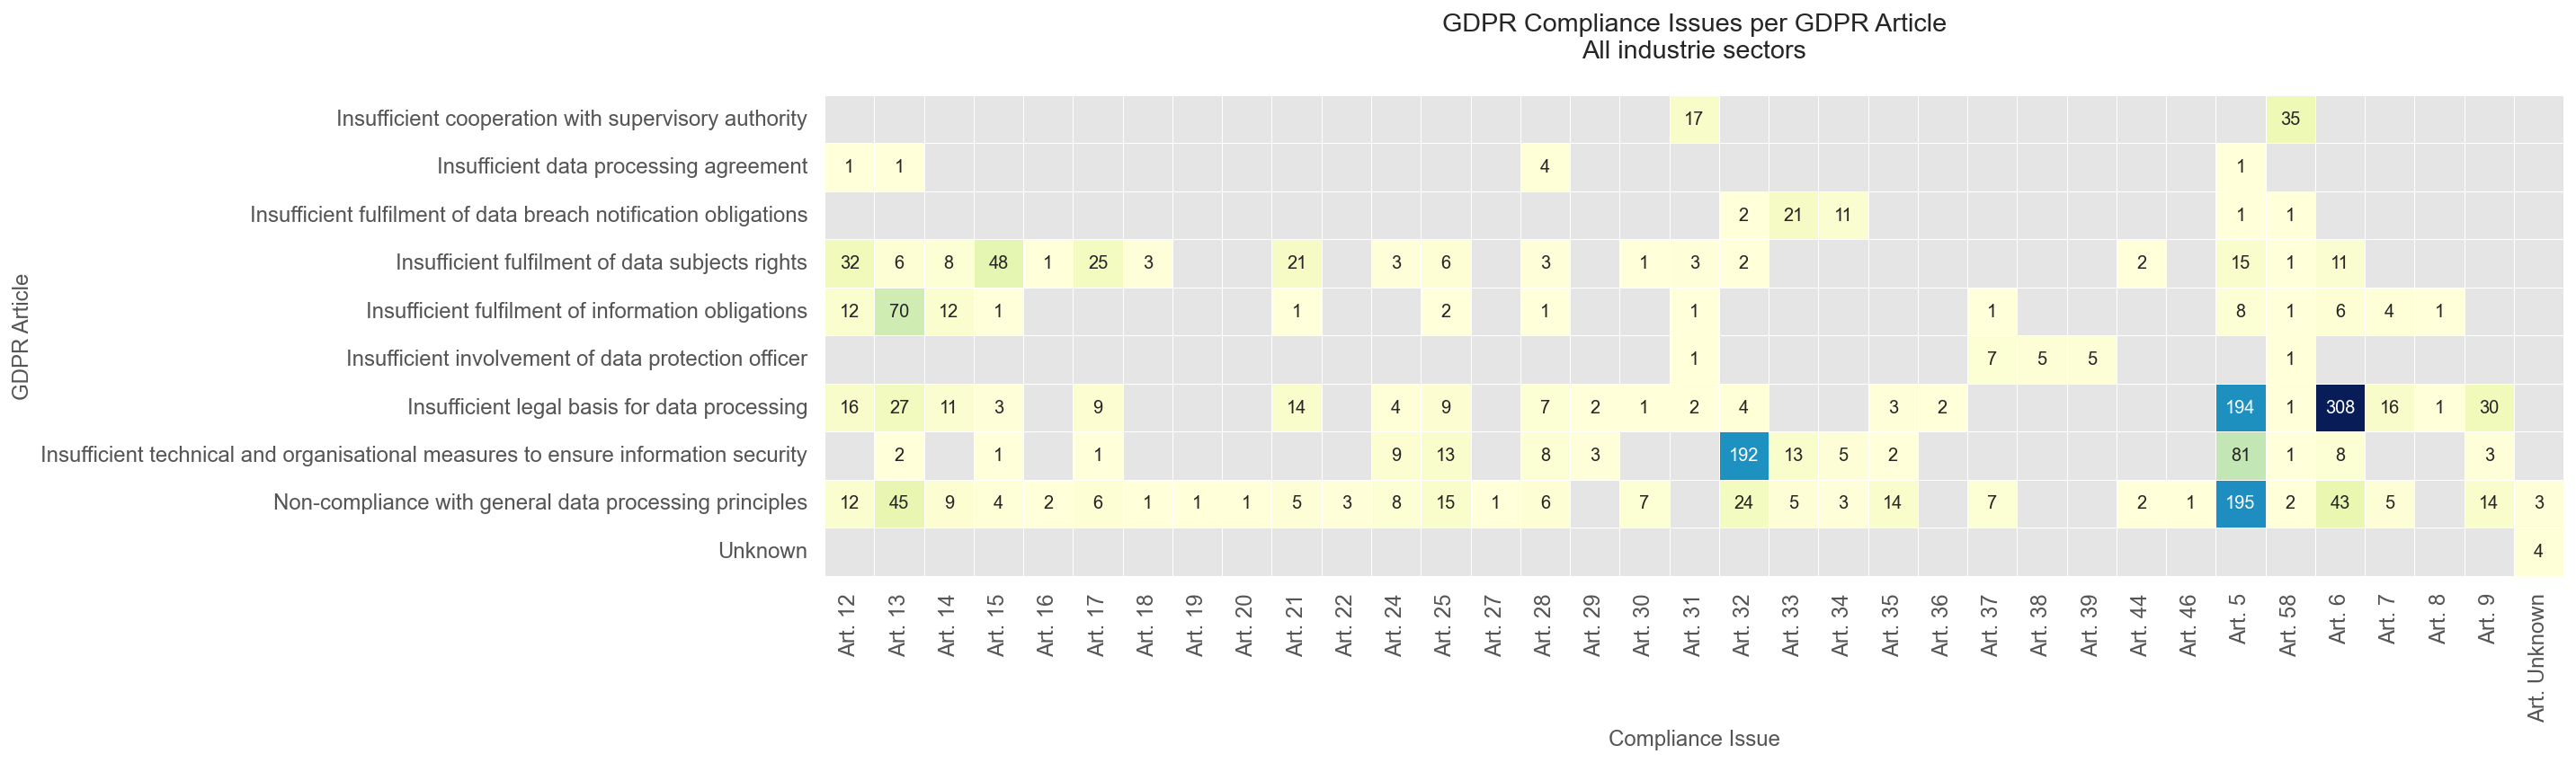

In [729]:
plt.rcParams["figure.figsize"] = [20, 6]
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.style.use('ggplot')

plt.rcParams["figure.autolayout"] = True
ax = sns.heatmap(plot_df, annot=True, linewidths=.5, fmt=".0f", cbar=False, cmap="YlGnBu")
plt.title("GDPR Compliance Issues per GDPR Article\nAll industrie sectors\n")
plt.ylabel("GDPR Article")
plt.xlabel("Compliance Issue")
#plt.xticks(rotation=65)
plt.show();

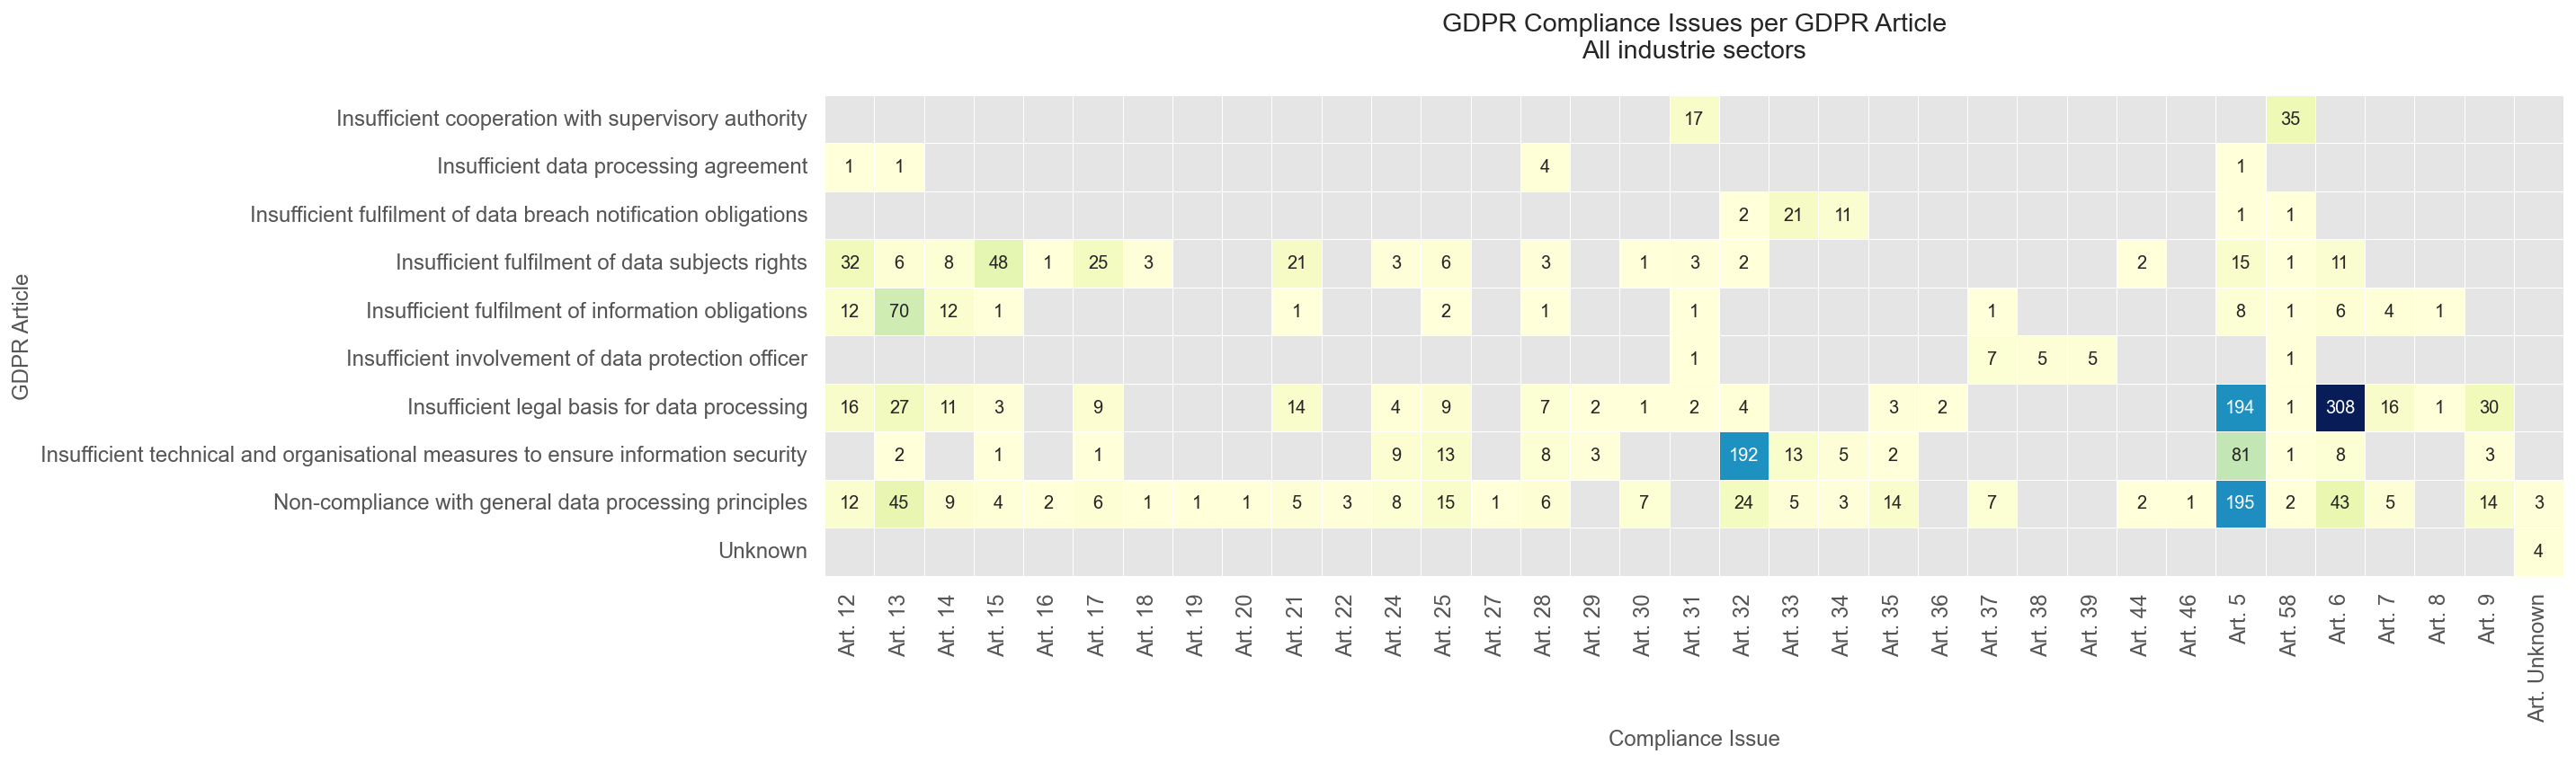

In [730]:
plt.rcParams["figure.figsize"] = [20, 6]
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.style.use('ggplot')

plt.rcParams["figure.autolayout"] = True
ax = sns.heatmap(plot_df, annot=True, linewidths=.5, fmt=".0f", cbar=False, cmap="YlGnBu")
plt.title("GDPR Compliance Issues per GDPR Article\nAll industrie sectors\n")
plt.ylabel("GDPR Article")
plt.xlabel("Compliance Issue")
#plt.xticks(rotation=65)
plt.show();

#### Extra: Check Correlation for Quoted GDPR Articles

In [731]:
# Group features
numerical_features = df_split.select_dtypes(include=[np.number]).columns.tolist()
df_split_num = df_split[numerical_features]

In [732]:
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_split_num.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

## Answer Hypothesis (Advanced Questions)

### **A higher GDP could lead to more reported cases**
because a higher GDP could mean more companies in the country

#### Prepare DataFrame

In [733]:
df.head()

etid country     fine                     controller_processor  \
0  ETid-986  GREECE 30,000.0              Info Communication Services   
1  ETid-985  GREECE 25,000.0                  Plus Real Advertisement   
2  ETid-957  GREECE 30,000.0                  One Way Private Company   
3  ETid-919  GREECE 20,000.0  Καπα Λαμδα Ωμεγα Διαφημιστικη Εμπορι...   
4  ETid-897  GREECE  5,000.0  Premiummedia Παραγωγη Οπτικο-Ακουστι...   

                                   article  \
0  Art. 13 GDPR, Art. 14 GDPR, Art. 11 ...   
1  Art. 13 GDPR, Art. 14 GDPR, Art. 11 ...   
2  Art. 28 (3) c) GDPR, Art. 32 (2), (4...   
3  Art. 6 GDPR, Art. 12 (2) GDPR, Art. ...   
4           Art. 21 (3) GDPR, Art. 25 GDPR   

                            violation_type                            sector  \
0  Insufficient fulfilment of informati...             Industry and Commerce   
1  Insufficient fulfilment of informati...             Industry and Commerce   
2  Insufficient technical and organisat...  Media, Telecoms and Broadcasting   
3  Insufficient legal basis for data pr...             Industry and Commerce   
4  Insufficient fulfilment of data subj...             Industry and Commerce   

                                   summary decision_date_imputed  \
0  The Hellenic DPA has imposed a fine ...                    No   
1  The Hellenic DPA has imposed a fine ...                    No   
2  The Hellenic DPA has imposed a fine ...                    No   
3  The Hellenic DPA has fined ΚΑΠΑ ΛΑΜΔ...                    No   
4  The Hellenic DPA has imposed a fine ...                    No   

   decision_year  fine_cat  fine_cat2  mapping_key  country_label  \
0           2021  30,000.0        6.0  GREECE-2021             11   
1           2021  25,000.0        6.0  GREECE-2021             11   
2           2021  30,000.0        6.0  GREECE-2021             11   
3           2021  20,000.0        5.0  GREECE-2021             11   
4           2021   5,000.0        3.0  GREECE-2021             11   

   violation_type_label  sector_label               gdp           gdp_cat  \
0                     4             5 212,266,363,527.0 210,000,000,000.0   
1                     4             5 212,266,363,527.0 210,000,000,000.0   
2                     7             6 212,266,363,527.0 210,000,000,000.0   
3                     6             5 212,266,363,527.0 210,000,000,000.0   
4                     3             5 212,266,363,527.0 210,000,000,000.0   

   gdp_cat2 iso3  cpi_score  cpi_score_cat  cpi_score_cat2  population  \
0       6.0  GRC       44.0           40.0             5.0    10376349   
1       6.0  GRC       44.0           40.0             5.0    10376349   
2       6.0  GRC       44.0           40.0             5.0    10376349   
3       6.0  GRC       44.0           40.0             5.0    10376349   
4       6.0  GRC       44.0           40.0             5.0    10376349   

   population_cat  population_cat2  
0        10400000              6.0  
1        10400000              6.0  
2        10400000              6.0  
3        10400000              6.0  
4        10400000              6.0

In [734]:
#df_ada_grouped = df.groupby(['country'])['fine','gdp','cpi_score','population'].agg({'fine':['median','mean'],'gdp':'mean','cpi_score':'mean','population':'mean'}).reset_index()
df_ada_grouped = df.groupby(['decision_year','country'])['fine','gdp','cpi_score','population','gdp_cat','cpi_score_cat','population_cat'].agg(['median','mean']).reset_index()
df_ada_grouped.head()

decision_year         country     fine                          gdp  \
                                  median     mean              median   
0          2018         AUSTRIA  2,000.0  2,275.0   454,872,626,780.0   
1          2018        BULGARIA    500.0    500.0    66,230,155,100.0   
2          2018  CZECH REPUBLIC    388.0    388.0   248,950,103,352.0   
3          2018         GERMANY 12,500.0 11,279.5 3,975,347,237,443.0   
4          2018         HUNGARY  3,200.0  3,200.0   160,431,092,909.0   

                      cpi_score        population               \
                 mean    median mean       median         mean   
0   454,872,626,780.0      76.0 76.0  8,891,388.0  8,891,388.0   
1    66,230,155,100.0      42.0 42.0  7,051,608.0  7,051,608.0   
2   248,950,103,352.0      59.0 59.0 10,665,677.0 10,665,677.0   
3 3,975,347,237,443.0      80.0 80.0 83,124,418.0 83,124,418.0   
4   160,431,092,909.0      46.0 46.0  9,707,499.0  9,707,499.0   

              gdp_cat                     cpi_score_cat      population_cat  \
               median                mean        median mean         median   
0   450,000,000,000.0   450,000,000,000.0          80.0 80.0    8,900,000.0   
1    70,000,000,000.0    70,000,000,000.0          40.0 40.0    7,100,000.0   
2   250,000,000,000.0   250,000,000,000.0          60.0 60.0   10,700,000.0   
3 3,980,000,000,000.0 3,980,000,000,000.0          80.0 80.0   83,100,000.0   
4   160,000,000,000.0   160,000,000,000.0          50.0 50.0    9,700,000.0   

                
          mean  
0  8,900,000.0  
1  7,100,000.0  
2 10,700,000.0  
3 83,100,000.0  
4  9,700,000.0

In [735]:
# flatten grouped dataframe
df_ada_grouped_flatten = df_ada_grouped.copy()
df_ada_grouped_flatten.columns = ['_'.join(i).rstrip('_') for i in df_ada_grouped_flatten.columns.values]
#df_ada_grouped_flatten

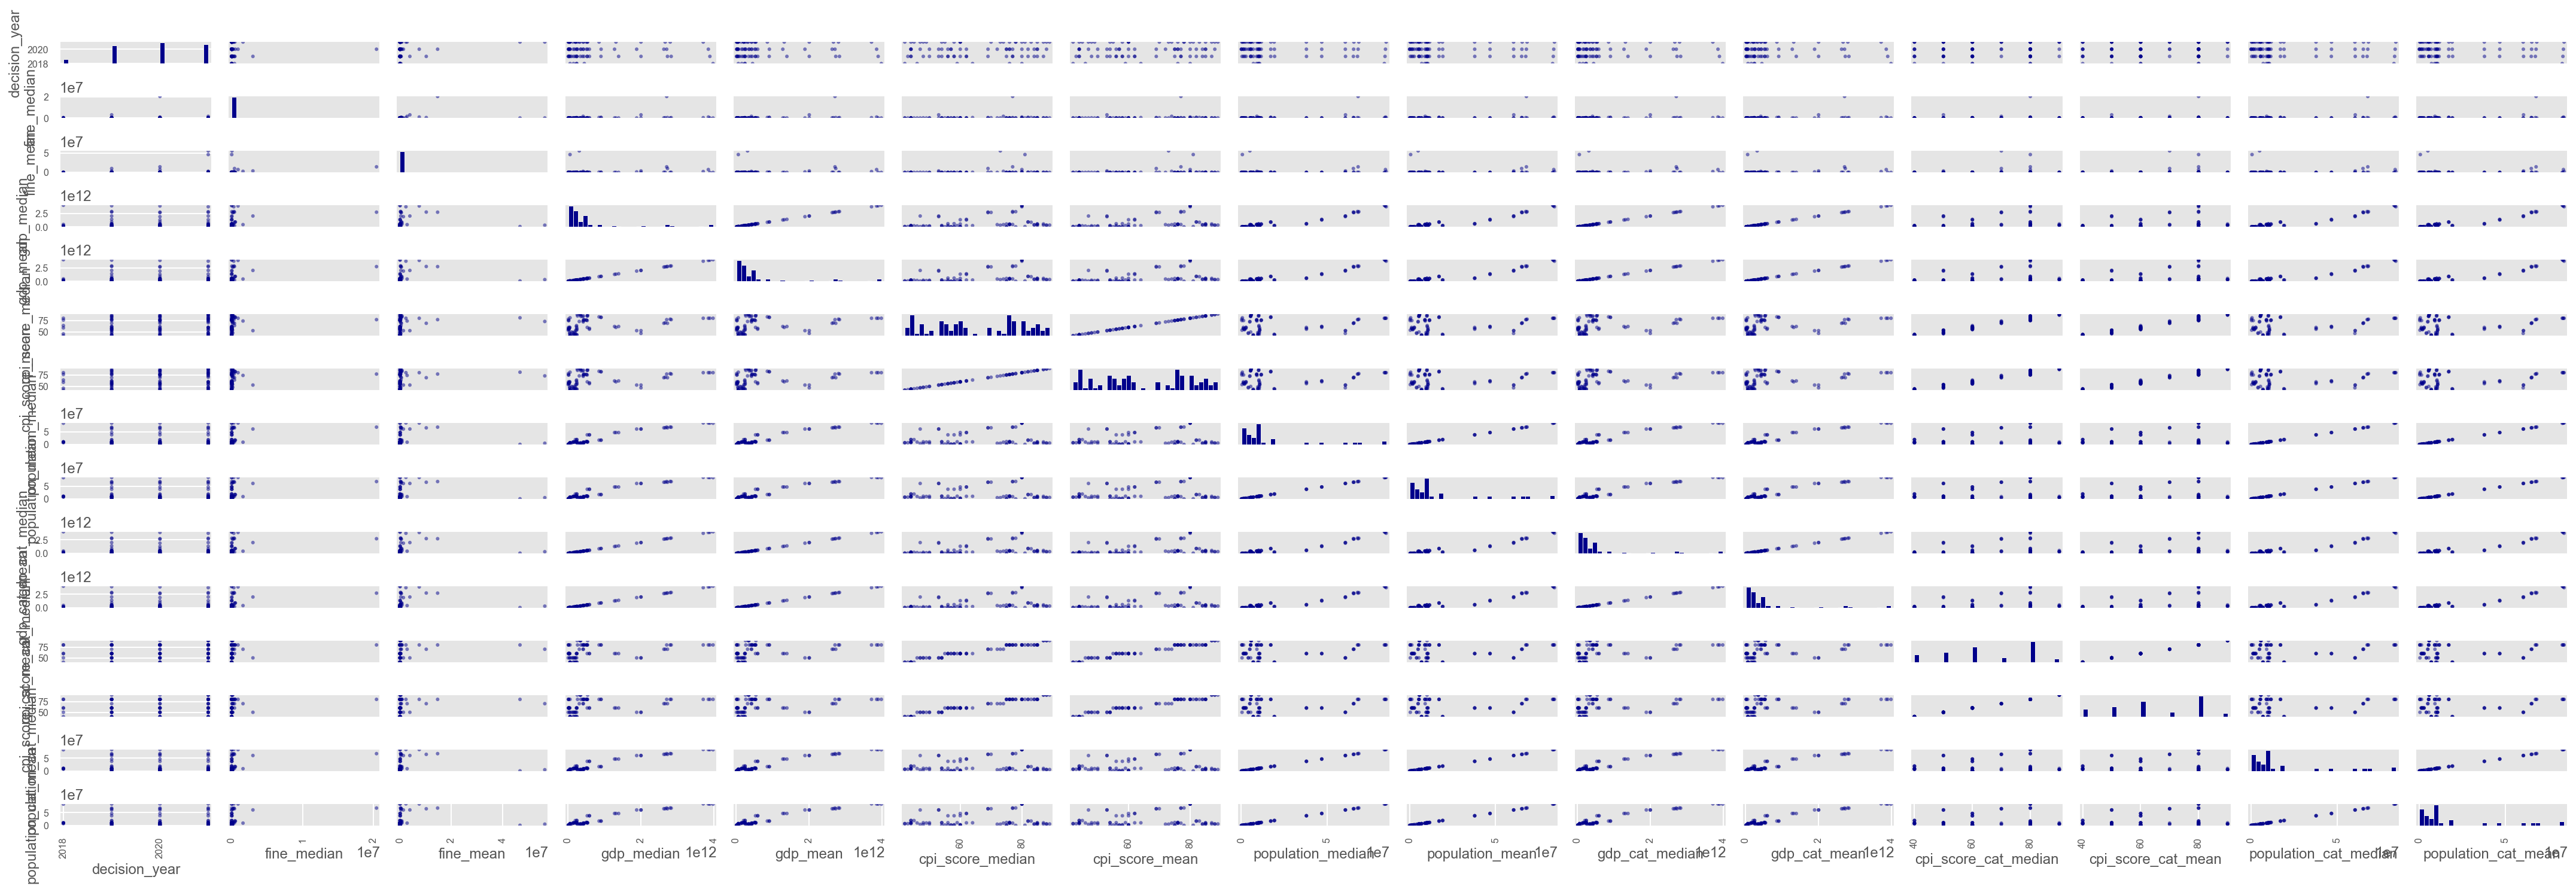

In [736]:
pd.plotting.scatter_matrix(df_ada_grouped_flatten, figsize=(30,10),color='darkblue', hist_kwds={'bins':30, 'color':'darkblue'} );

#### Check Distribution - "Outliers" Included

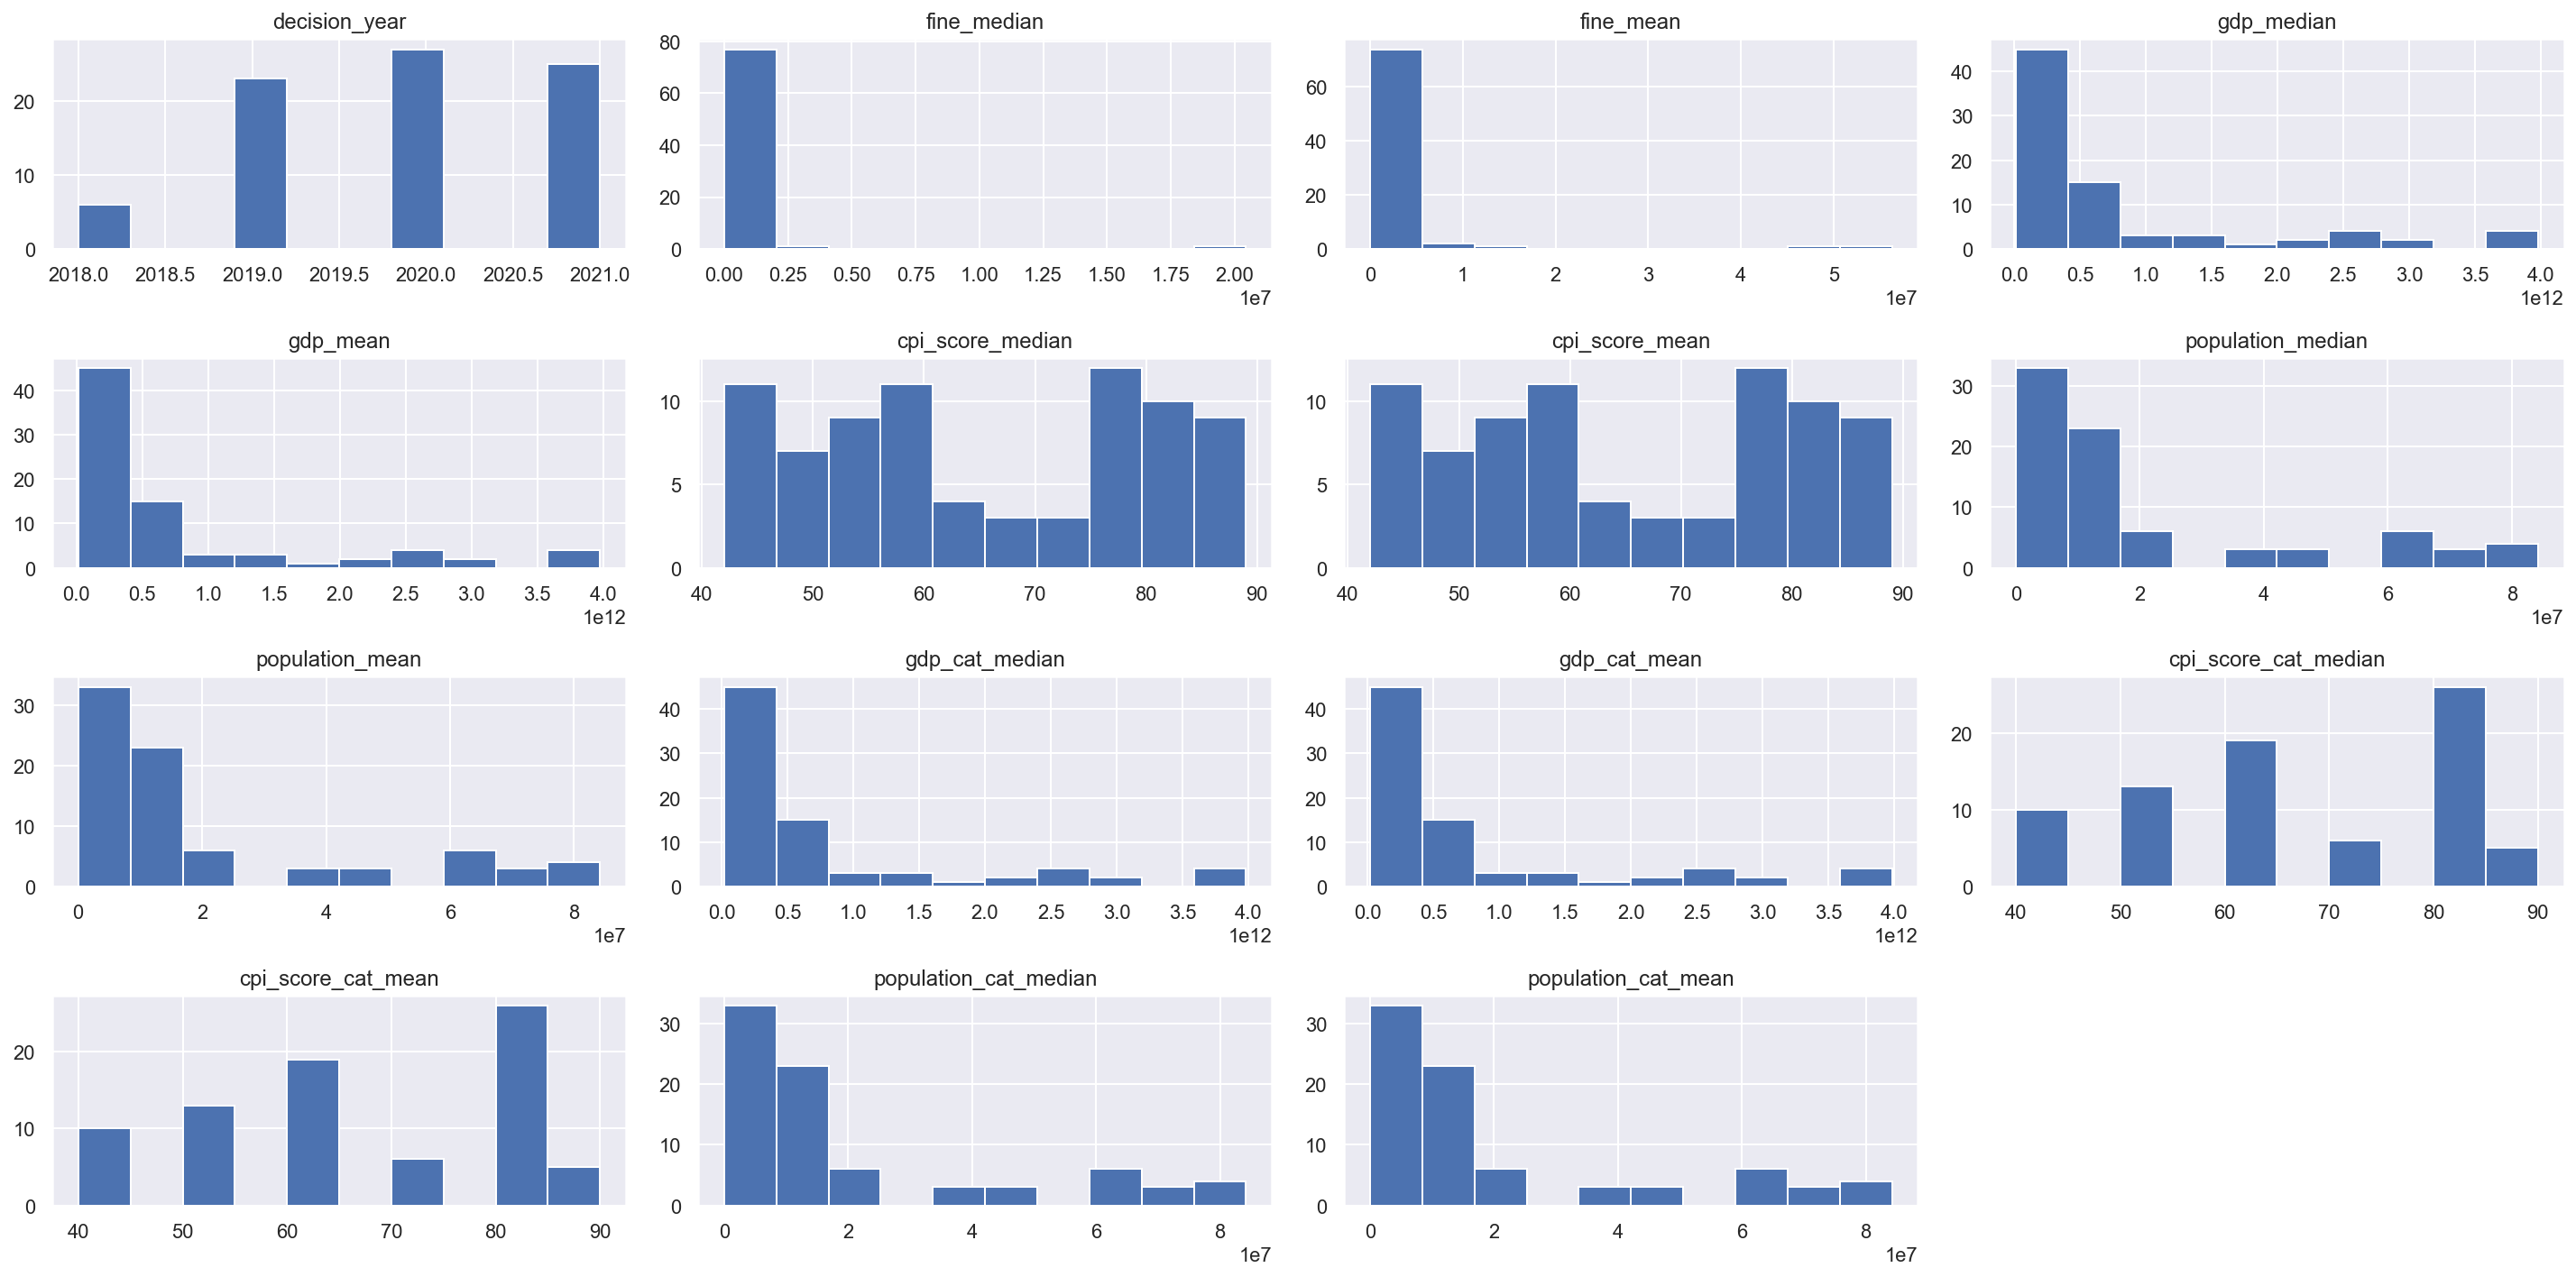

In [737]:
# Check distribution
sns.set(rc={"figure.figsize":(20, 10)})
df_ada_grouped_flatten.hist();

- The aggregated values are not normally distributed. Therefore, **Spearmans'** correlation coefficient will be used for the correlation analysis.
- The aggregated values show outliers, especially for fine (sum), fine (count), fine (mean) and gdp (mean). Those outliers should be reviewed and addressed for an analysis where the outliers have been removed.

#### Check Correlations - "Outliers" Included

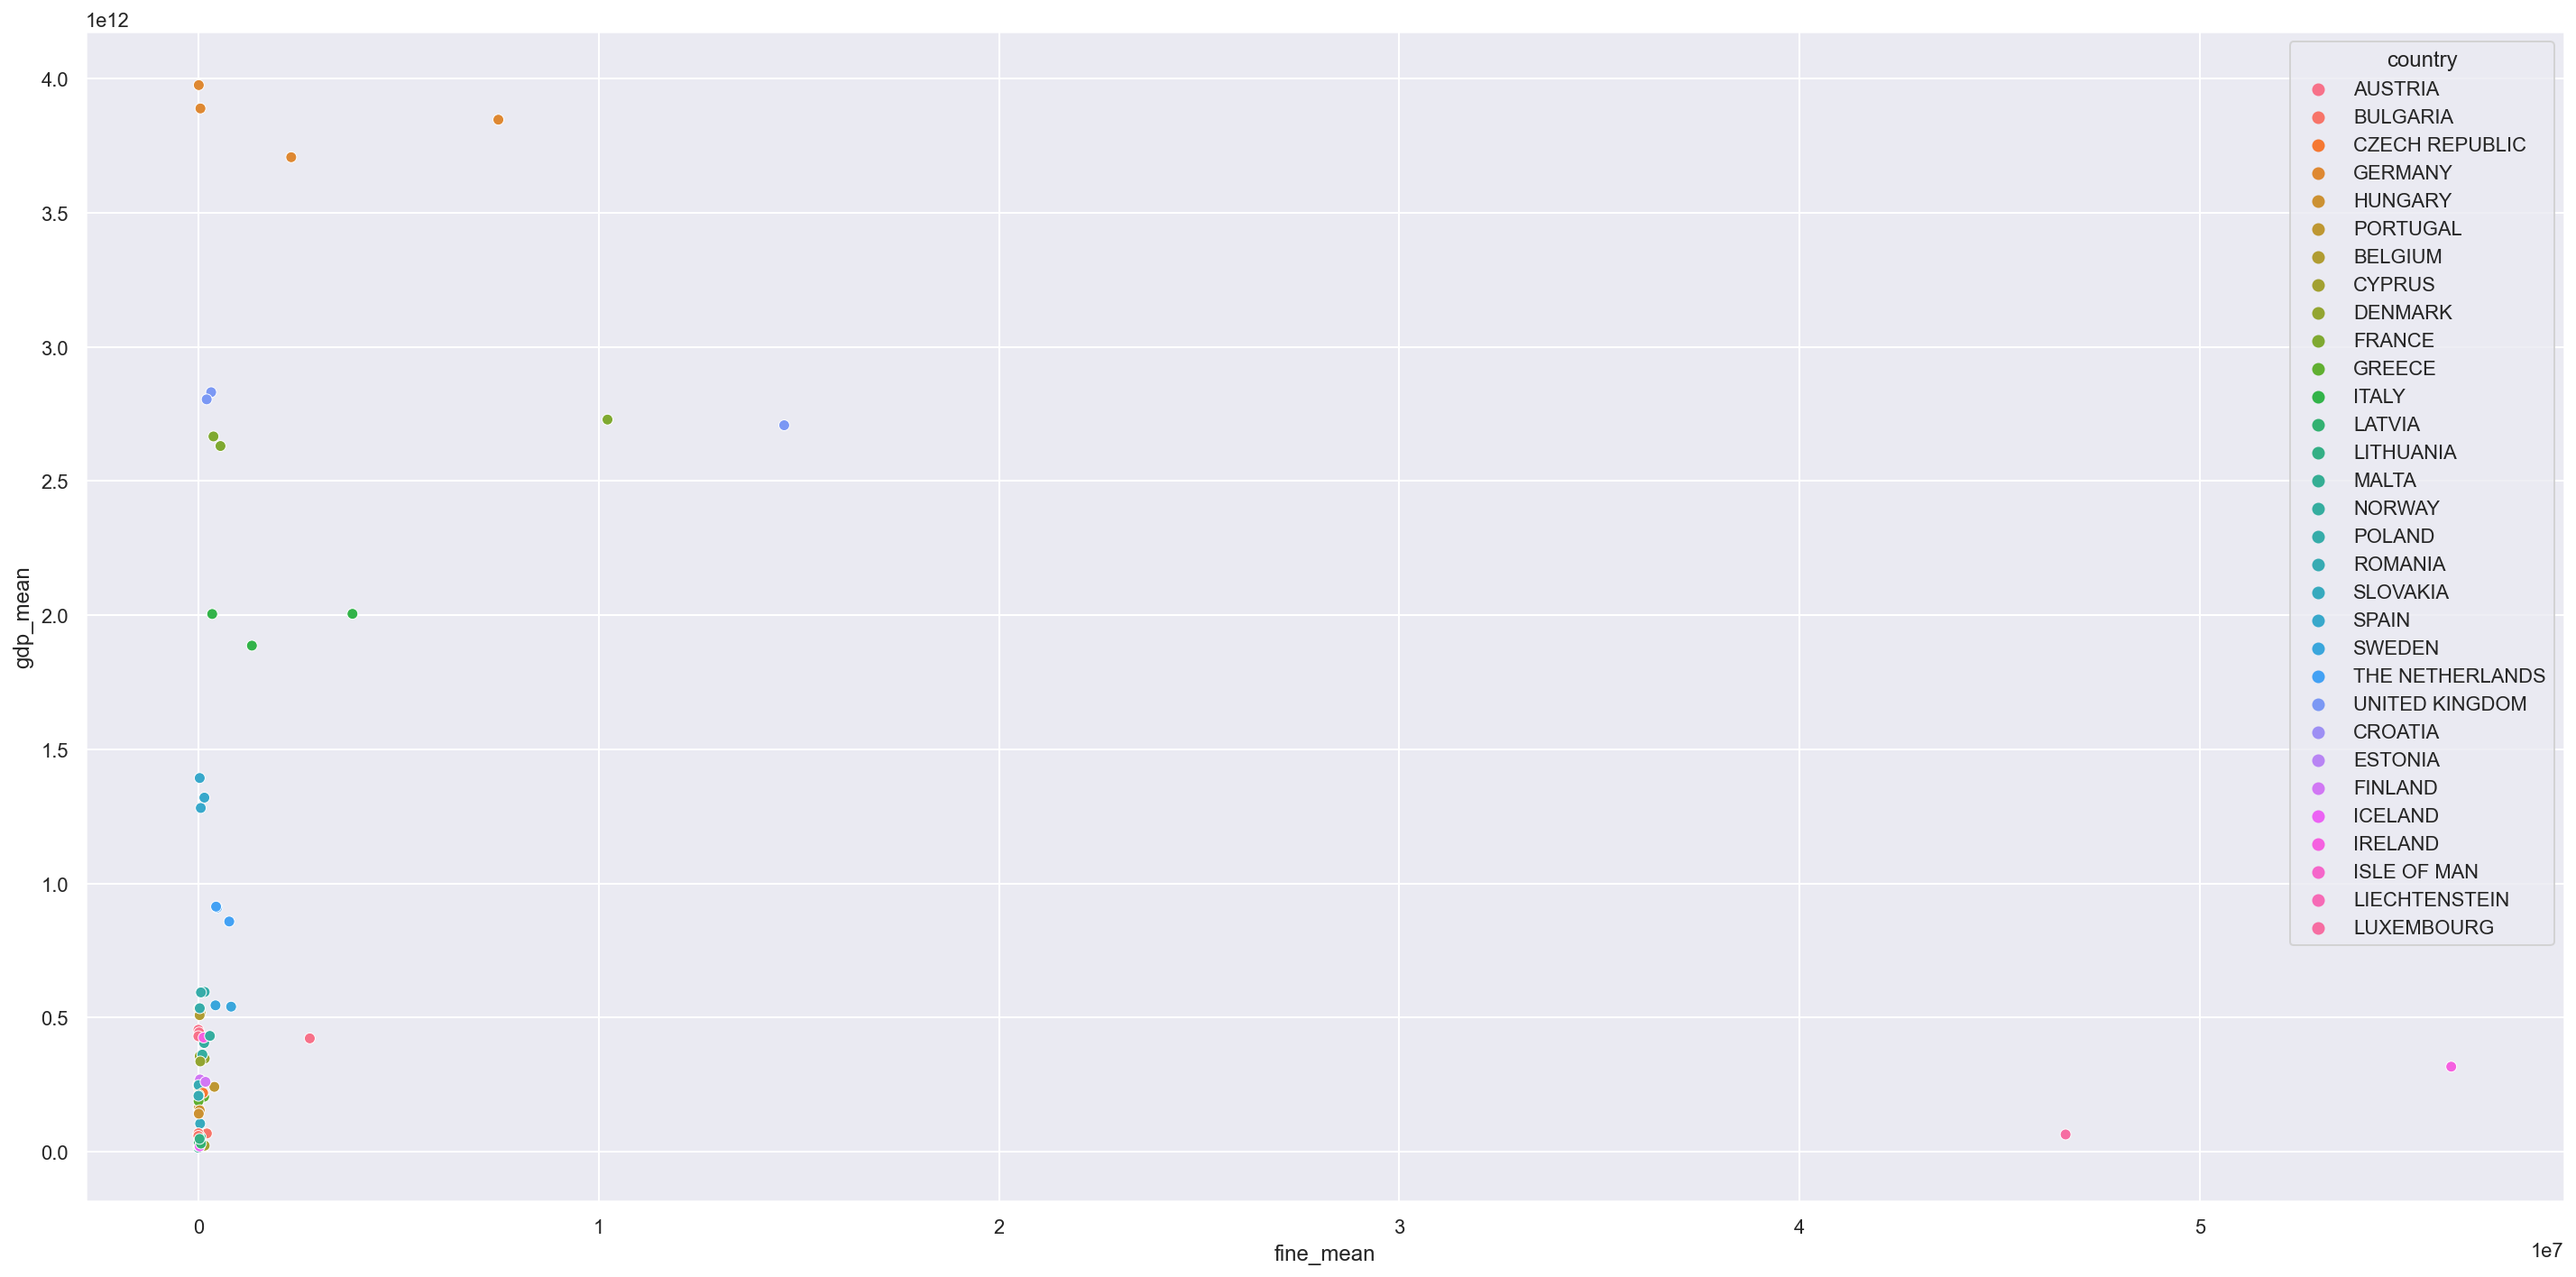

In [738]:
# Checking correlation with "outliers"
sns.set(rc={"figure.figsize":(20, 10)})
sns.scatterplot(data=df_ada_grouped_flatten, x="fine_mean", y="gdp_mean", hue="country",);

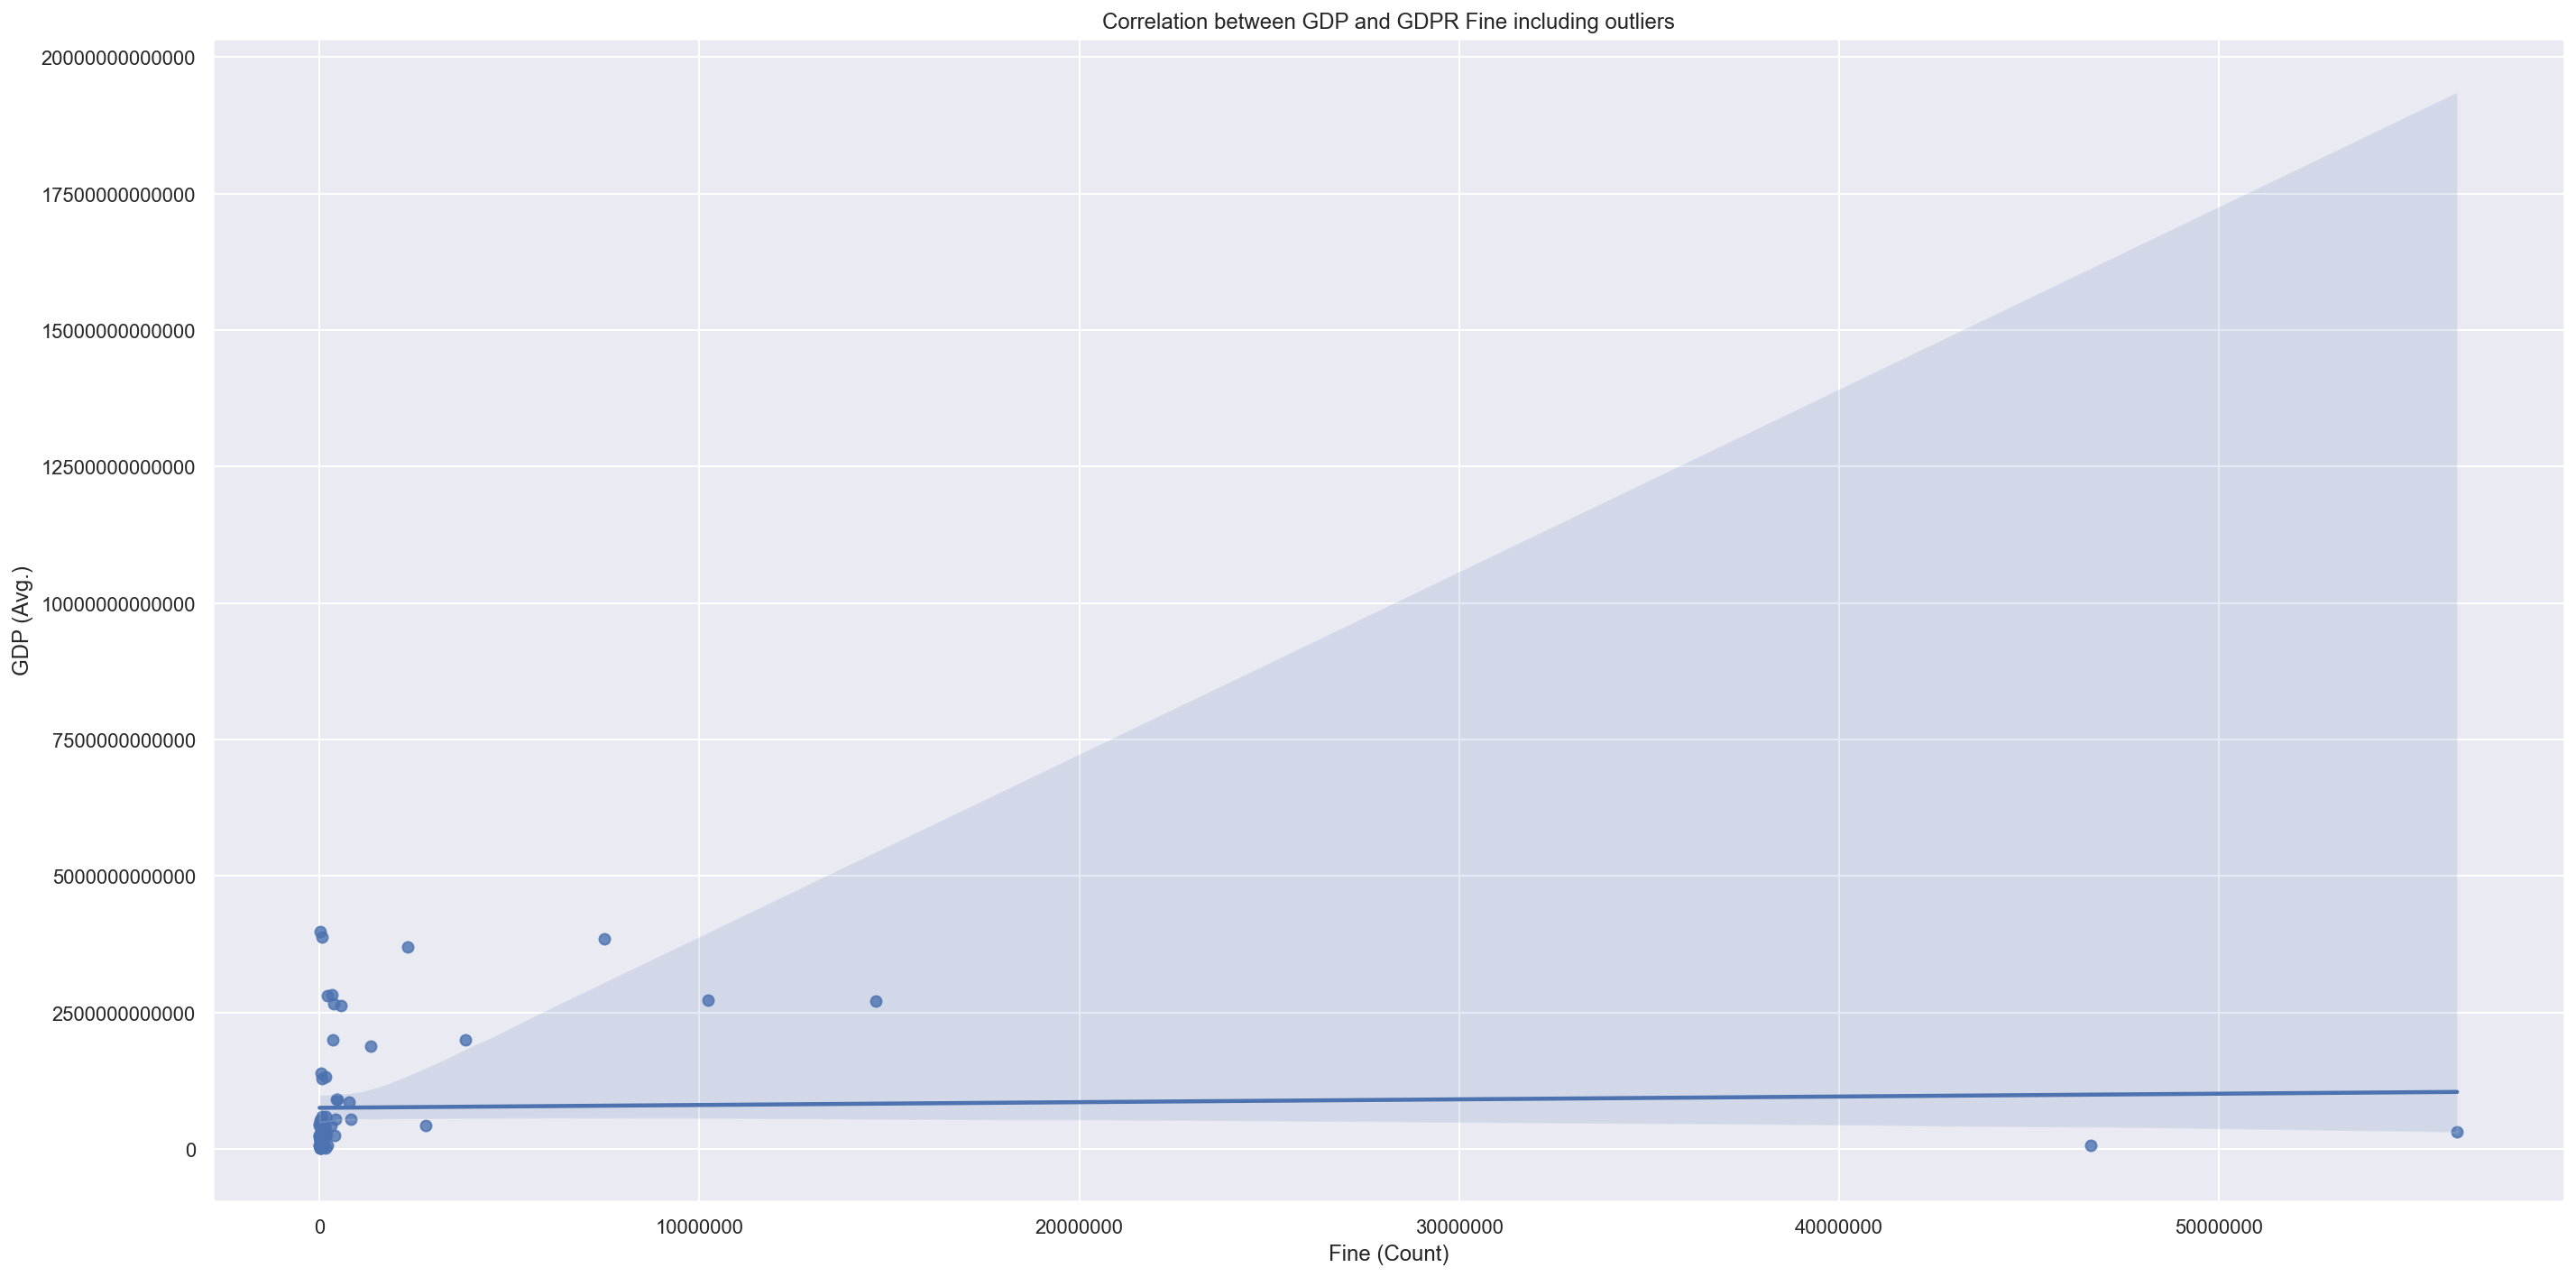

In [739]:
# Checking correlation with "outliers" and trendline
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_ada_grouped_flatten, x="fine_mean", y="gdp_mean");
chart.set(title='Correlation between GDP and GDPR Fine including outliers', xlabel='Fine (Count)', ylabel="GDP (Avg.)");

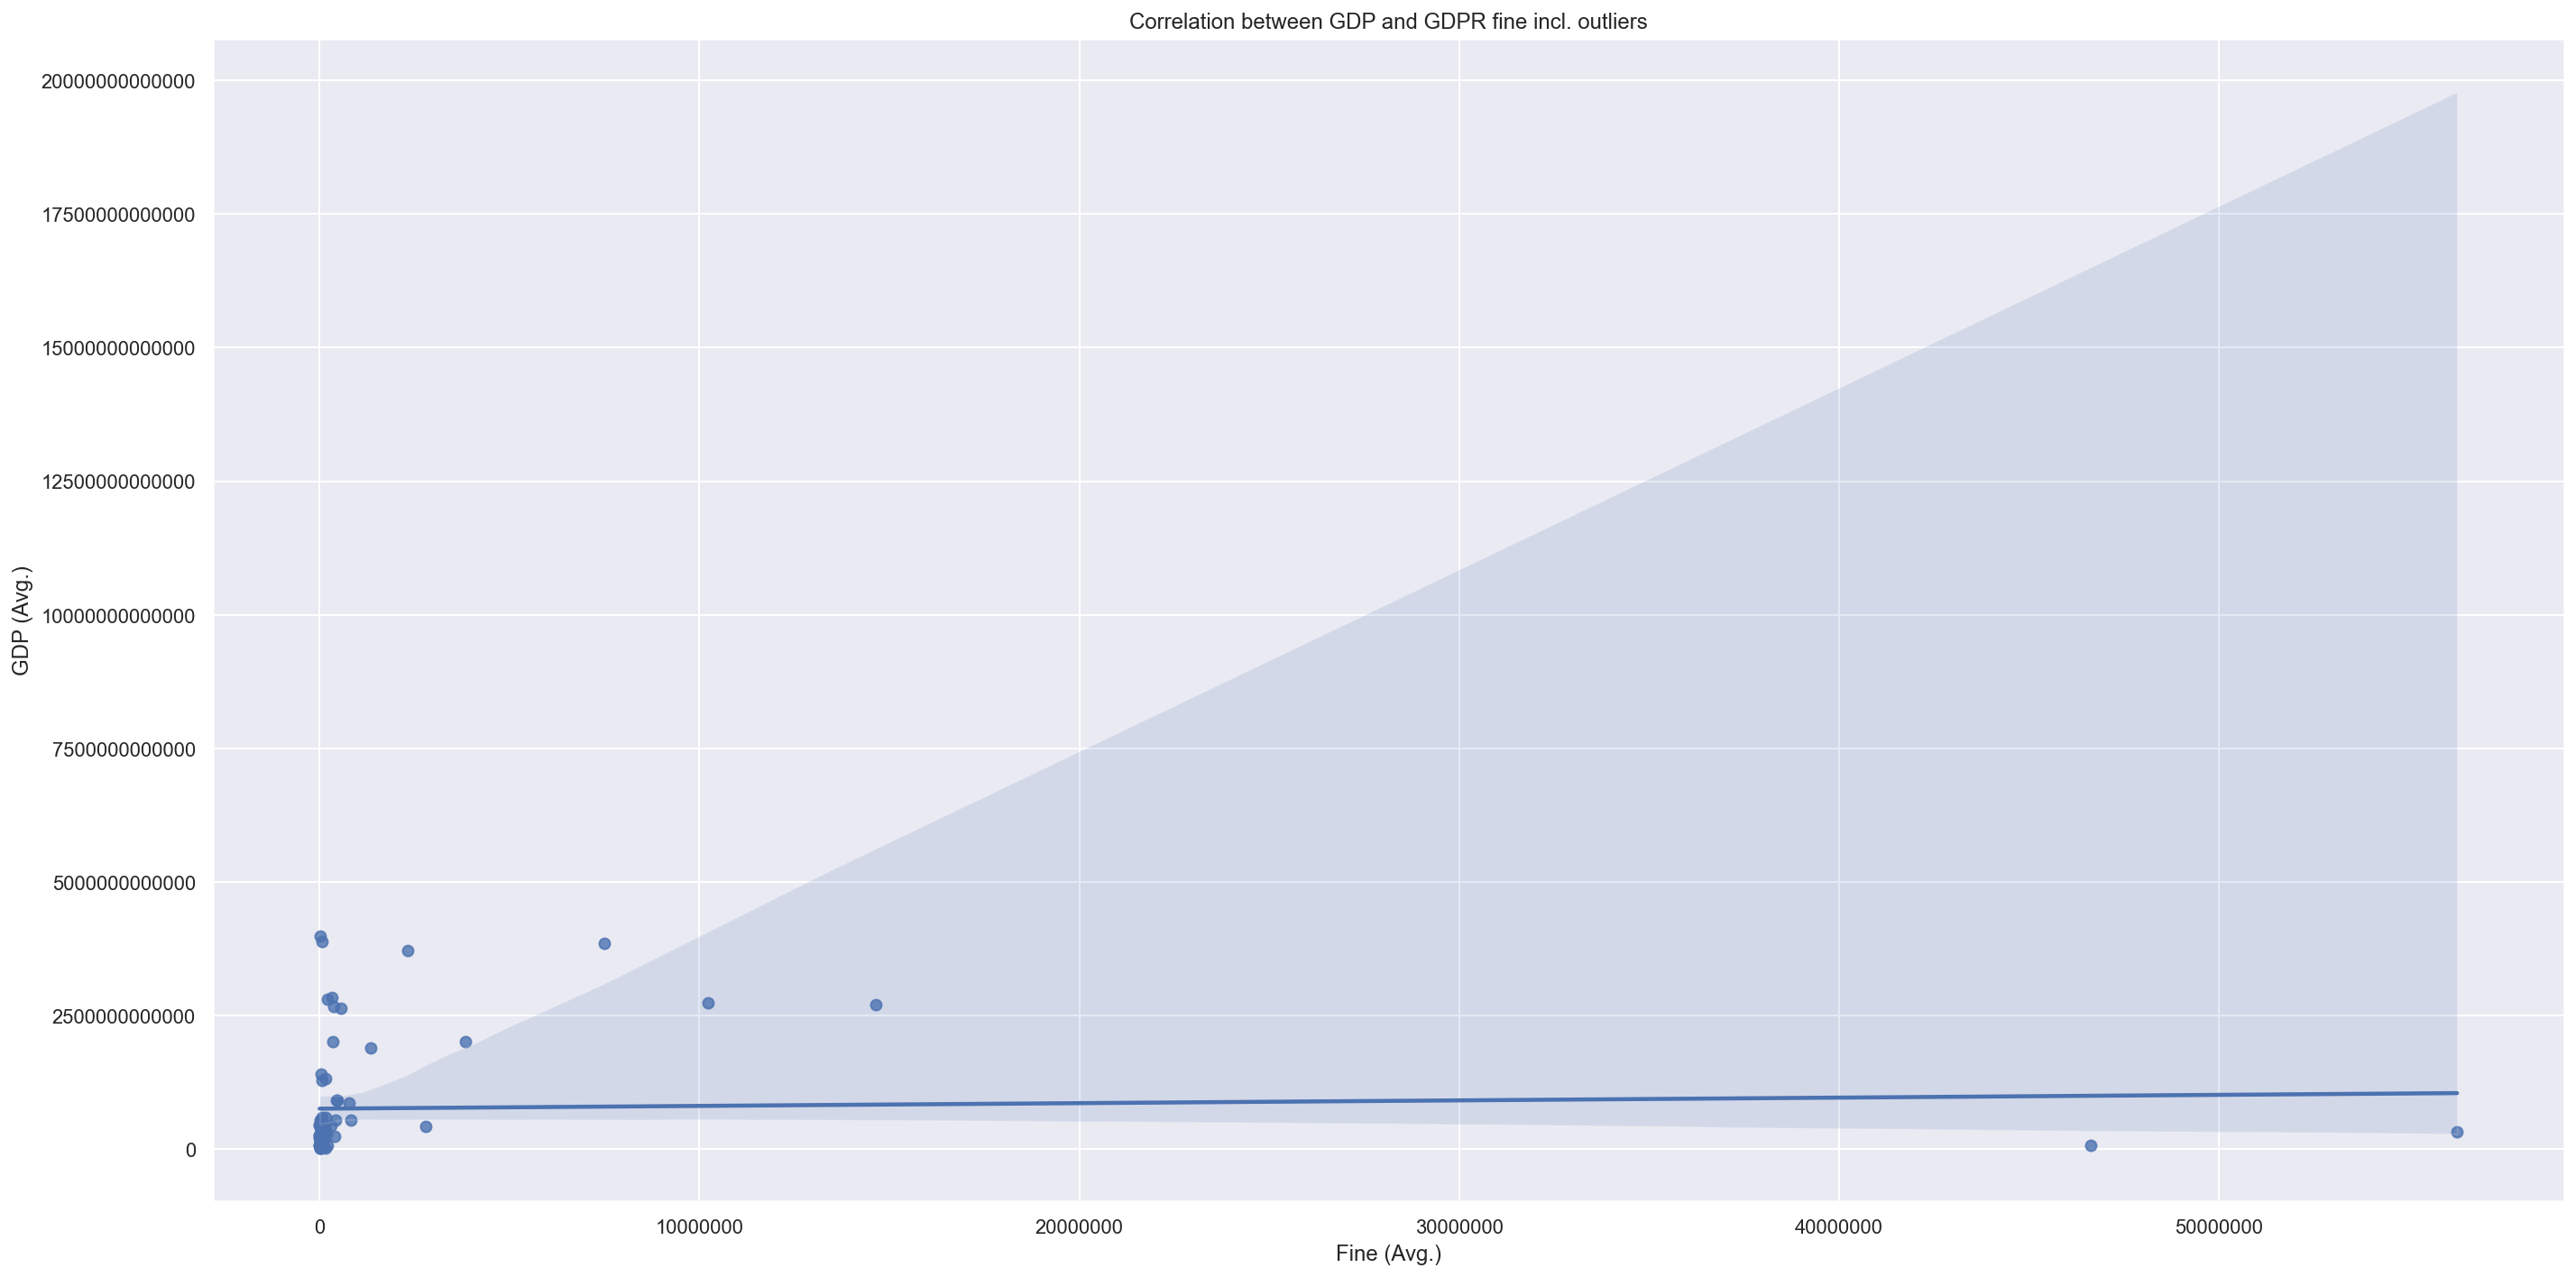

In [740]:
# Checking correlation with "outliers" and trendline
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_ada_grouped_flatten, x="fine_mean", y="gdp_mean");
chart.set(title='Correlation between GDP and GDPR fine incl. outliers', xlabel='Fine (Avg.)', ylabel="GDP (Avg.)");

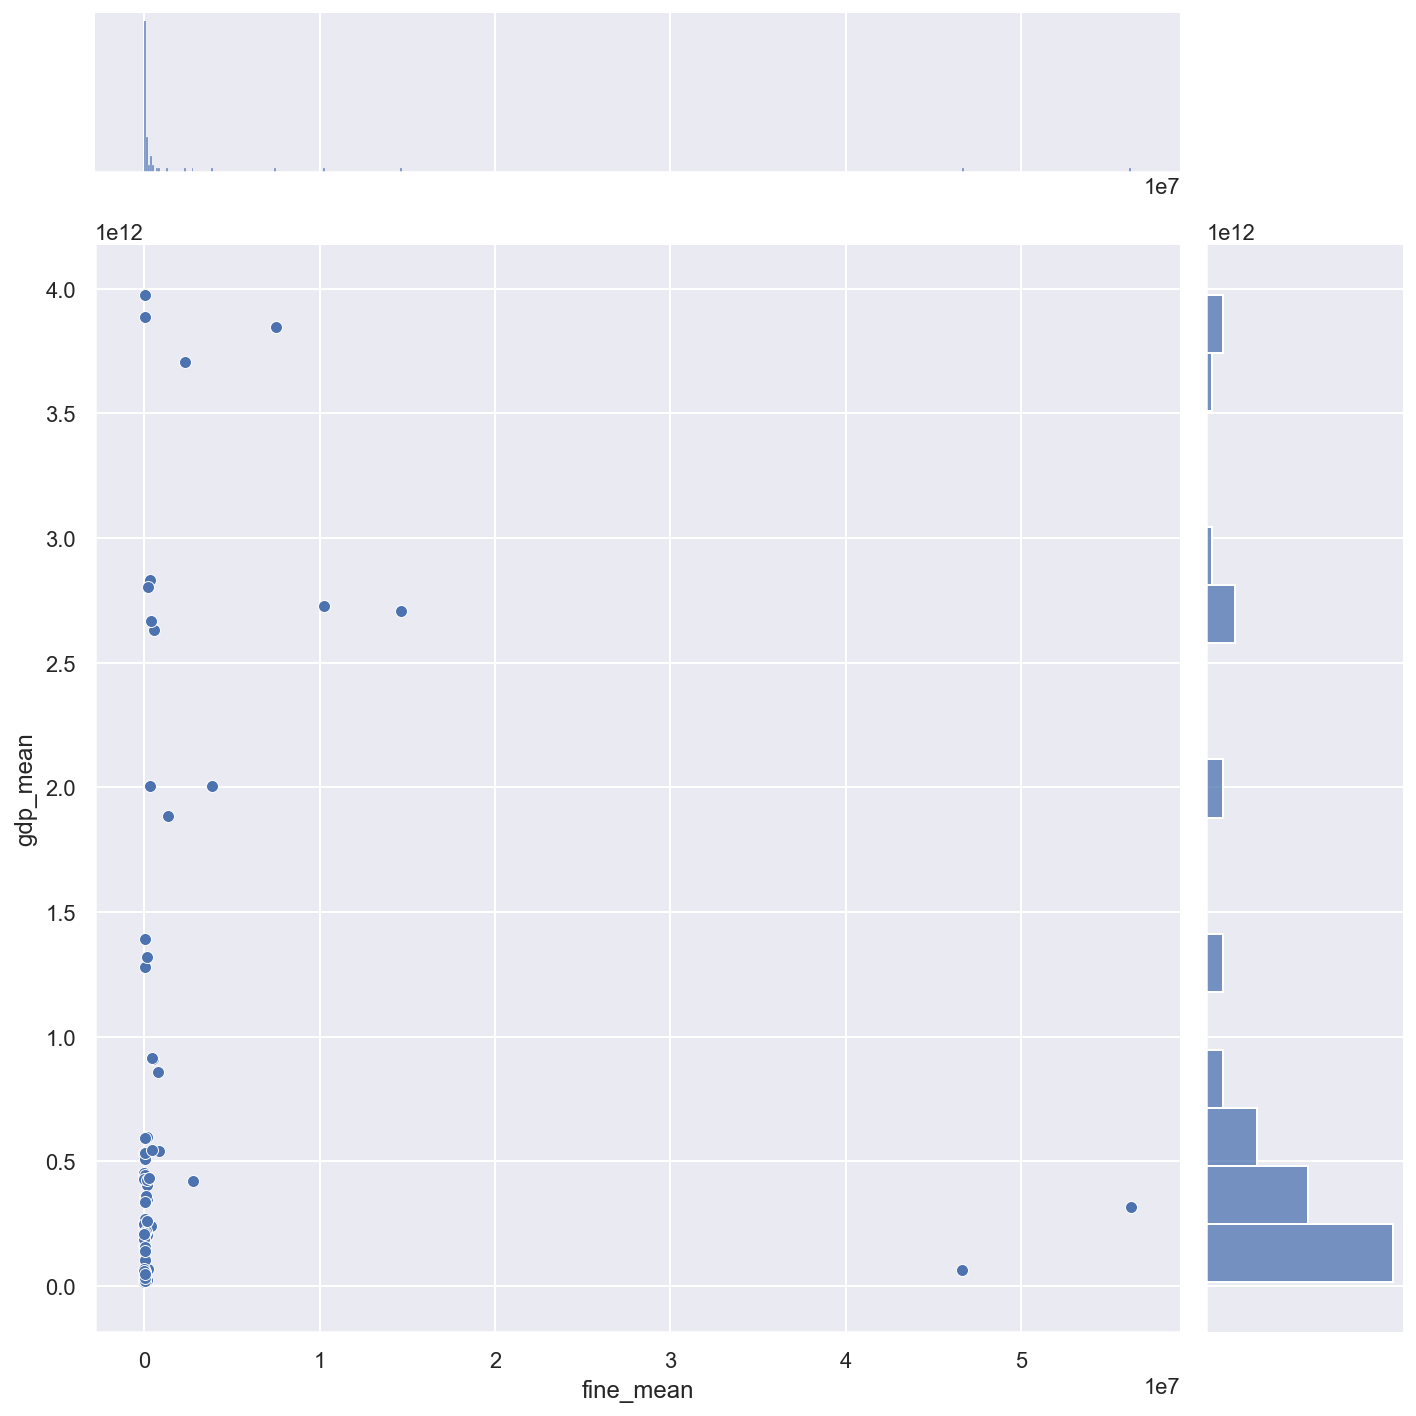

In [741]:
# Checking correlation with "outliers" and distribution (histogram)
sns.jointplot(data=df_ada_grouped_flatten, x="fine_mean", y="gdp_mean", height=10);

In [742]:
# Calculate correlation coefficient with Spearman correlation coefficient, because we
# A) Assume a linear relationship, base from the frist scatter plots
# B) Know that the features are not normally distributed
corr_df = df_ada_grouped_flatten.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

#### Identify and Address "Outliers"

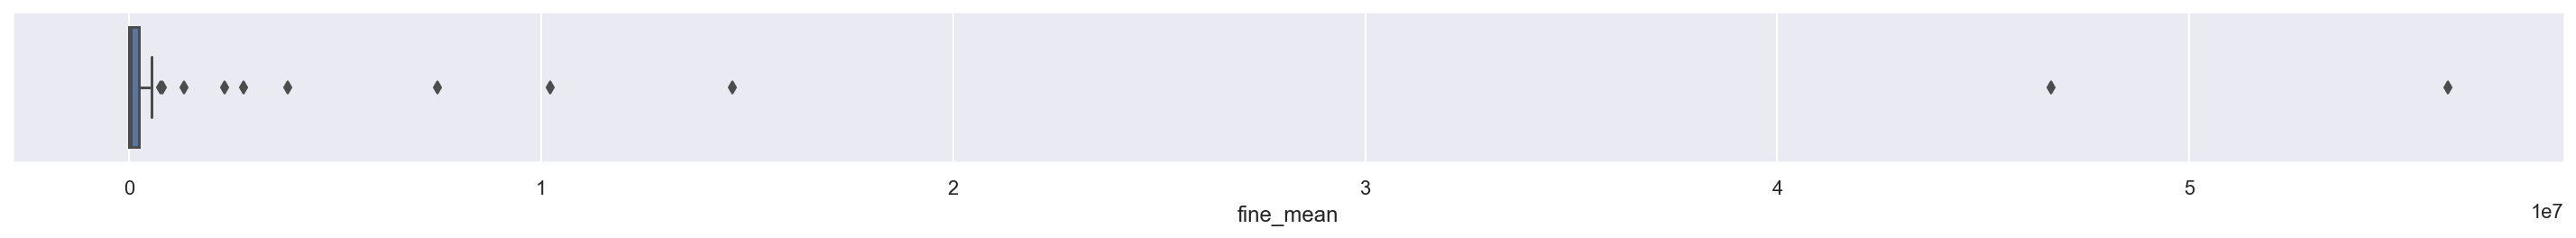

In [743]:
# Identify and remove fine_count "outlier"
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten, x="fine_mean");

In [744]:
df_ada_grouped_flatten[df_ada_grouped_flatten['fine_mean'] > 10000000].round(0).sort_values('fine_mean', ascending=False)

decision_year         country  fine_median    fine_mean  \
69           2021         IRELAND     45,750.0 56,273,225.0   
73           2021      LUXEMBOURG     10,050.0 46,641,119.0   
55           2020  UNITED KINGDOM 20,450,000.0 14,633,667.0   
12           2019          FRANCE    400,000.0 10,220,000.0   

            gdp_median            gdp_mean  cpi_score_median  cpi_score_mean  \
69   317,444,608,641.0   317,444,608,641.0              73.0            73.0   
73    64,692,749,785.0    64,692,749,785.0              81.0            81.0   
55 2,707,743,777,174.0 2,707,743,777,174.0              77.0            77.0   
12 2,728,870,246,706.0 2,728,870,246,706.0              69.0            69.0   

    population_median  population_mean      gdp_cat_median  \
69        4,996,931.0      4,996,931.0   320,000,000,000.0   
73          638,549.0        638,549.0    60,000,000,000.0   
55       67,886,011.0     67,886,011.0 2,710,000,000,000.0   
12       65,129,728.0     65,129,728.0 2,730,000,000,000.0   

          gdp_cat_mean  cpi_score_cat_median  cpi_score_cat_mean  \
69   320,000,000,000.0                  70.0                70.0   
73    60,000,000,000.0                  80.0                80.0   
55 2,710,000,000,000.0                  80.0                80.0   
12 2,730,000,000,000.0                  70.0                70.0   

    population_cat_median  population_cat_mean  
69            5,000,000.0          5,000,000.0  
73              600,000.0            600,000.0  
55           67,900,000.0         67,900,000.0  
12           65,100,000.0         65,100,000.0

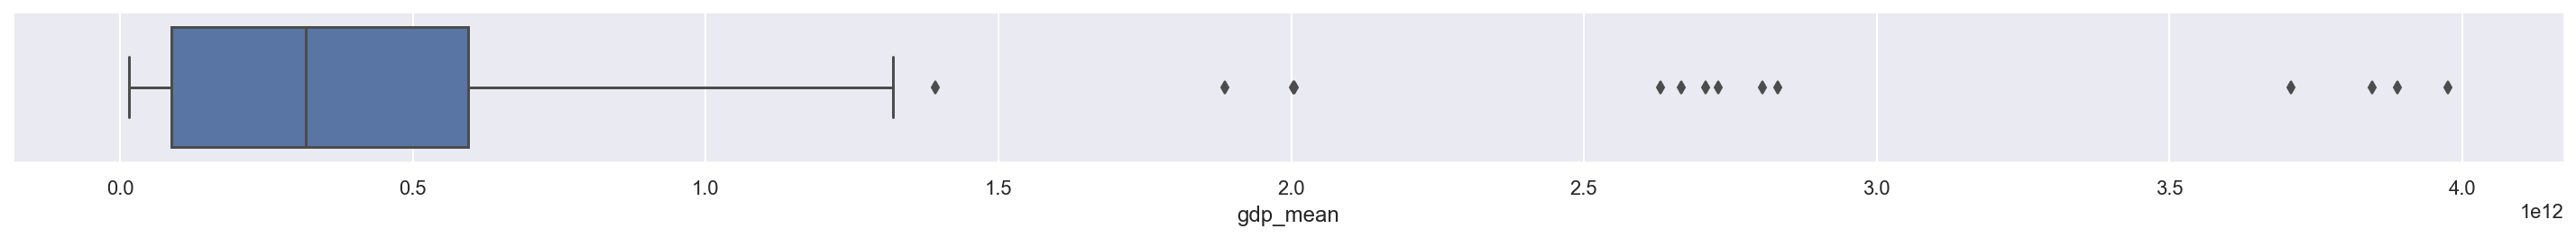

In [745]:
# Identify and remove gdp_mean "outlier"
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten, x="gdp_mean");

In [746]:
df_ada_grouped_flatten[df_ada_grouped_flatten['gdp_mean'] > 1000000000000].round(0).sort_values('gdp_mean', ascending=False)


decision_year         country  fine_median    fine_mean  \
3            2018         GERMANY     12,500.0     11,280.0   
13           2019         GERMANY     15,000.0     52,188.0   
39           2020         GERMANY    900,000.0  7,494,142.0   
65           2021         GERMANY    300,000.0  2,320,000.0   
28           2019  UNITED KINGDOM    320,000.0    320,000.0   
80           2021  UNITED KINGDOM     29,000.0    208,600.0   
12           2019          FRANCE    400,000.0 10,220,000.0   
55           2020  UNITED KINGDOM 20,450,000.0 14,633,667.0   
64           2021          FRANCE    240,000.0    377,800.0   
38           2020          FRANCE    128,650.0    552,717.0   
16           2019           ITALY  3,000,000.0  3,850,000.0   
70           2021           ITALY     30,000.0    346,330.0   
45           2020           ITALY     10,000.0  1,337,718.0   
25           2019           SPAIN     28,500.0     34,687.0   
77           2021           SPAIN      4,000.0    150,685.0   
52           2020           SPAIN      6,670.0     61,299.0   

            gdp_median            gdp_mean  cpi_score_median  cpi_score_mean  \
3  3,975,347,237,443.0 3,975,347,237,443.0              80.0            80.0   
13 3,888,326,788,627.0 3,888,326,788,627.0              80.0            80.0   
39 3,846,413,928,654.0 3,846,413,928,654.0              80.0            80.0   
65 3,706,618,087,819.0 3,706,618,087,819.0              80.0            80.0   
28 2,830,813,507,747.0 2,830,813,507,747.0              77.0            77.0   
80 2,804,131,075,095.0 2,804,131,075,095.0              78.0            78.0   
12 2,728,870,246,706.0 2,728,870,246,706.0              69.0            69.0   
55 2,707,743,777,174.0 2,707,743,777,174.0              77.0            77.0   
64 2,666,009,452,625.0 2,666,009,452,625.0              70.0            70.0   
38 2,630,317,731,455.0 2,630,317,731,455.0              69.0            69.0   
16 2,004,913,357,800.0 2,004,913,357,800.0              53.0            53.0   
70 2,004,294,351,927.0 2,004,294,351,927.0              47.0            47.0   
45 1,886,445,268,341.0 1,886,445,268,341.0              53.0            53.0   
25 1,393,046,093,137.0 1,393,046,093,137.0              62.0            62.0   
77 1,320,033,318,744.0 1,320,033,318,744.0              60.0            60.0   
52 1,281,484,640,044.0 1,281,484,640,044.0              62.0            62.0   

    population_median  population_mean      gdp_cat_median  \
3        83,124,418.0     83,124,418.0 3,980,000,000,000.0   
13       83,517,045.0     83,517,045.0 3,890,000,000,000.0   
39       83,783,942.0     83,783,942.0 3,850,000,000,000.0   
65       84,189,092.0     84,189,092.0 3,710,000,000,000.0   
28       67,530,172.0     67,530,172.0 2,830,000,000,000.0   
80       68,298,609.0     68,298,609.0 2,800,000,000,000.0   
12       65,129,728.0     65,129,728.0 2,730,000,000,000.0   
55       67,886,011.0     67,886,011.0 2,710,000,000,000.0   
64       65,438,828.0     65,438,828.0 2,670,000,000,000.0   
38       65,273,511.0     65,273,511.0 2,630,000,000,000.0   
16       60,550,075.0     60,550,075.0 2,000,000,000,000.0   
70       60,438,553.0     60,438,553.0 2,000,000,000,000.0   
45       60,461,826.0     60,461,826.0 1,890,000,000,000.0   
25       46,736,776.0     46,736,776.0 1,390,000,000,000.0   
77       46,771,375.0     46,771,375.0 1,320,000,000,000.0   
52       46,754,778.0     46,754,778.0 1,280,000,000,000.0   

          gdp_cat_mean  cpi_score_cat_median  cpi_score_cat_mean  \
3  3,980,000,000,000.0                  80.0                80.0   
13 3,890,000,000,000.0                  80.0                80.0   
39 3,850,000,000,000.0                  80.0                80.0   
65 3,710,000,000,000.0                  80.0                80.0   
28 2,830,000,000,000.0                  80.0                80.0   
80 2,800,000,000,000.0                  80.0                80.0   
12 2,730,000,000,000.0                  

In [747]:
# Remove fine_count "outliers"
df_ada_grouped_flatten_adjusted = df_ada_grouped_flatten[df_ada_grouped_flatten['fine_count'] < 50]
#df_ada_grouped_flatten_adjusted = df_ada_grouped_flatten_adjusted[df_ada_grouped_flatten_adjusted['gdp_mean'] < 1000000000000]

KeyError: 'fine_count'

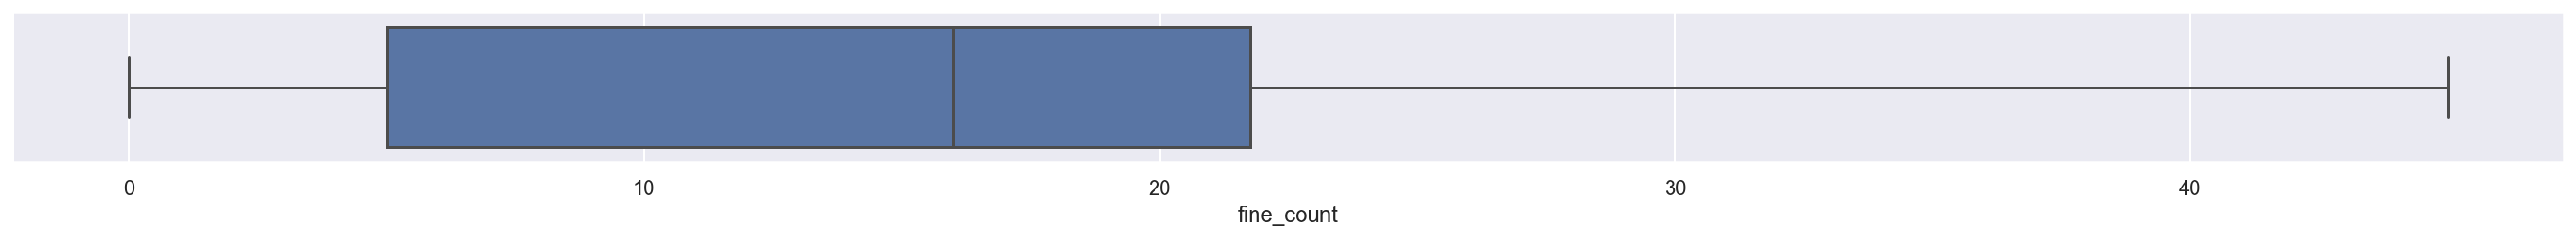

In [ ]:
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten_adjusted, x="fine_count");

#### Check Correlation "Outliers" Removed

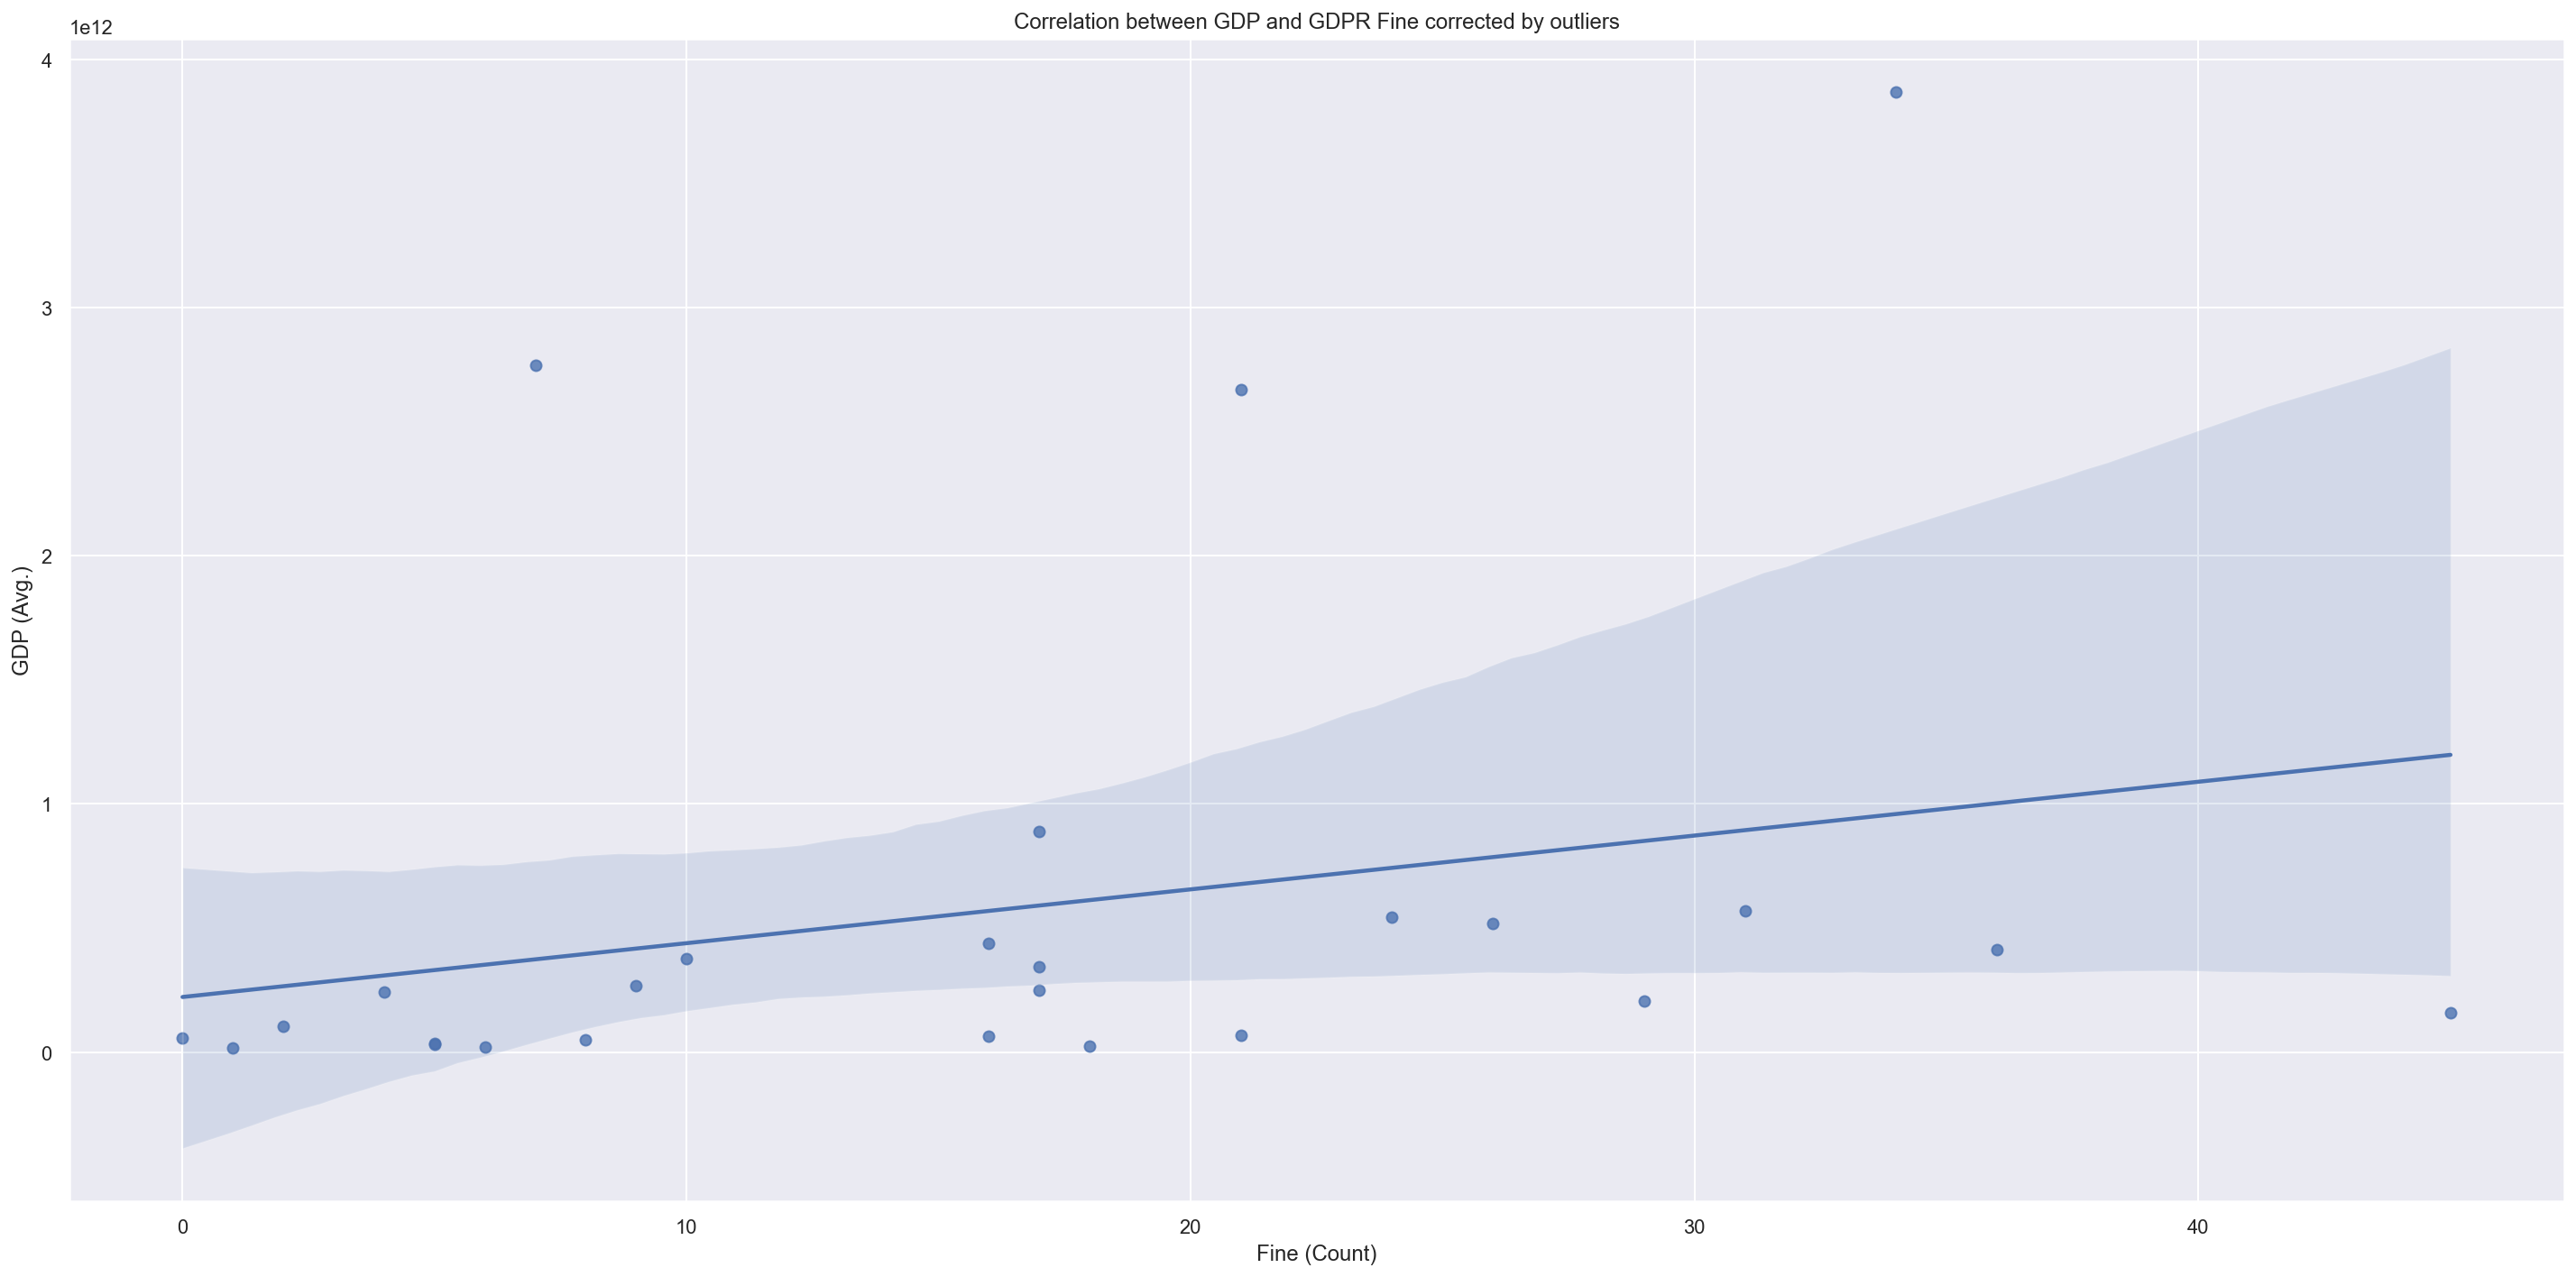

In [ ]:
plt.figure(figsize=(20, 10))
chart = sns.regplot(data=df_ada_grouped_flatten_adjusted, x="fine_count", y="gdp_mean");
chart.set(title='Correlation between GDP and GDPR Fine corrected by outliers', xlabel='Fine (Count)', ylabel="GDP (Avg.)");

In [ ]:
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_ada_grouped_flatten_adjusted.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

#### **Conclusion**

...

### **A higher CPI could lead to more reported cases**
because the public sector is potentially less influenced (corrupted) by the companies


#### Prepare Dataframe

**What Is the Corruption Perceptions Index (CPI)?**
The term Corruption Perceptions Index (CPI) refers to an index that scores countries on the perceived levels of government corruption by country. Scores range from zero to 100, with **zero indicating high levels of corruption and 100 indicating low levels**. The CPI is published annually by Transparency International, an organization that seeks to stop bribery, fraud, and other forms of public sector corruption.

https://www.investopedia.com/terms/c/corruption-perception-index.asp

In [ ]:
df_ada_grouped = df.groupby(['country','iso3'])['fine','gdp','cpi_score','population'].agg({'fine':['sum','count','mean'],'gdp':'mean','cpi_score':'mean','population':'mean'}).reset_index()
#df_ada_grouped

In [ ]:
# flatten grouped dataframe
df_ada_grouped_flatten = df_ada_grouped.copy()
df_ada_grouped_flatten.columns = ['_'.join(i).rstrip('_') for i in df_ada_grouped_flatten.columns.values]
df_ada_grouped_flatten

country iso3      fine_sum  fine_count            fine_mean  \
0           AUSTRIA  AUT  16,774,550.0          16        1,048,409.375   
1           BELGIUM  BEL   1,033,000.0          26  39,730.769230769234   
2          BULGARIA  BGR   3,211,070.0          21  152,908.09523809524   
3           CROATIA  HRV           0.0           0                  NaN   
4            CYPRUS  CYP   1,248,000.0          18   69,333.33333333333   
5    CZECH REPUBLIC  CZE     165,903.0          17              9,759.0   
6           DENMARK  DNK     856,600.0          17   50,388.23529411765   
7           ESTONIA  EST     300,548.0           5             60,109.6   
8           FINLAND  FIN     924,000.0           9  102,666.66666666667   
9            FRANCE  FRA  58,194,300.0          21 2,771,157.1428571427   
10          GERMANY  DEU  50,159,583.0          34 1,475,281.8529411764   
11           GREECE  GRC     974,000.0          29  33,586.206896551725   
12          HUNGARY  HUN     828,183.0          45  18,404.066666666666   
13          ICELAND  ISL     164,900.0           6  27,483.333333333332   
14          IRELAND  IRL 225,877,900.0          10         22,587,790.0   
15      ISLE OF MAN  IMN      16,750.0           2              8,375.0   
16            ITALY  ITA  89,804,096.0         103    871,884.427184466   
17           LATVIA  LVA     243,250.0           5             48,650.0   
18    LIECHTENSTEIN  LIE       4,100.0           1              4,100.0   
19        LITHUANIA  LTU     244,500.0           8             30,562.5   
20       LUXEMBOURG  LUX 746,257,900.0          16        46,641,118.75   
21            MALTA  MLT       5,000.0           1              5,000.0   
22           NORWAY  NOR   8,993,550.0          36  249,820.83333333334   
23           POLAND  POL   2,199,948.0          31   70,966.06451612903   
24         PORTUGAL  PRT     424,000.0           4            106,000.0   
25          ROMANIA  ROU     726,950.0          69  10,535.507246376812   
26         SLOVAKIA  SVK      90,000.0           2             45,000.0   
27            SPAIN  ESP  36,744,810.0         352  104,388.66477272728   
28           SWEDEN  SWE  15,331,730.0          24   638,822.0833333334   
29  THE NETHERLANDS  NLD   9,914,500.0          17   583,205.8823529412   
30   UNITED KINGDOM  GBR  44,846,800.0           7  6,406,685.714285715   

                 gdp_mean     cpi_score_mean      population_mean  
0      436,554,886,196.75            75.4375         8,993,160.75  
1   518,081,667,022.38464  75.76923076923077 11,592,162.384615384  
2    68,111,987,553.90476 43.095238095238095   6,987,924.80952381  
3       56,251,429,631.25              47.75          4,086,475.0  
4    23,986,520,238.61111               58.5  1,208,123.111111111  
5       247,337,324,518.4               55.0        10,700,205.92  
6    344,299,866,937.4706  88.52941176470588  5,803,315.764705882  
7        30,650,285,472.0               75.0          1,326,535.0  
8   265,825,597,718.44446  86.33333333333333          5,546,052.0  
9  2,670,778,673,738.5713  69.47619047619048 65,317,999.333333336  
10 3,868,062,946,294.3423               80.0  83,599,261.10526316  
11  204,764,699,732.48276   46.3448275862069 10,405,975.551724138  
12  157,107,840,776.66666  44.82222222222222  9,669,120.355555555  
13  20,915,341,869.666668               77.0   342,738.3333333333  
14   376,596,068,105.1818  72.45454545454545  4,964,670.090909091  
15                    NaN                NaN             85,033.0  
16 1,953,969,083,381.7087 49.737864077669904   60,451,743.0776699  
17       33,195,954,342.4               56.2          1,890,108.4  
18                    NaN                NaN             38,128.0  
19     50,960,568,928.875              58.75        2,701,903.125  
20       64,692,749,785.0               81.0            638,549.0  
21       15,215,714,309.0               54.0            440,372.0  
22  413,819,610,485.14636  84.70731707317073  5

#### Check Distributions - "Outliers" Included

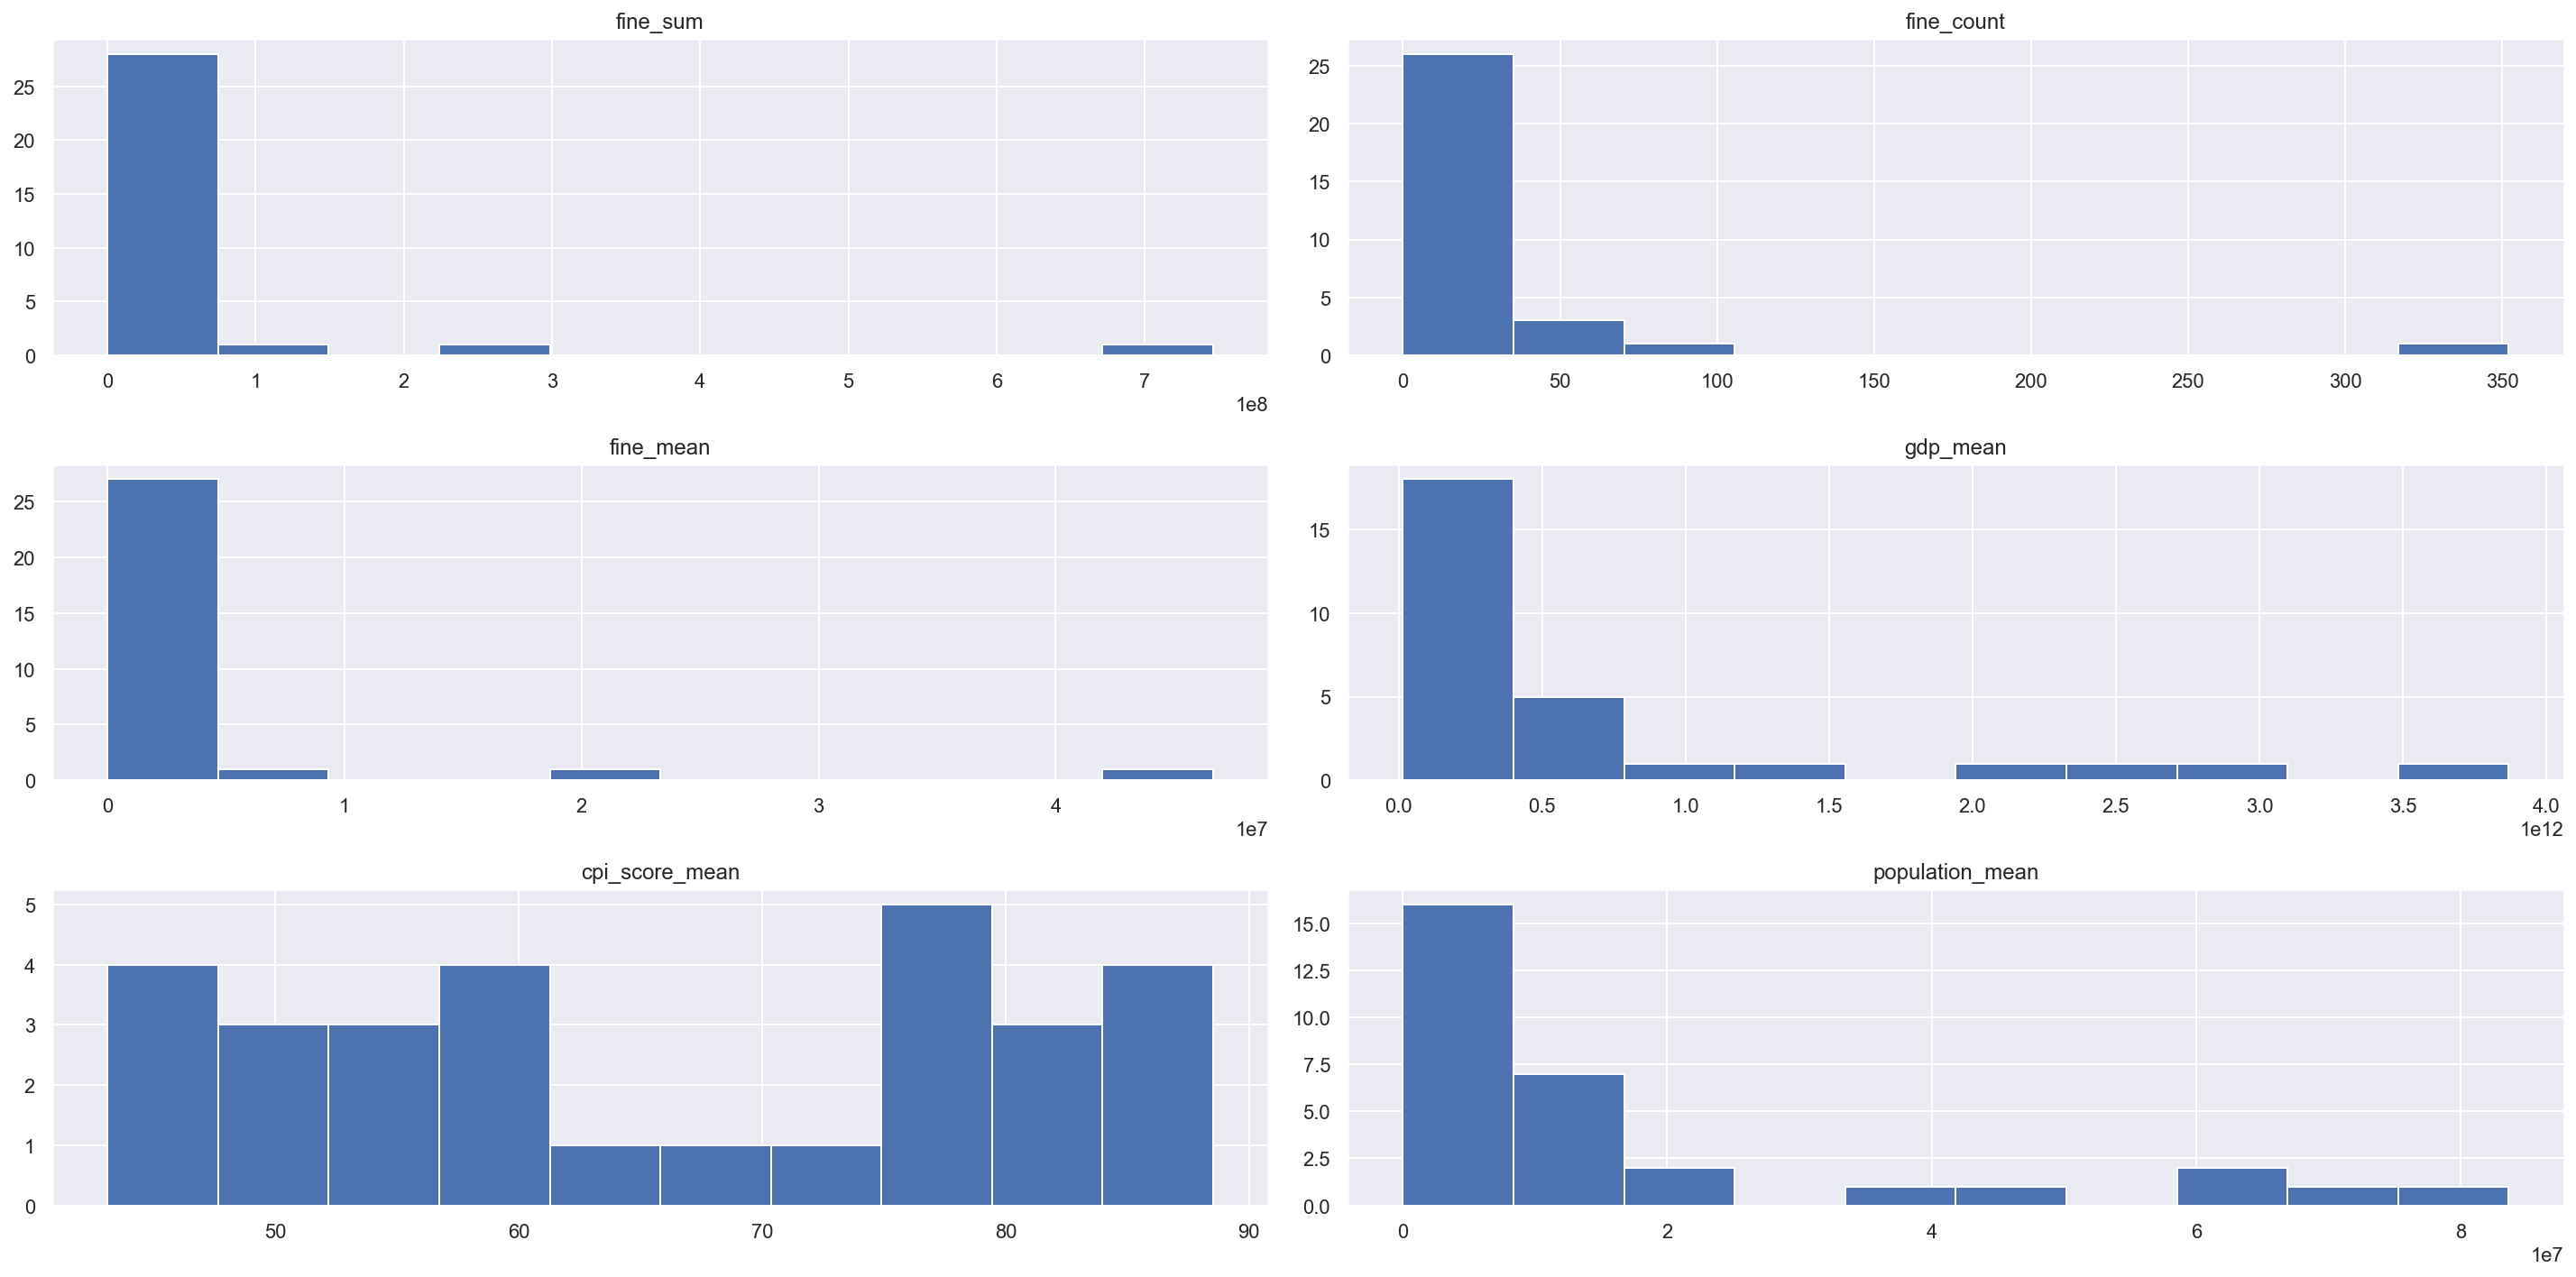

In [ ]:
# Check distribution
sns.set(rc={"figure.figsize":(20, 10)})
df_ada_grouped_flatten.hist();

#### Check Correlations - "Outliers" Included

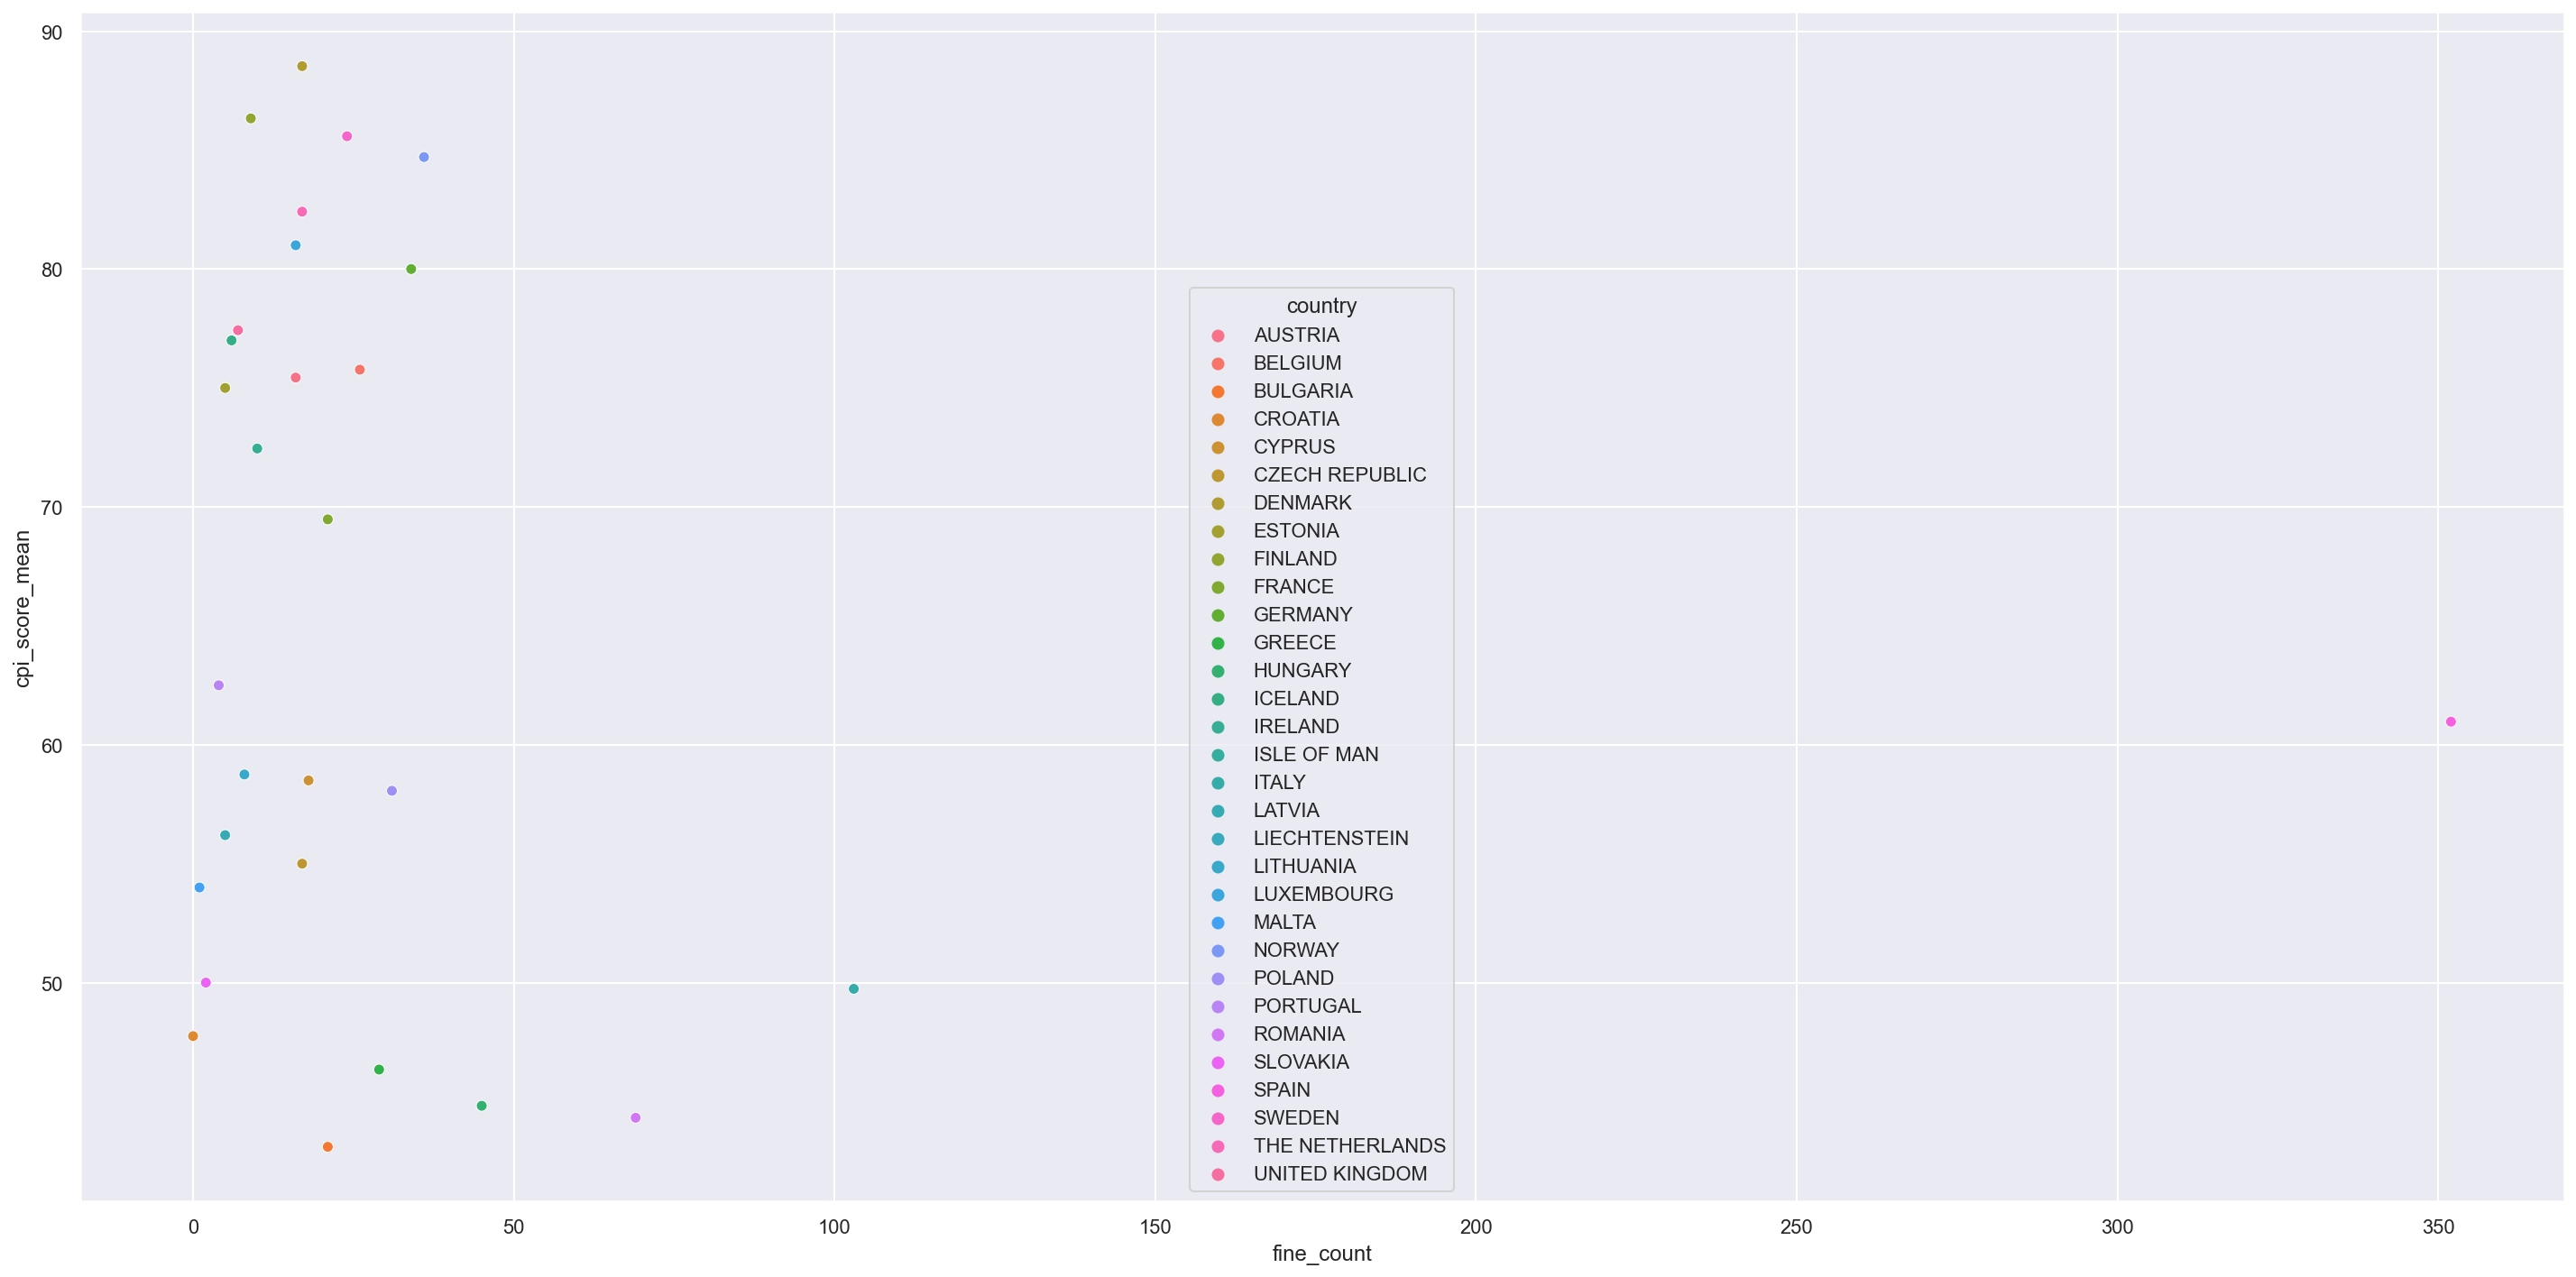

In [ ]:
# Checking correlation with "outliers"
sns.set(rc={"figure.figsize":(20, 10)})
sns.scatterplot(data=df_ada_grouped_flatten, x="fine_count", y="cpi_score_mean", hue="country",);

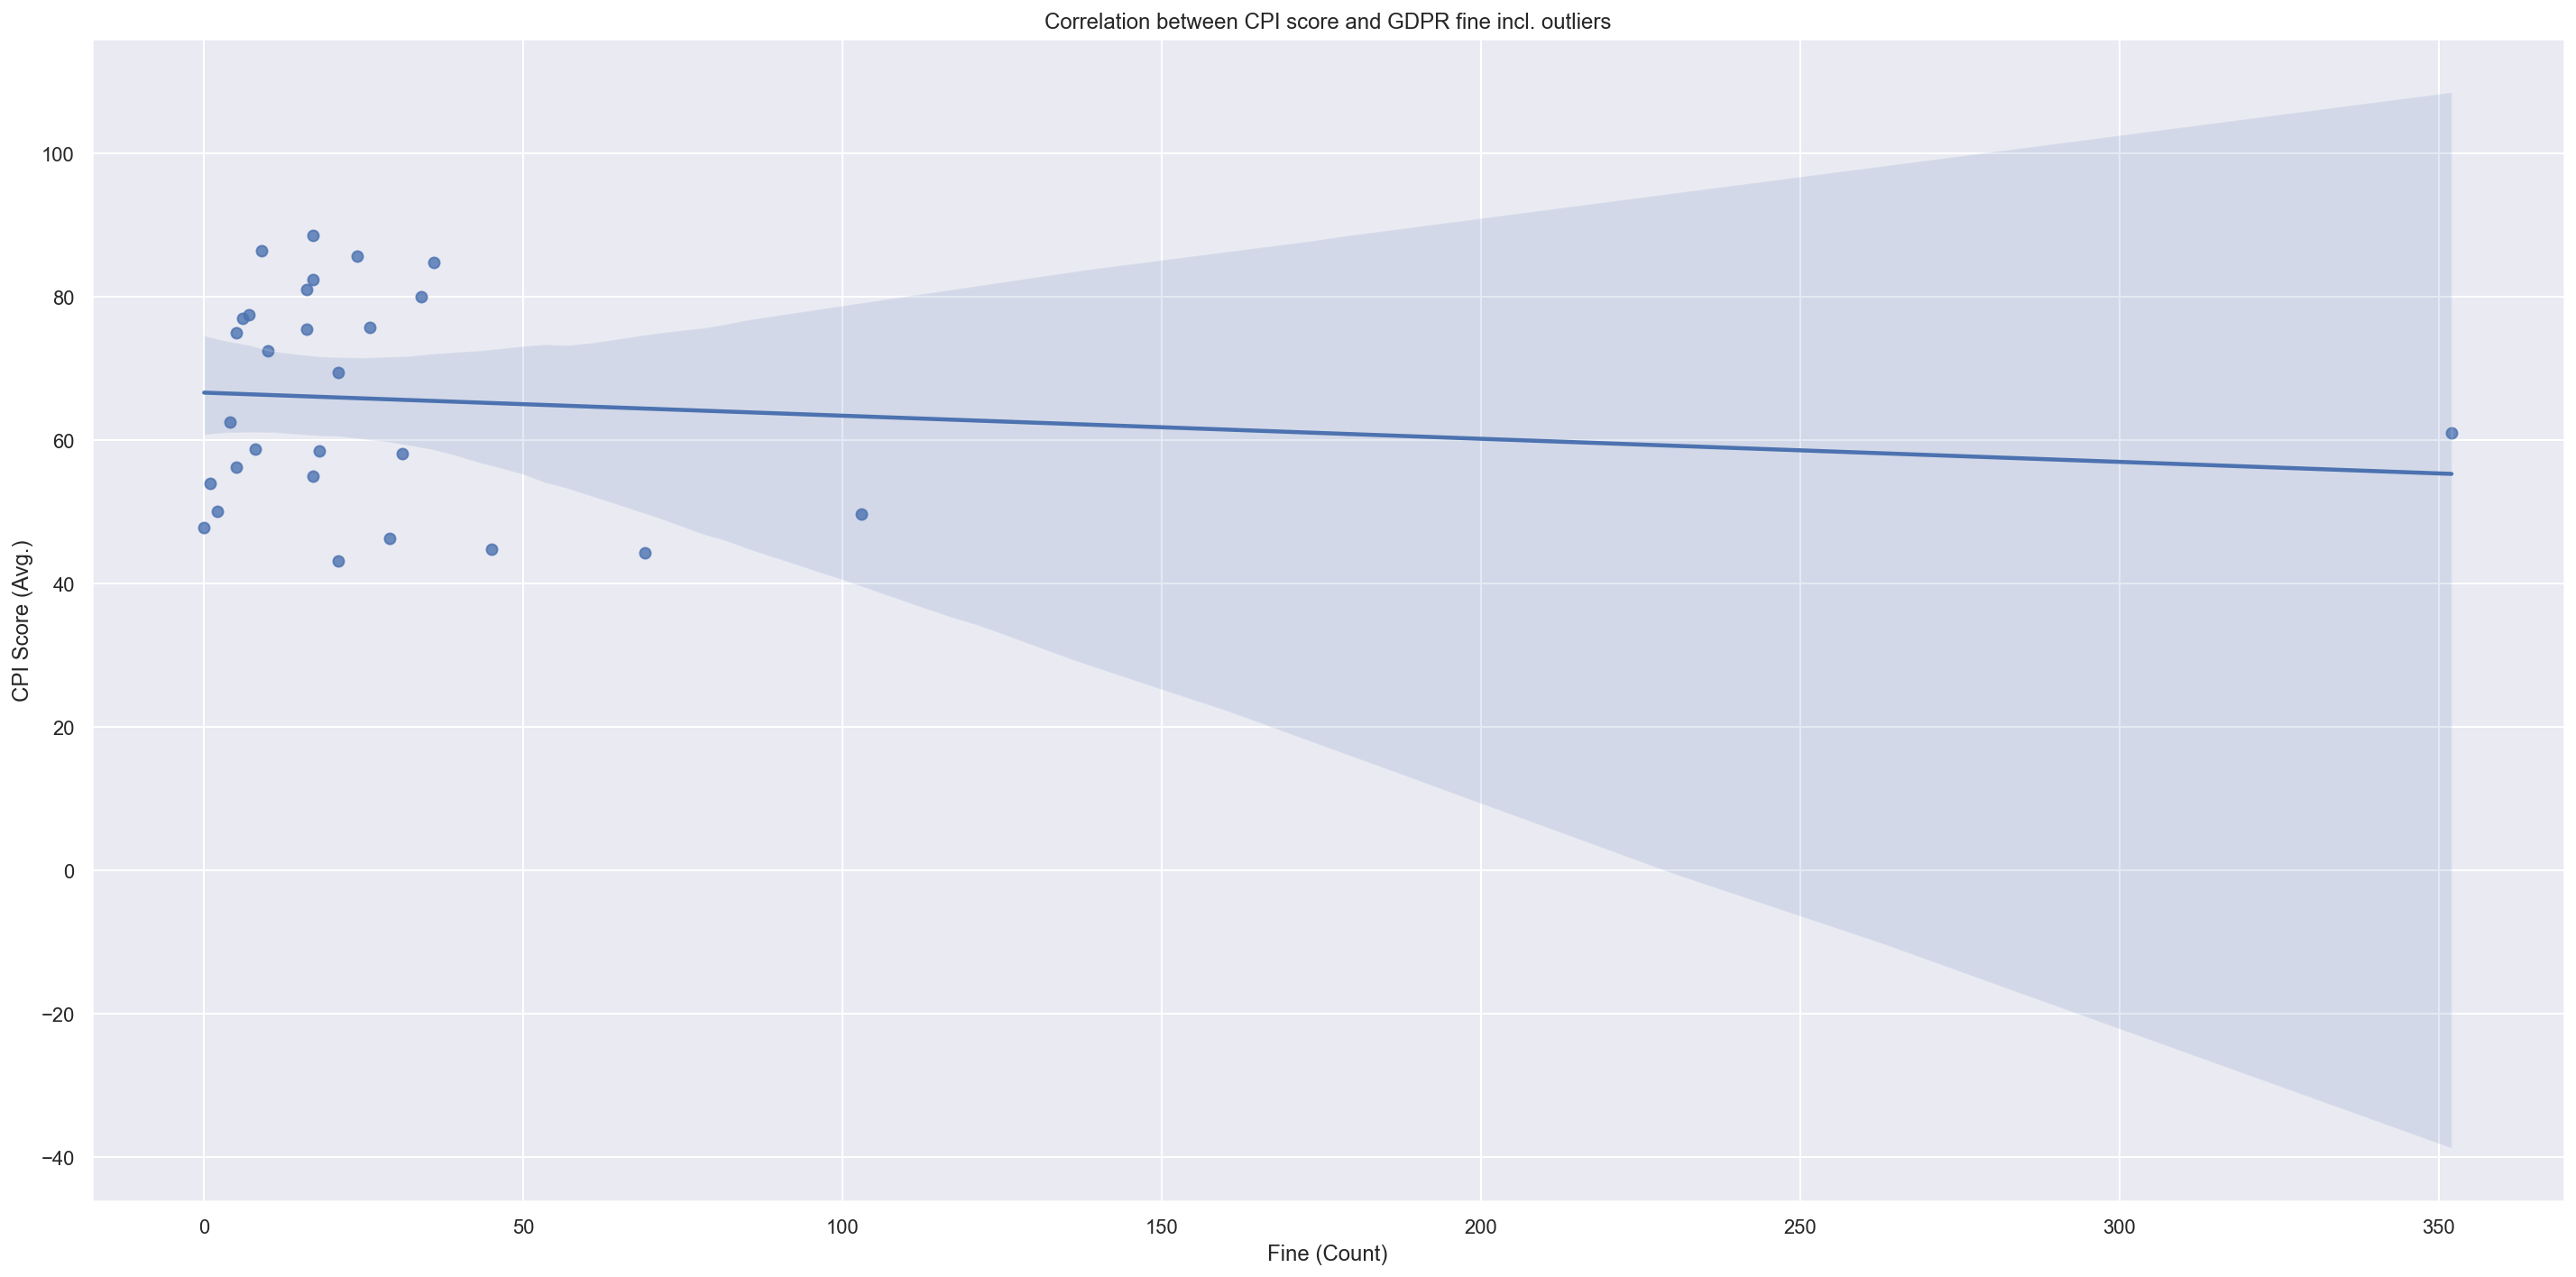

In [ ]:
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_ada_grouped_flatten, x="fine_count", y="cpi_score_mean");
chart.set(title='Correlation between CPI score and GDPR fine incl. outliers', xlabel='Fine (Count)', ylabel="CPI Score (Avg.)");

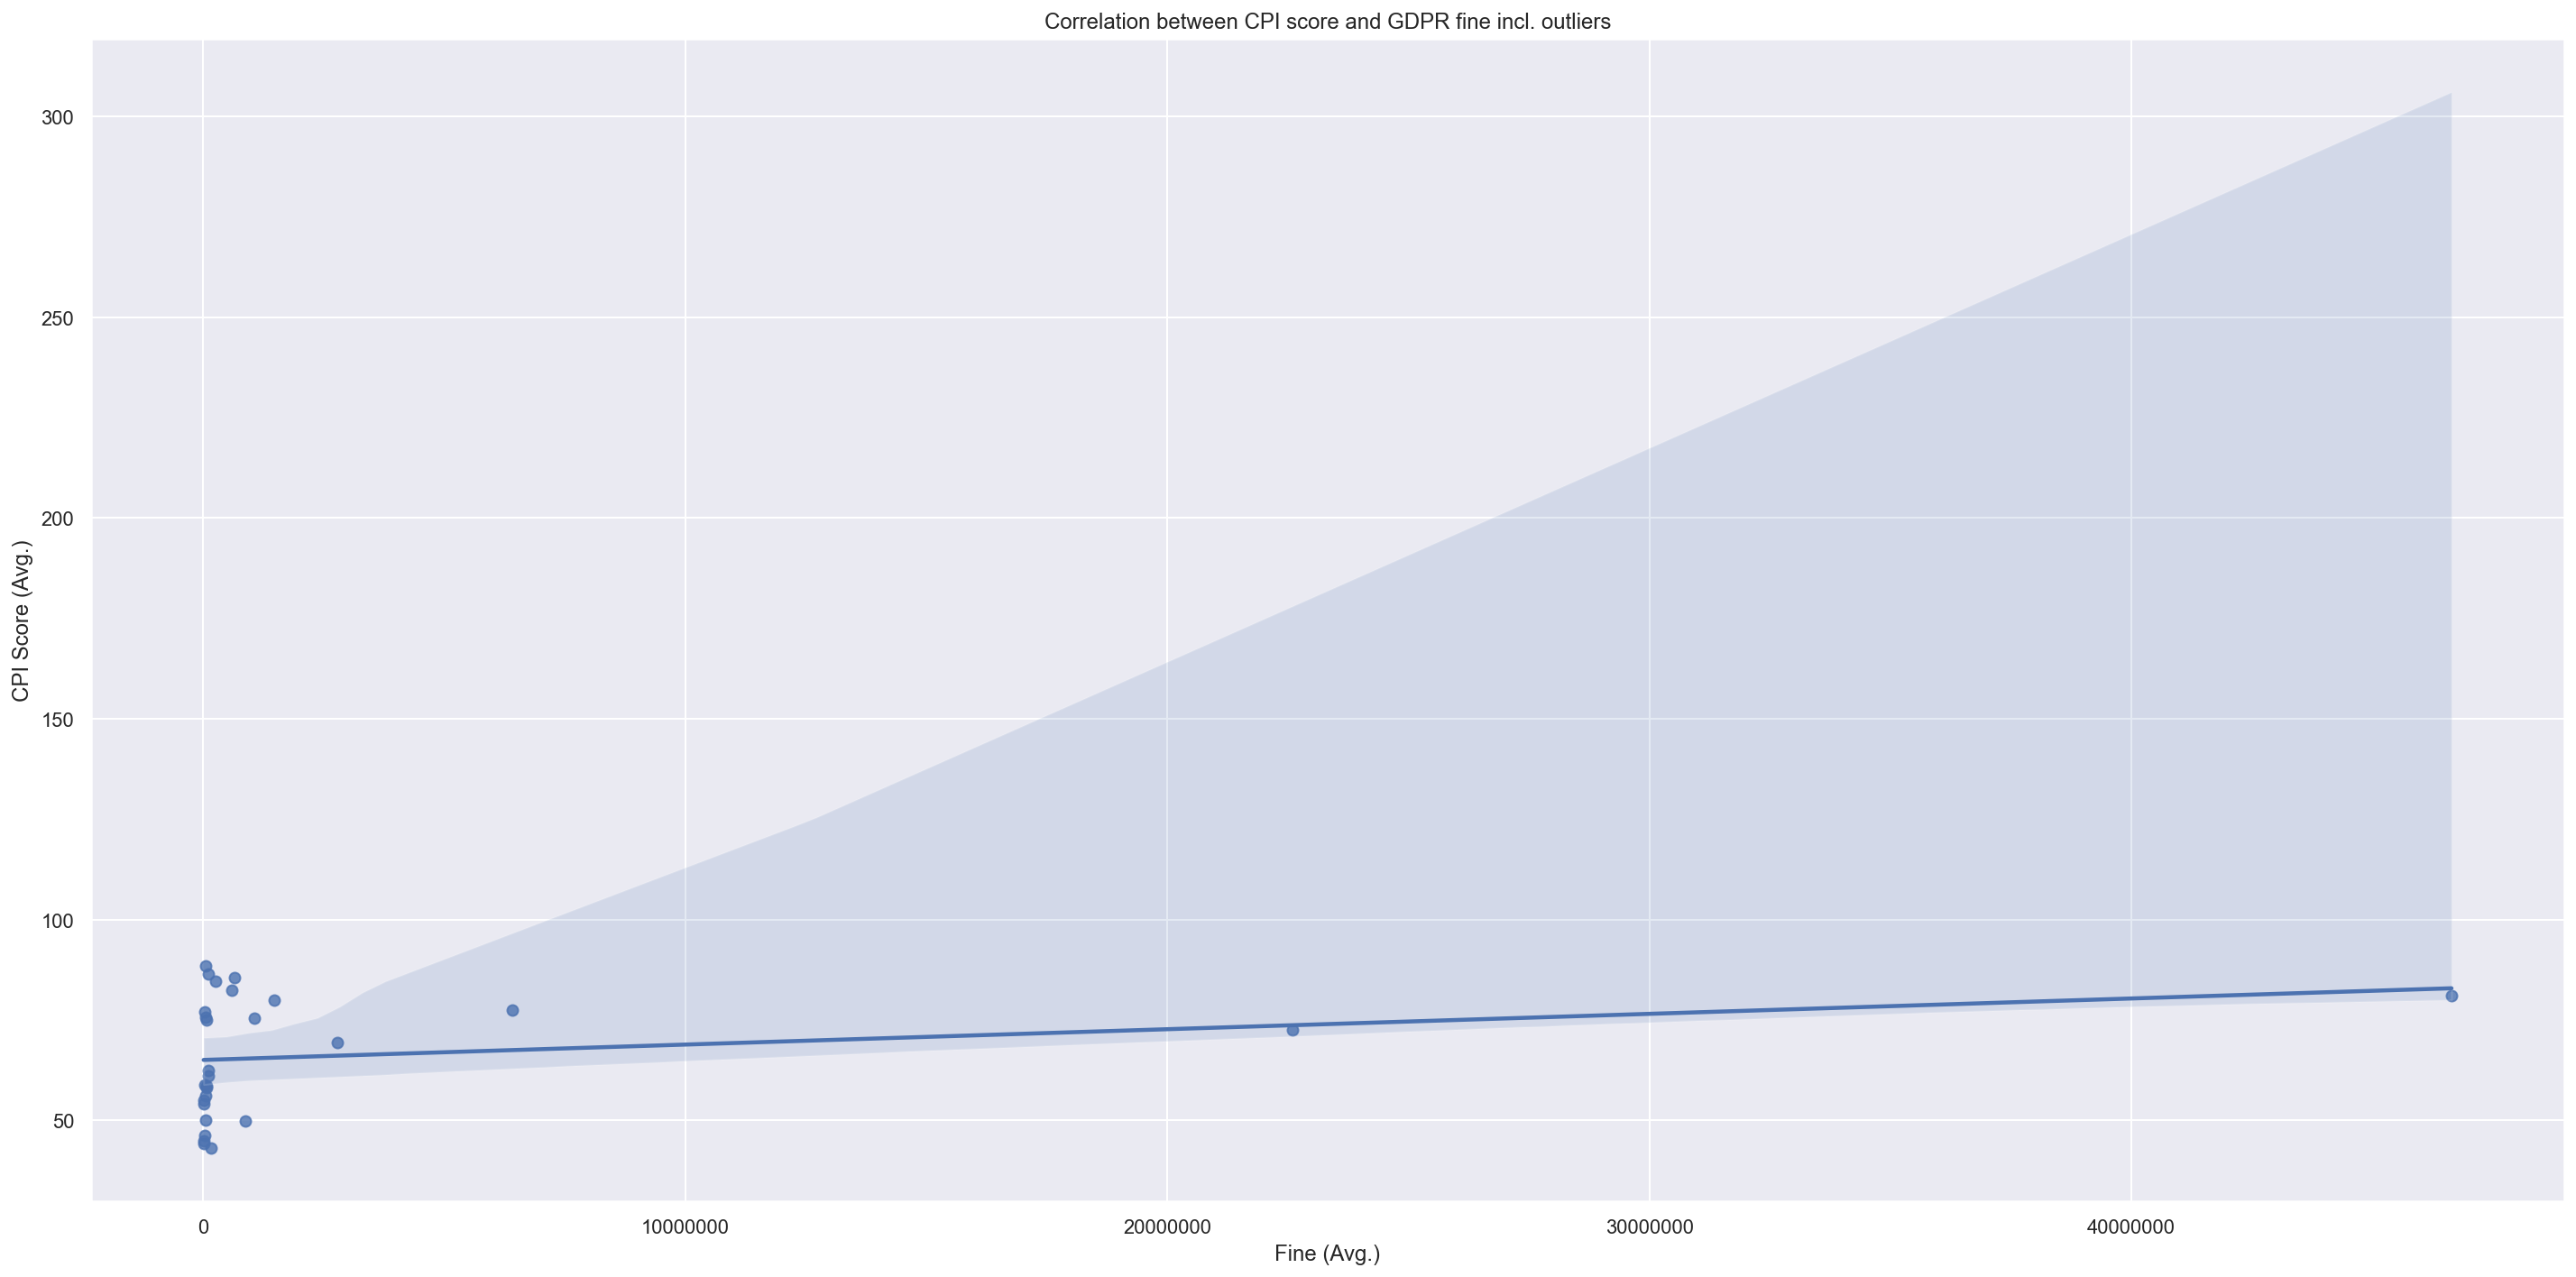

In [ ]:
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_ada_grouped_flatten, x="fine_mean", y="cpi_score_mean");
chart.set(title='Correlation between CPI score and GDPR fine incl. outliers', xlabel='Fine (Avg.)', ylabel="CPI Score (Avg.)");

In [ ]:
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_ada_grouped_flatten.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

#### Identify and Address "Outliers"

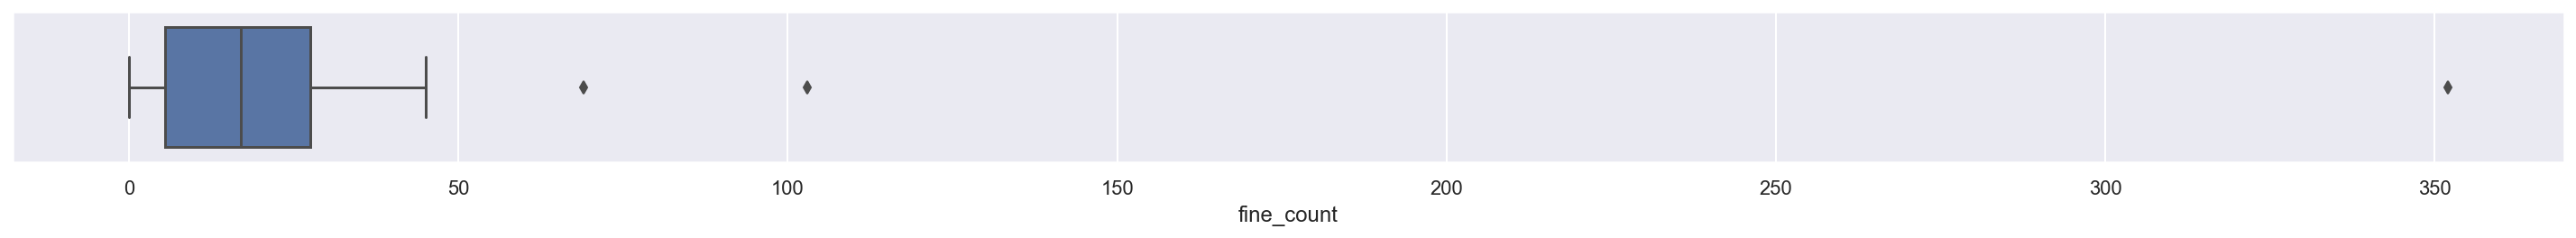

In [ ]:
# Identify and remove fine_count "outlier"
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten, x="fine_count");

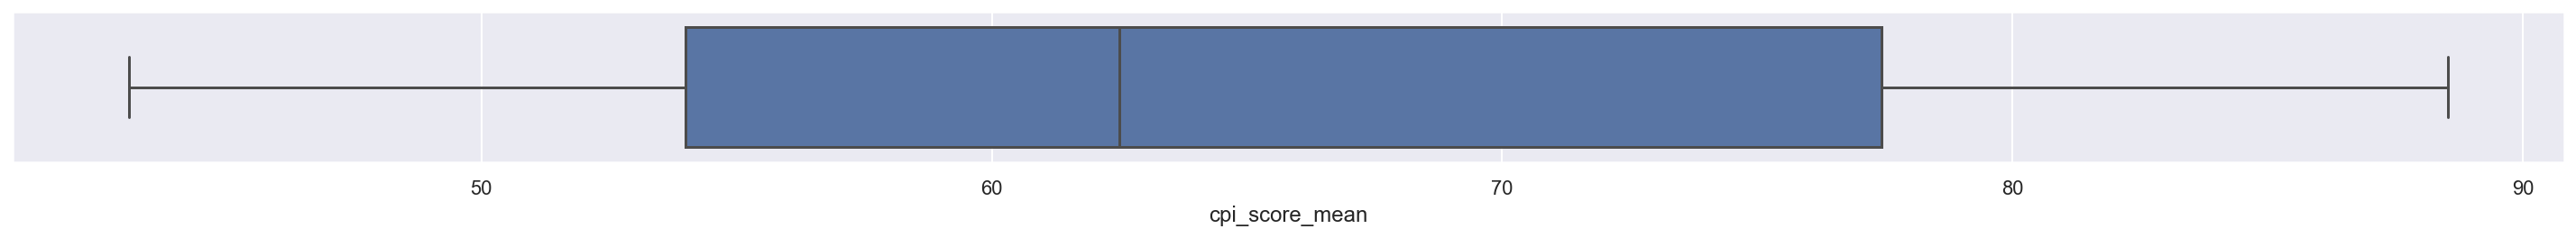

In [ ]:
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten, x="cpi_score_mean");

In [ ]:
# Remove fine_count "outliers"
df_ada_grouped_flatten_adjusted = df_ada_grouped_flatten[df_ada_grouped_flatten['fine_count'] < 50]

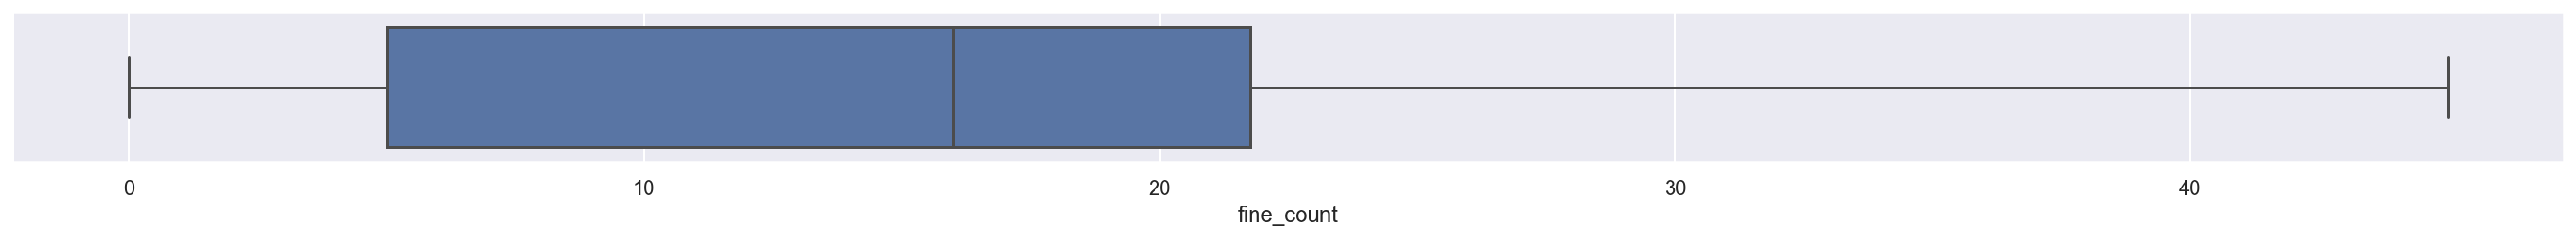

In [ ]:
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten_adjusted, x="fine_count");

#### Check Correlations - "Outliers" Removed


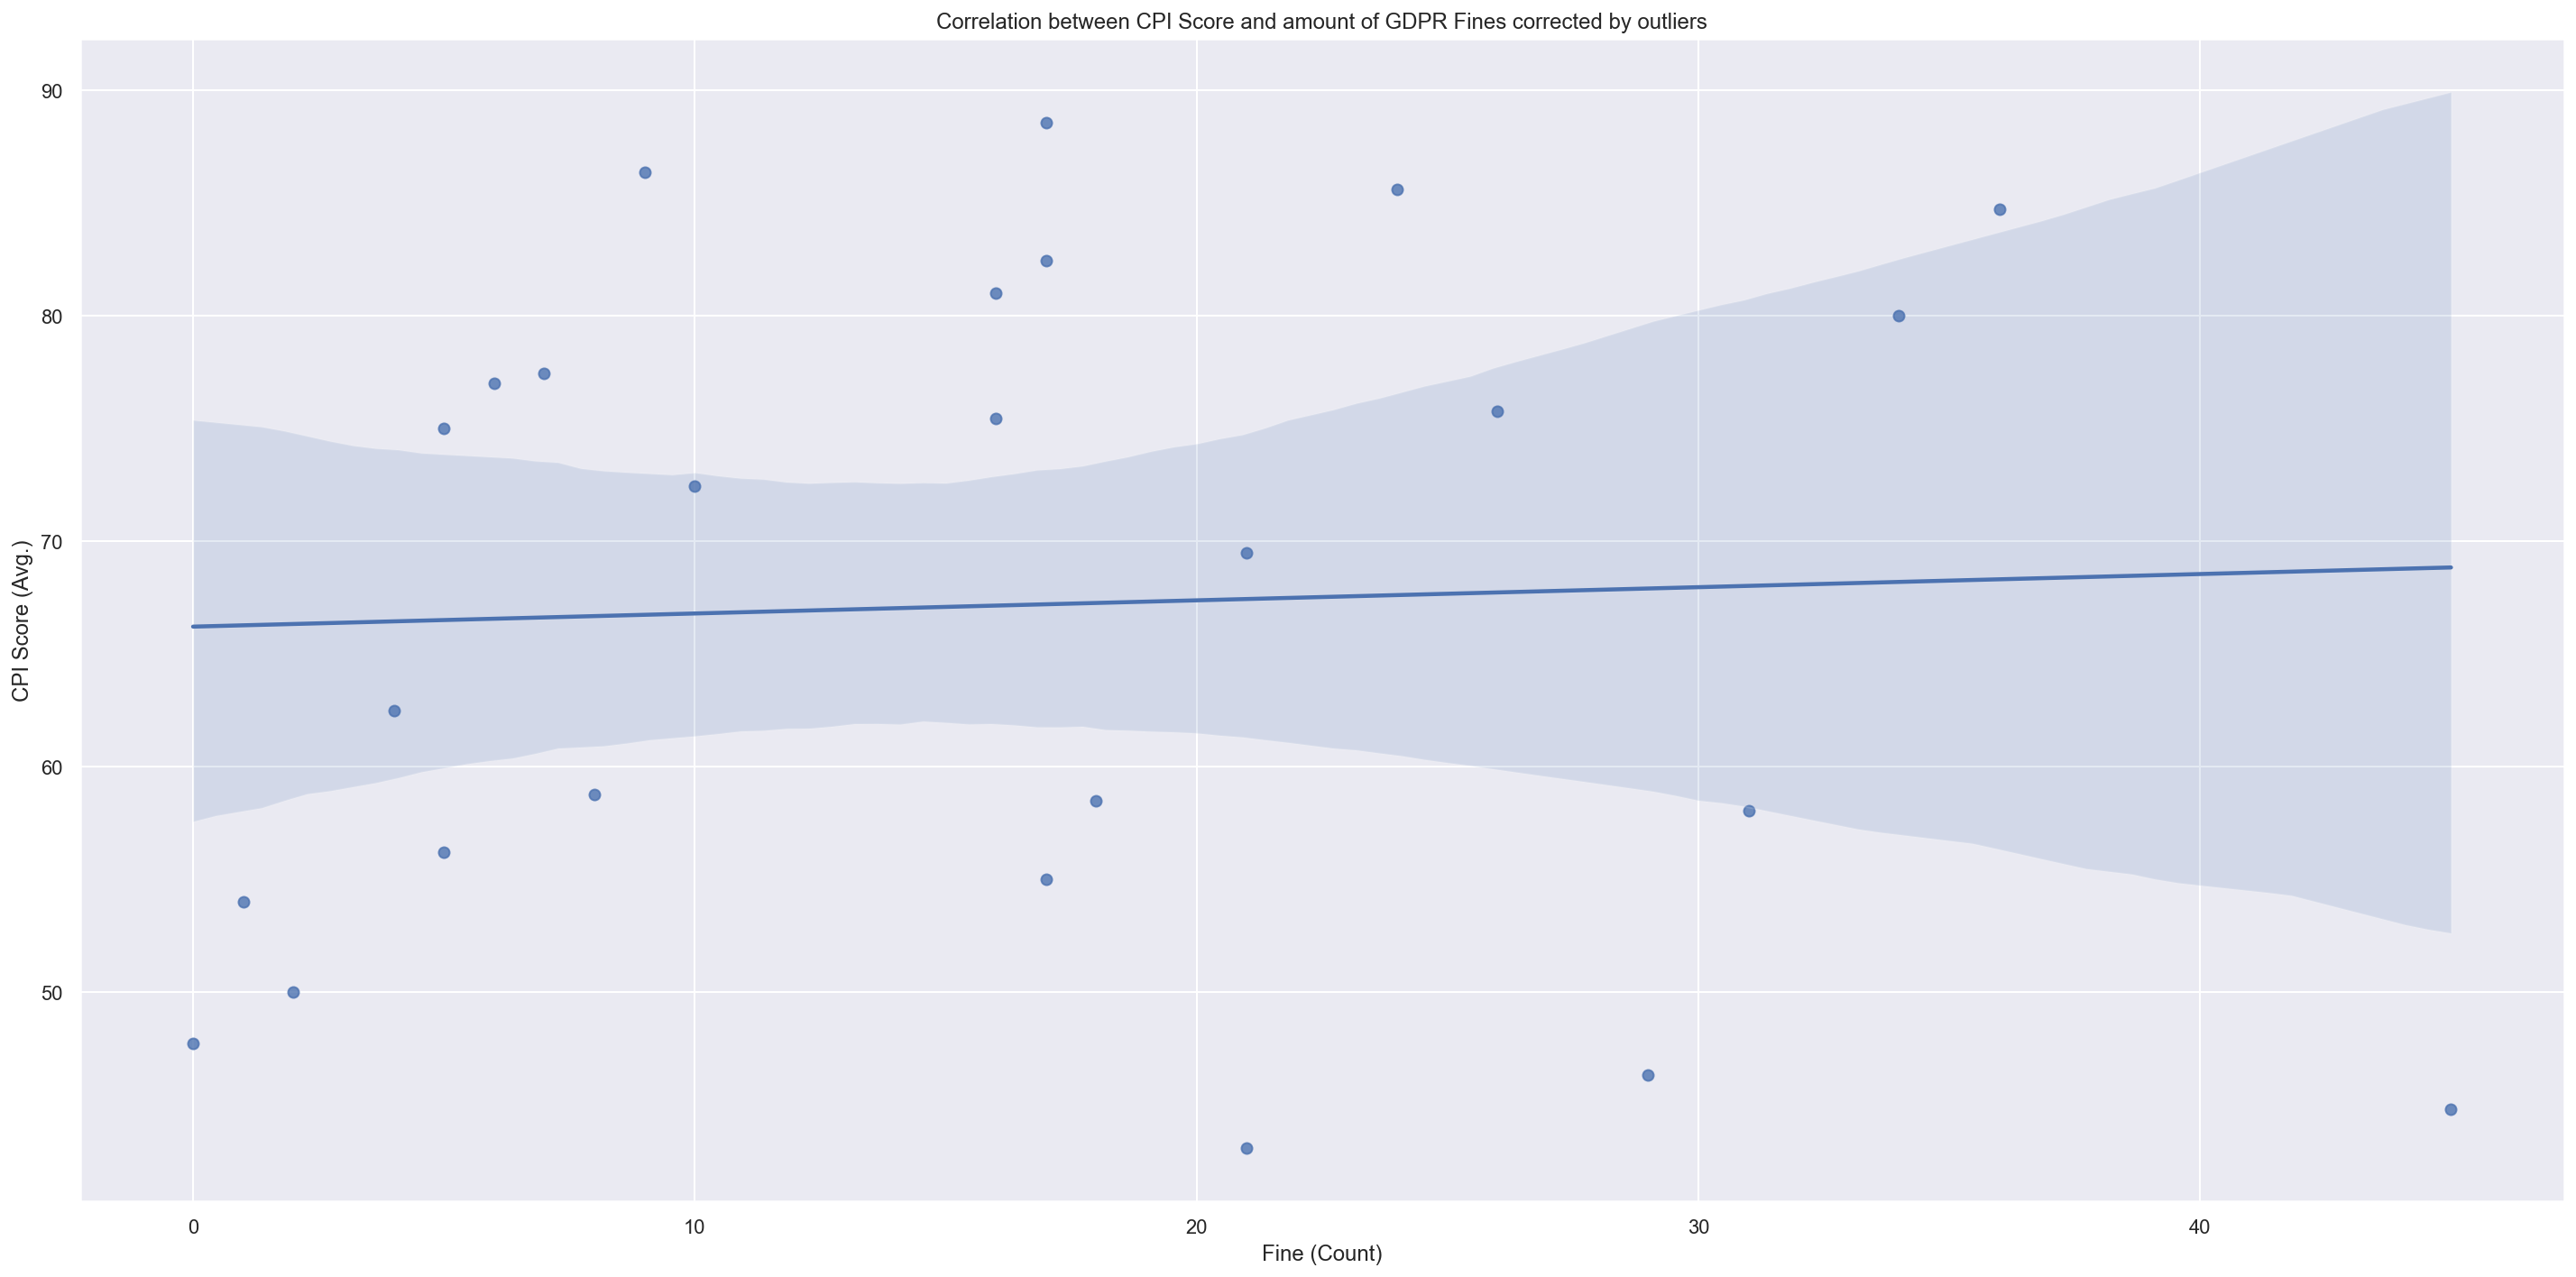

In [ ]:
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_ada_grouped_flatten_adjusted, x="fine_count", y="cpi_score_mean");
chart.set(title='Correlation between CPI Score and amount of GDPR Fines corrected by outliers', xlabel='Fine (Count)', ylabel="CPI Score (Avg.)");

In [ ]:
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_ada_grouped_flatten_adjusted.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

#### **Conclusion**

### **A higher population could lead to more reported cases**
because more data subjects could execute their rights

#### Prepare Dataframe

In [ ]:
df_ada_grouped = (
    df.groupby(["country", "iso3"])["fine", "gdp", "cpi_score", "population"]
    .agg(
        {
            "fine": ["sum", "count", "mean"],
            "gdp": ["mean"],
            "cpi_score": ["mean"],
            "population": ["mean"],
        }
    )
    .reset_index()
)
# df_ada_grouped



In [ ]:
# flatten grouped dataframe
df_ada_grouped_flatten = df_ada_grouped.copy()
df_ada_grouped_flatten.columns = [
    "_".join(i).rstrip("_") for i in df_ada_grouped_flatten.columns.values
]
df_ada_grouped_flatten.round(0)


country iso3      fine_sum  fine_count    fine_mean  \
0           AUSTRIA  AUT  16,774,550.0          16  1,048,409.0   
1           BELGIUM  BEL   1,033,000.0          26     39,731.0   
2          BULGARIA  BGR   3,211,070.0          21    152,908.0   
3           CROATIA  HRV           0.0           0          NaN   
4            CYPRUS  CYP   1,248,000.0          18     69,333.0   
5    CZECH REPUBLIC  CZE     165,903.0          17      9,759.0   
6           DENMARK  DNK     856,600.0          17     50,388.0   
7           ESTONIA  EST     300,548.0           5     60,110.0   
8           FINLAND  FIN     924,000.0           9    102,667.0   
9            FRANCE  FRA  58,194,300.0          21  2,771,157.0   
10          GERMANY  DEU  50,159,583.0          34  1,475,282.0   
11           GREECE  GRC     974,000.0          29     33,586.0   
12          HUNGARY  HUN     828,183.0          45     18,404.0   
13          ICELAND  ISL     164,900.0           6     27,483.0   
14          IRELAND  IRL 225,877,900.0          10 22,587,790.0   
15      ISLE OF MAN  IMN      16,750.0           2      8,375.0   
16            ITALY  ITA  89,804,096.0         103    871,884.0   
17           LATVIA  LVA     243,250.0           5     48,650.0   
18    LIECHTENSTEIN  LIE       4,100.0           1      4,100.0   
19        LITHUANIA  LTU     244,500.0           8     30,562.0   
20       LUXEMBOURG  LUX 746,257,900.0          16 46,641,119.0   
21            MALTA  MLT       5,000.0           1      5,000.0   
22           NORWAY  NOR   8,993,550.0          36    249,821.0   
23           POLAND  POL   2,199,948.0          31     70,966.0   
24         PORTUGAL  PRT     424,000.0           4    106,000.0   
25          ROMANIA  ROU     726,950.0          69     10,536.0   
26         SLOVAKIA  SVK      90,000.0           2     45,000.0   
27            SPAIN  ESP  36,744,810.0         352    104,389.0   
28           SWEDEN  SWE  15,331,730.0          24    638,822.0   
29  THE NETHERLANDS  NLD   9,914,500.0          17    583,206.0   
30   UNITED KINGDOM  GBR  44,846,800.0           7  6,406,686.0   

              gdp_mean  cpi_score_mean  population_mean  
0    436,554,886,197.0            75.0      8,993,161.0  
1    518,081,667,022.0            76.0     11,592,162.0  
2     68,111,987,554.0            43.0      6,987,925.0  
3     56,251,429,631.0            48.0      4,086,475.0  
4     23,986,520,239.0            58.0      1,208,123.0  
5    247,337,324,518.0            55.0     10,700,206.0  
6    344,299,866,937.0            89.0      5,803,316.0  
7     30,650,285,472.0            75.0      1,326,535.0  
8    265,825,597,718.0            86.0      5,546,052.0  
9  2,670,778,673,739.0            69.0     65,317,999.0  
10 3,868,062,946,294.0            80.0     83,599,261.0  
11   204,764,699,732.0            46.0     10,405,976.0  
12   157,107,840,777.0            45.0      9,669,120.0  
13    20,915,341,870.0            77.0        342,738.0  
14   376,596,068,105.0            72.0      4,964,670.0  
15                 NaN             NaN         85,033.0  
16 1,953,969,083,382.0            50.0     60,451,743.0  
17    33,195,954,342.0            56.0      1,890,108.0  
18                 NaN             NaN         38,128.0  
19    50,960,568,929.0            59.0      2,701,903.0  
20    64,692,749,785.0            81.0        638,549.0  
21    15,215,714,309.0            54.0        440,372.0  
22   413,819,610,485.0            85.0      5,451,286.0  
23   569,747,631,568.0            58.0     37,838,900.0  
24   240,181,775,344.0            62.0     10,233,688.0  
25   236,274,041,231.0            44.0     19,233,379.0  
26   105,119,160,234.0            50.0      5,457,013.0  
27 1,313,350,111,812.0            61.0     46,761,369.0  
28   541,887,384,392.0            86.0     10,113,923.0  
29   890,357,644,566.0            82.0     17,144,496.0  
30 2,766,634,009,222.0            77.0     68,012,005.0

#### Check Distributions - "Outliers" Included

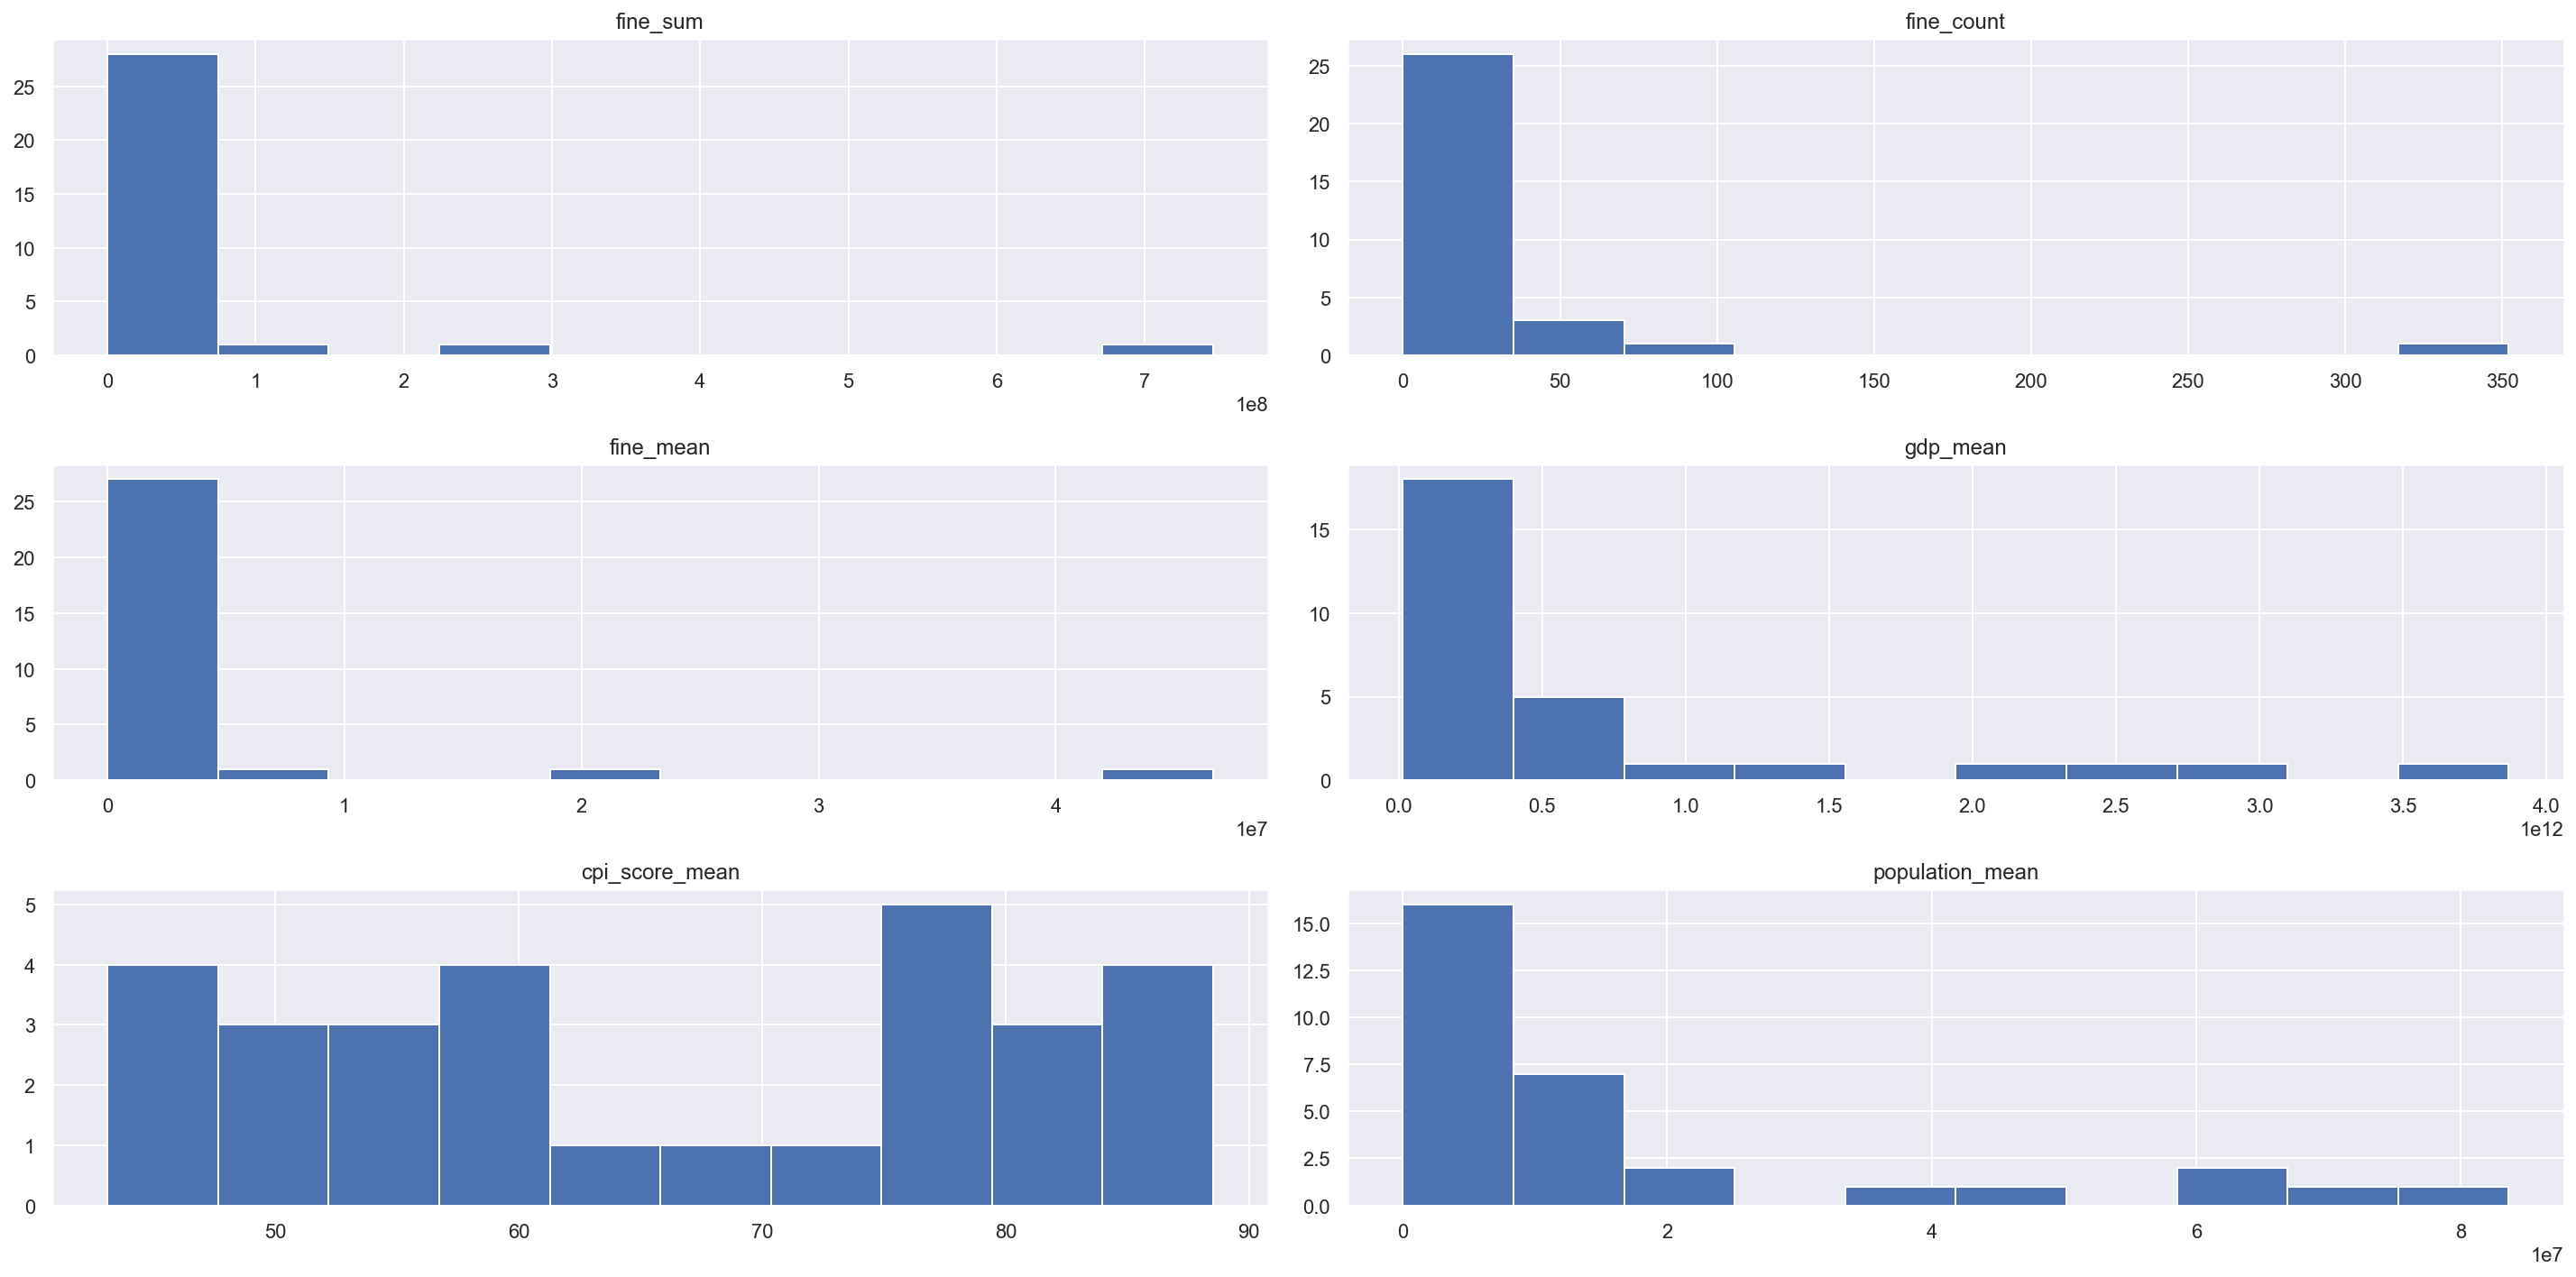

In [ ]:
# Check distribution
sns.set(rc={"figure.figsize":(20, 10)})
df_ada_grouped_flatten.hist();

#### Check Correlation - "Outliers" Included 

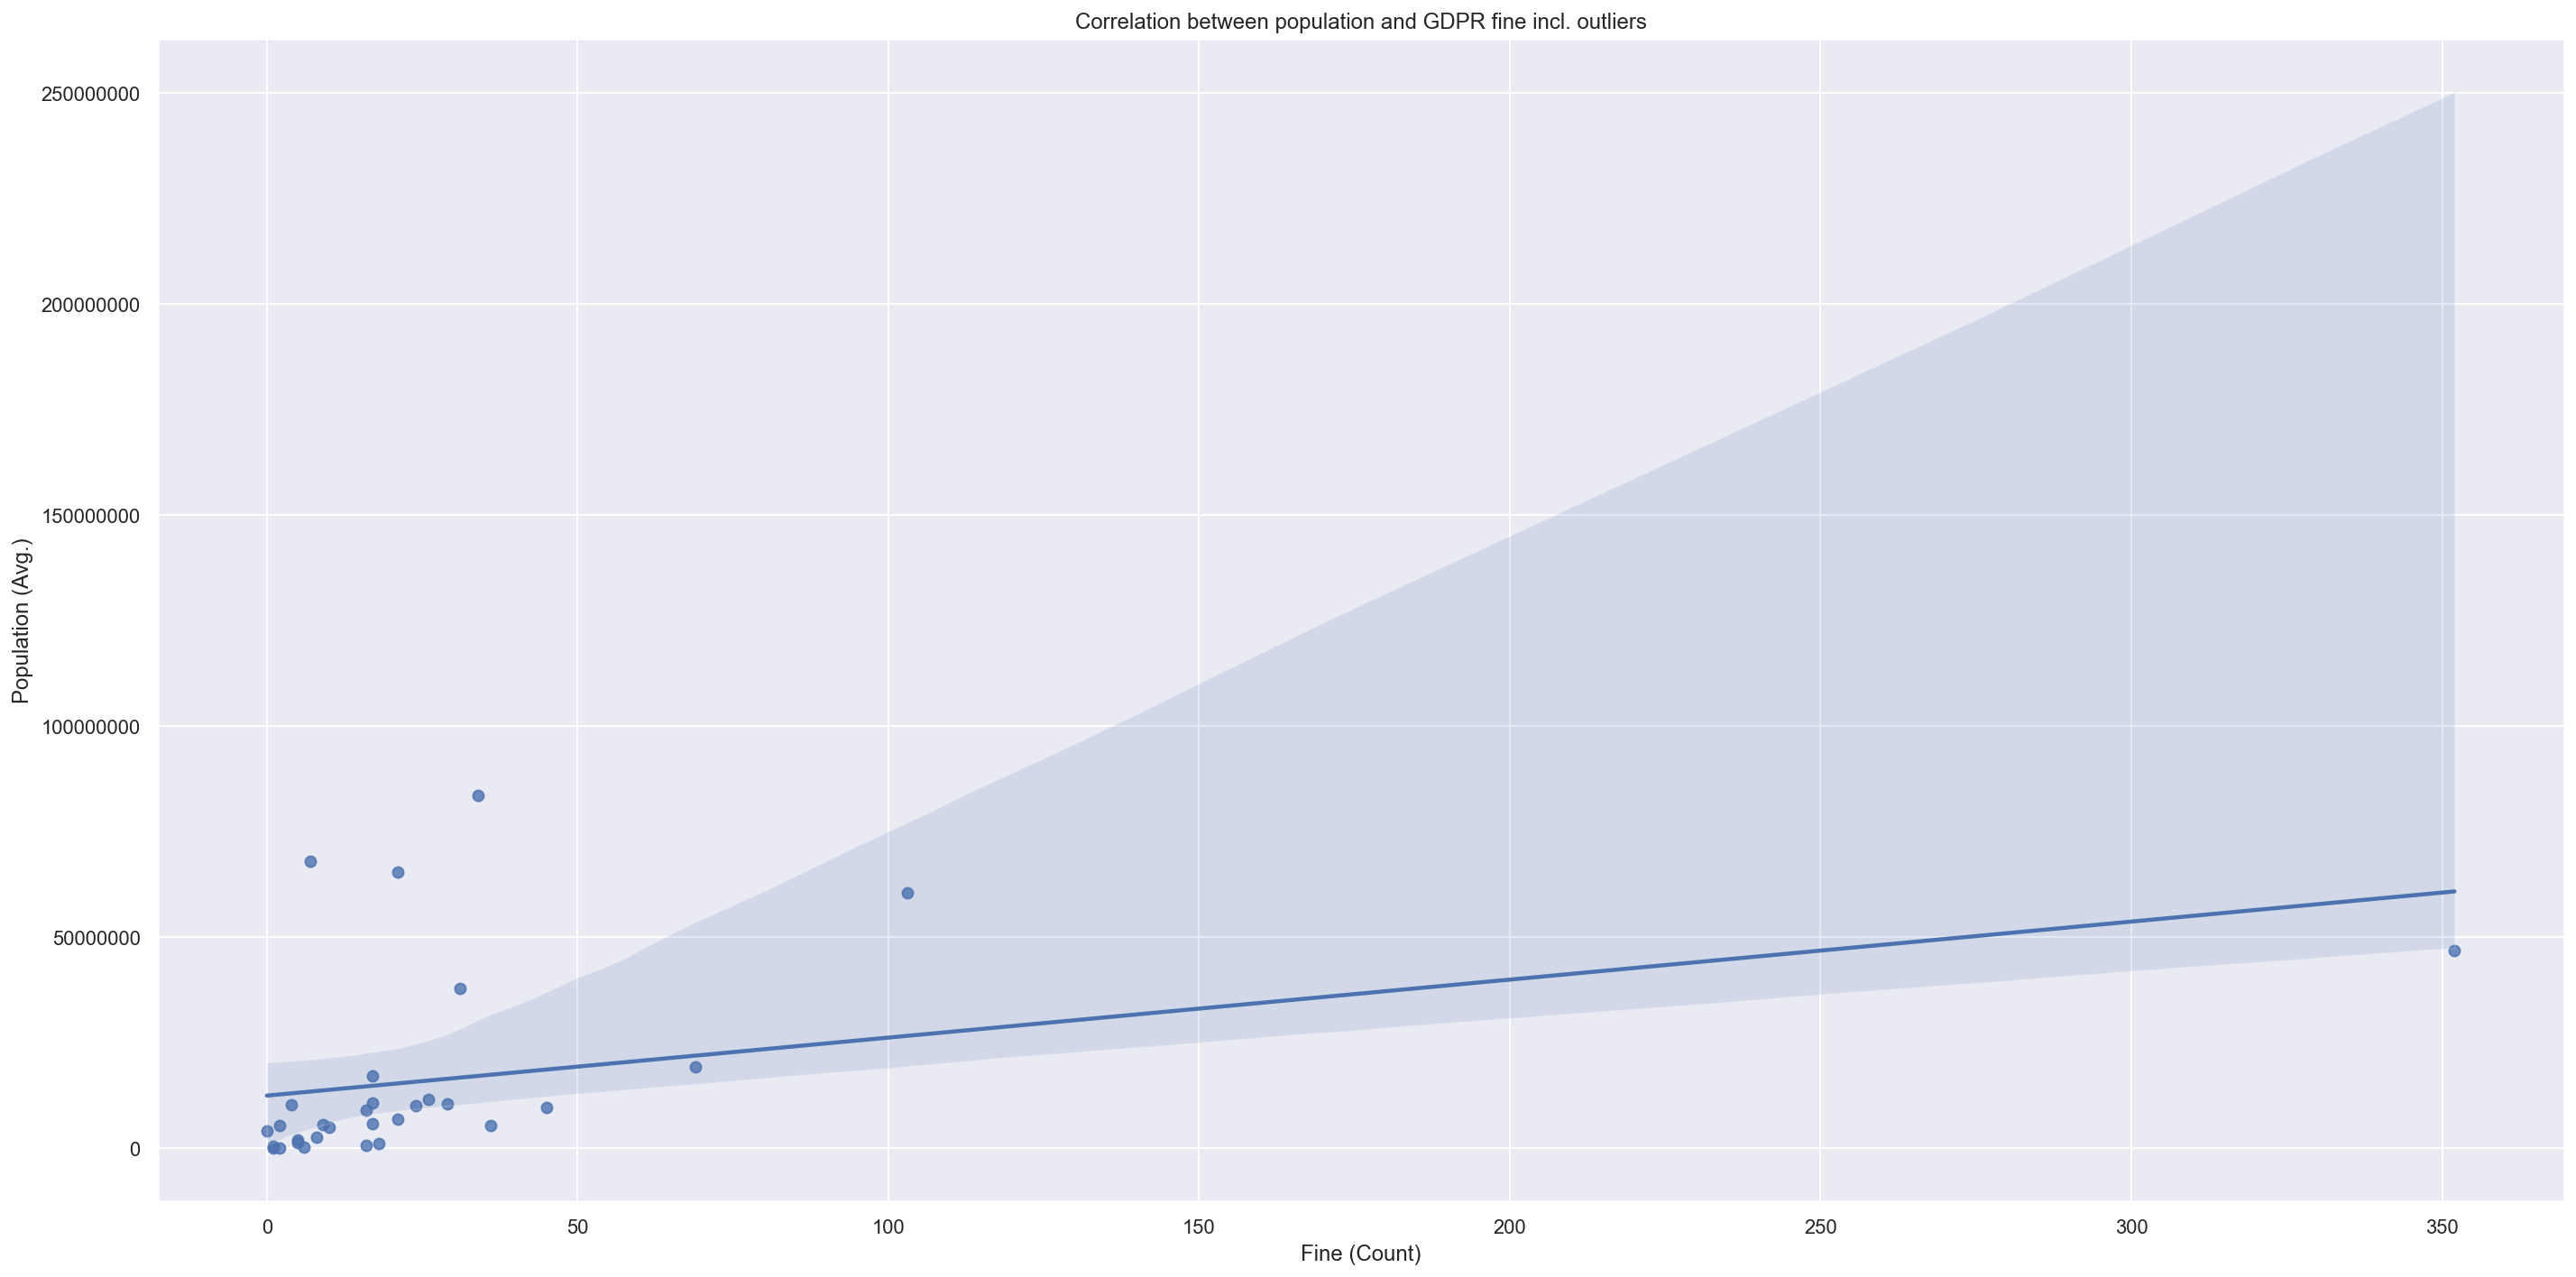

In [ ]:
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_ada_grouped_flatten, x="fine_count", y="population_mean");
chart.set(title='Correlation between population and GDPR fine incl. outliers', xlabel='Fine (Count)', ylabel="Population (Avg.)");

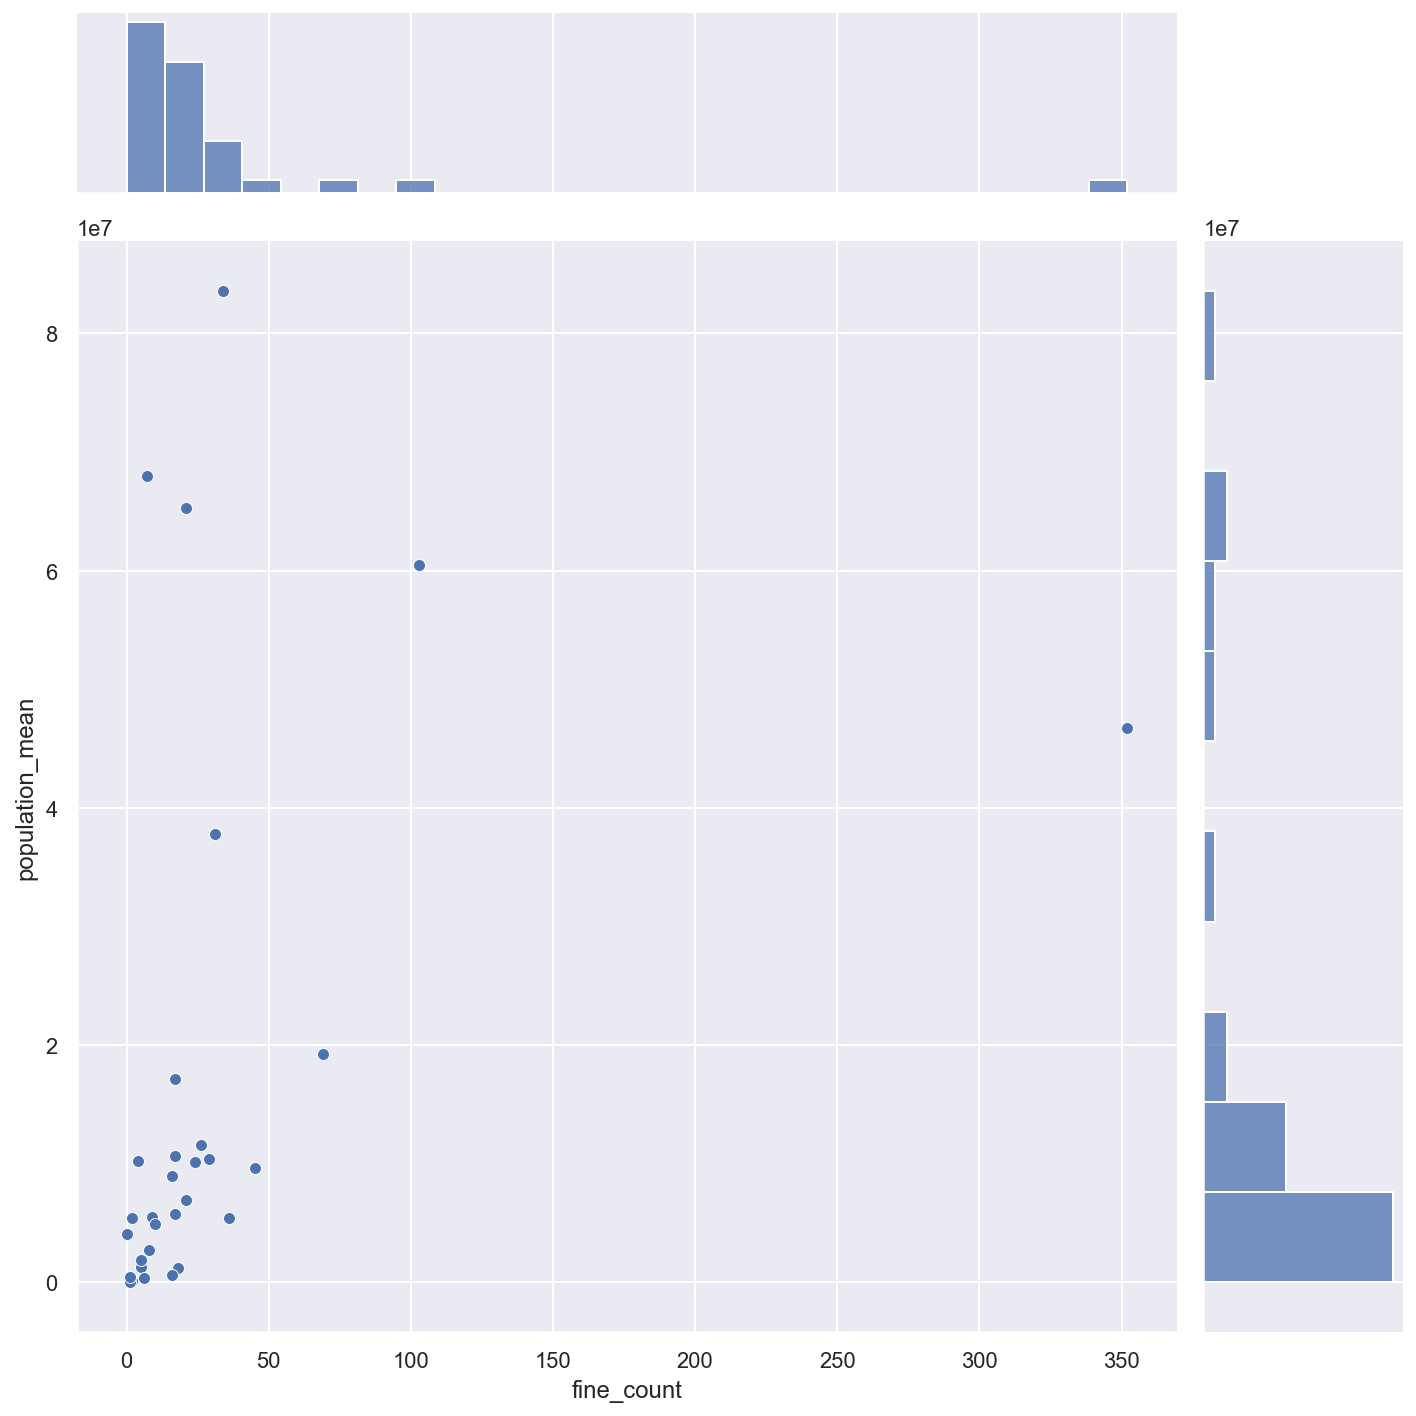

In [ ]:
chart = sns.jointplot(data=df_ada_grouped_flatten, x="fine_count", y="population_mean", height=10);

In [ ]:
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_ada_grouped_flatten.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

#### Identify and Address "Outliers"

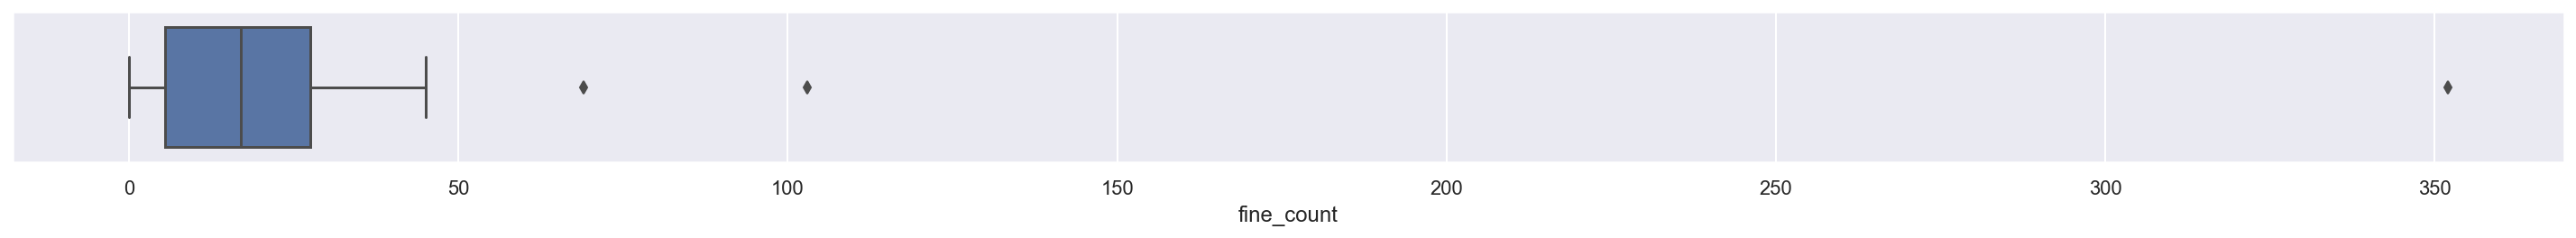

In [ ]:
# Identify and remove fine_count "outlier"
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten, x="fine_count");

In [ ]:
# Remove "outliers"
df_ada_grouped_flatten_adjusted = df_ada_grouped_flatten[df_ada_grouped_flatten['fine_count'] < 50]

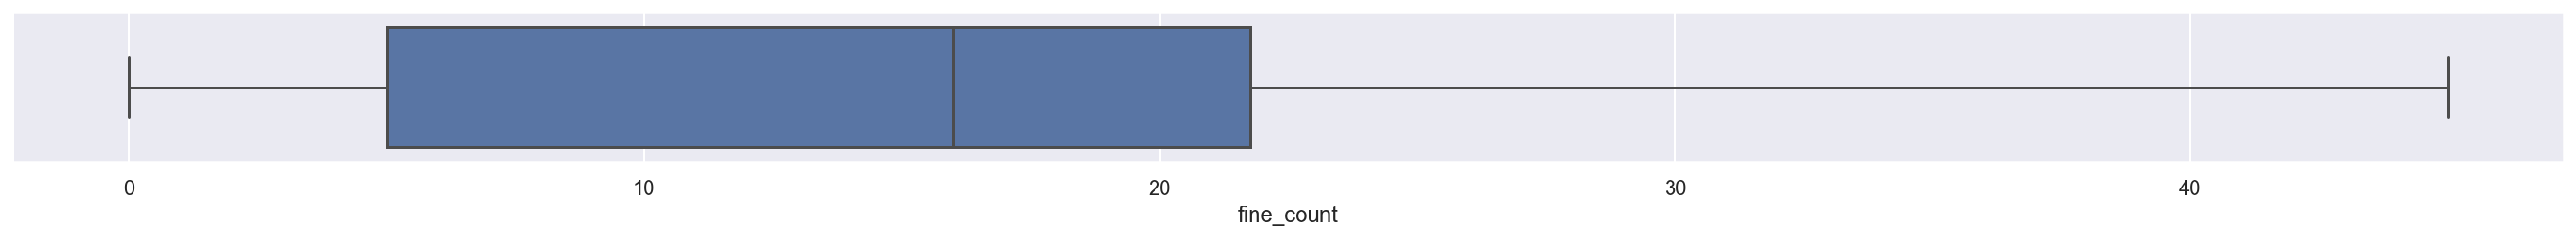

In [ ]:
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten_adjusted, x="fine_count");

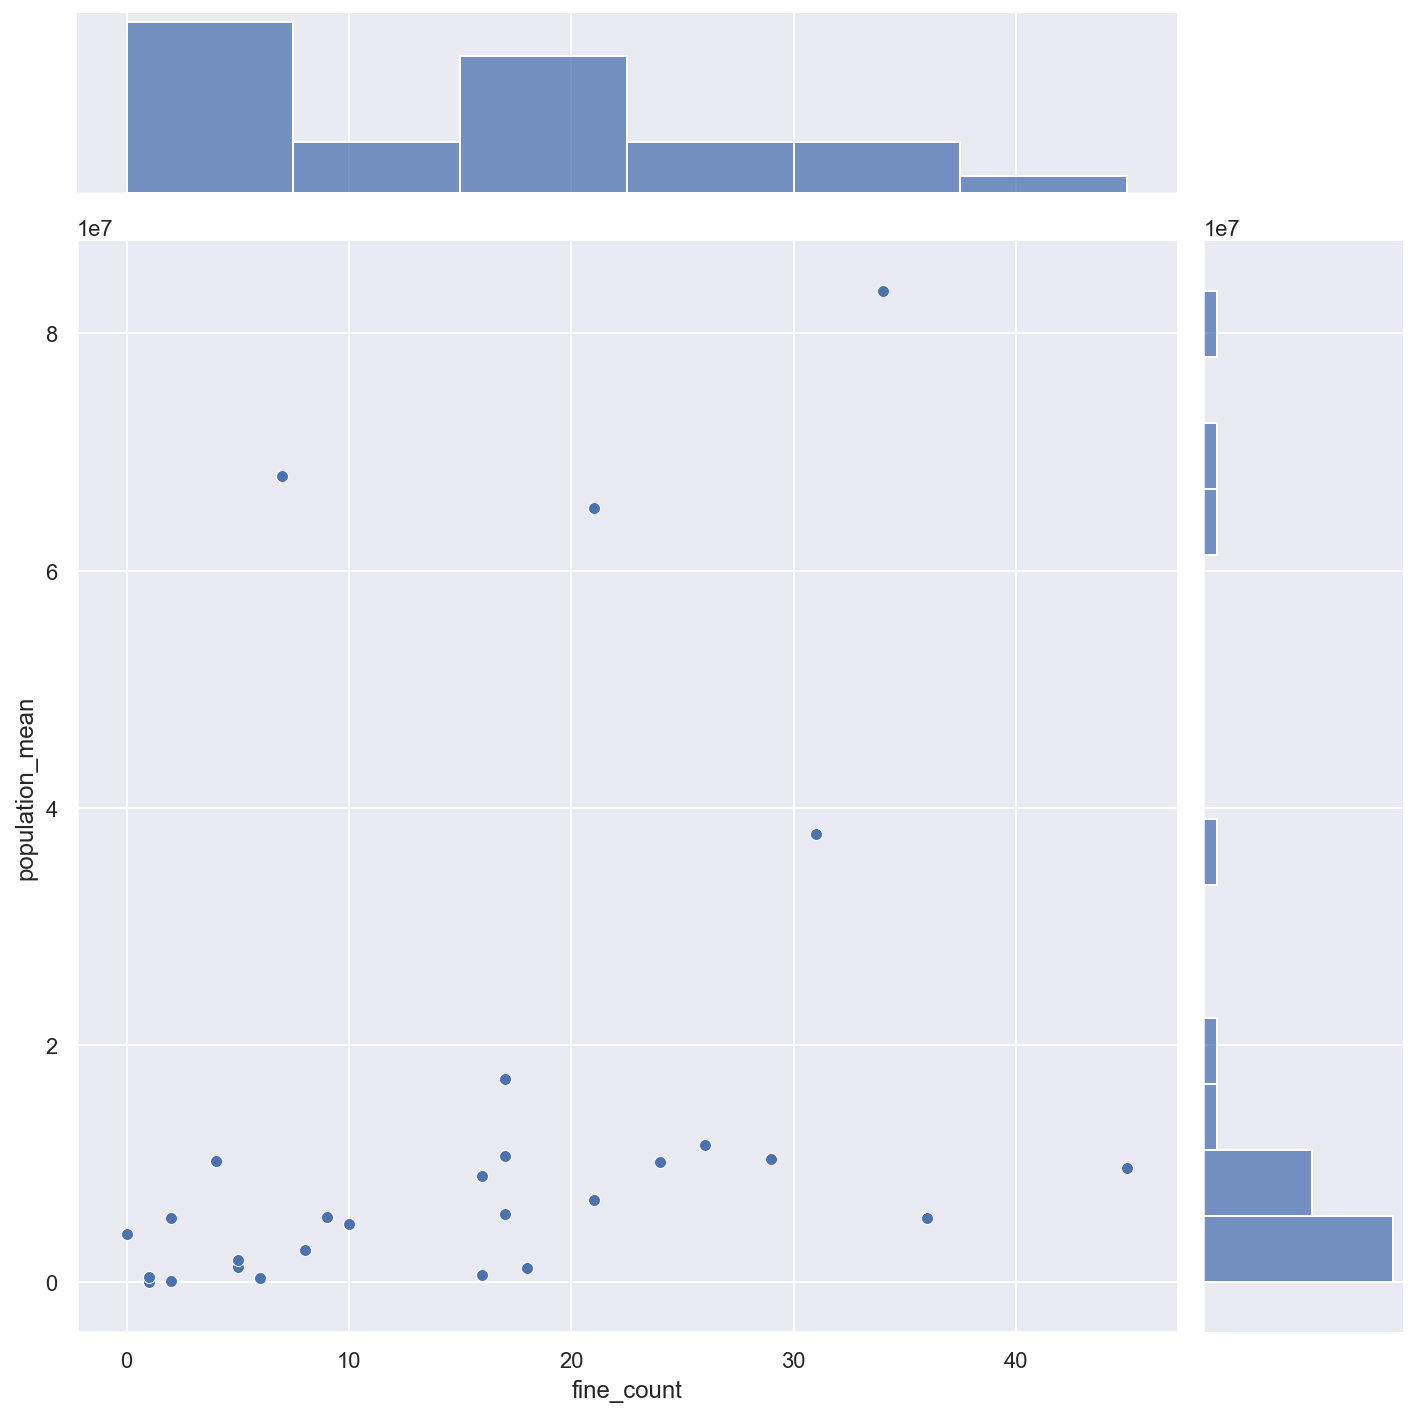

In [ ]:
chart = sns.jointplot(data=df_ada_grouped_flatten_adjusted, x="fine_count", y="population_mean", height=10);

#### Check Correlation - "Outliers" Removed

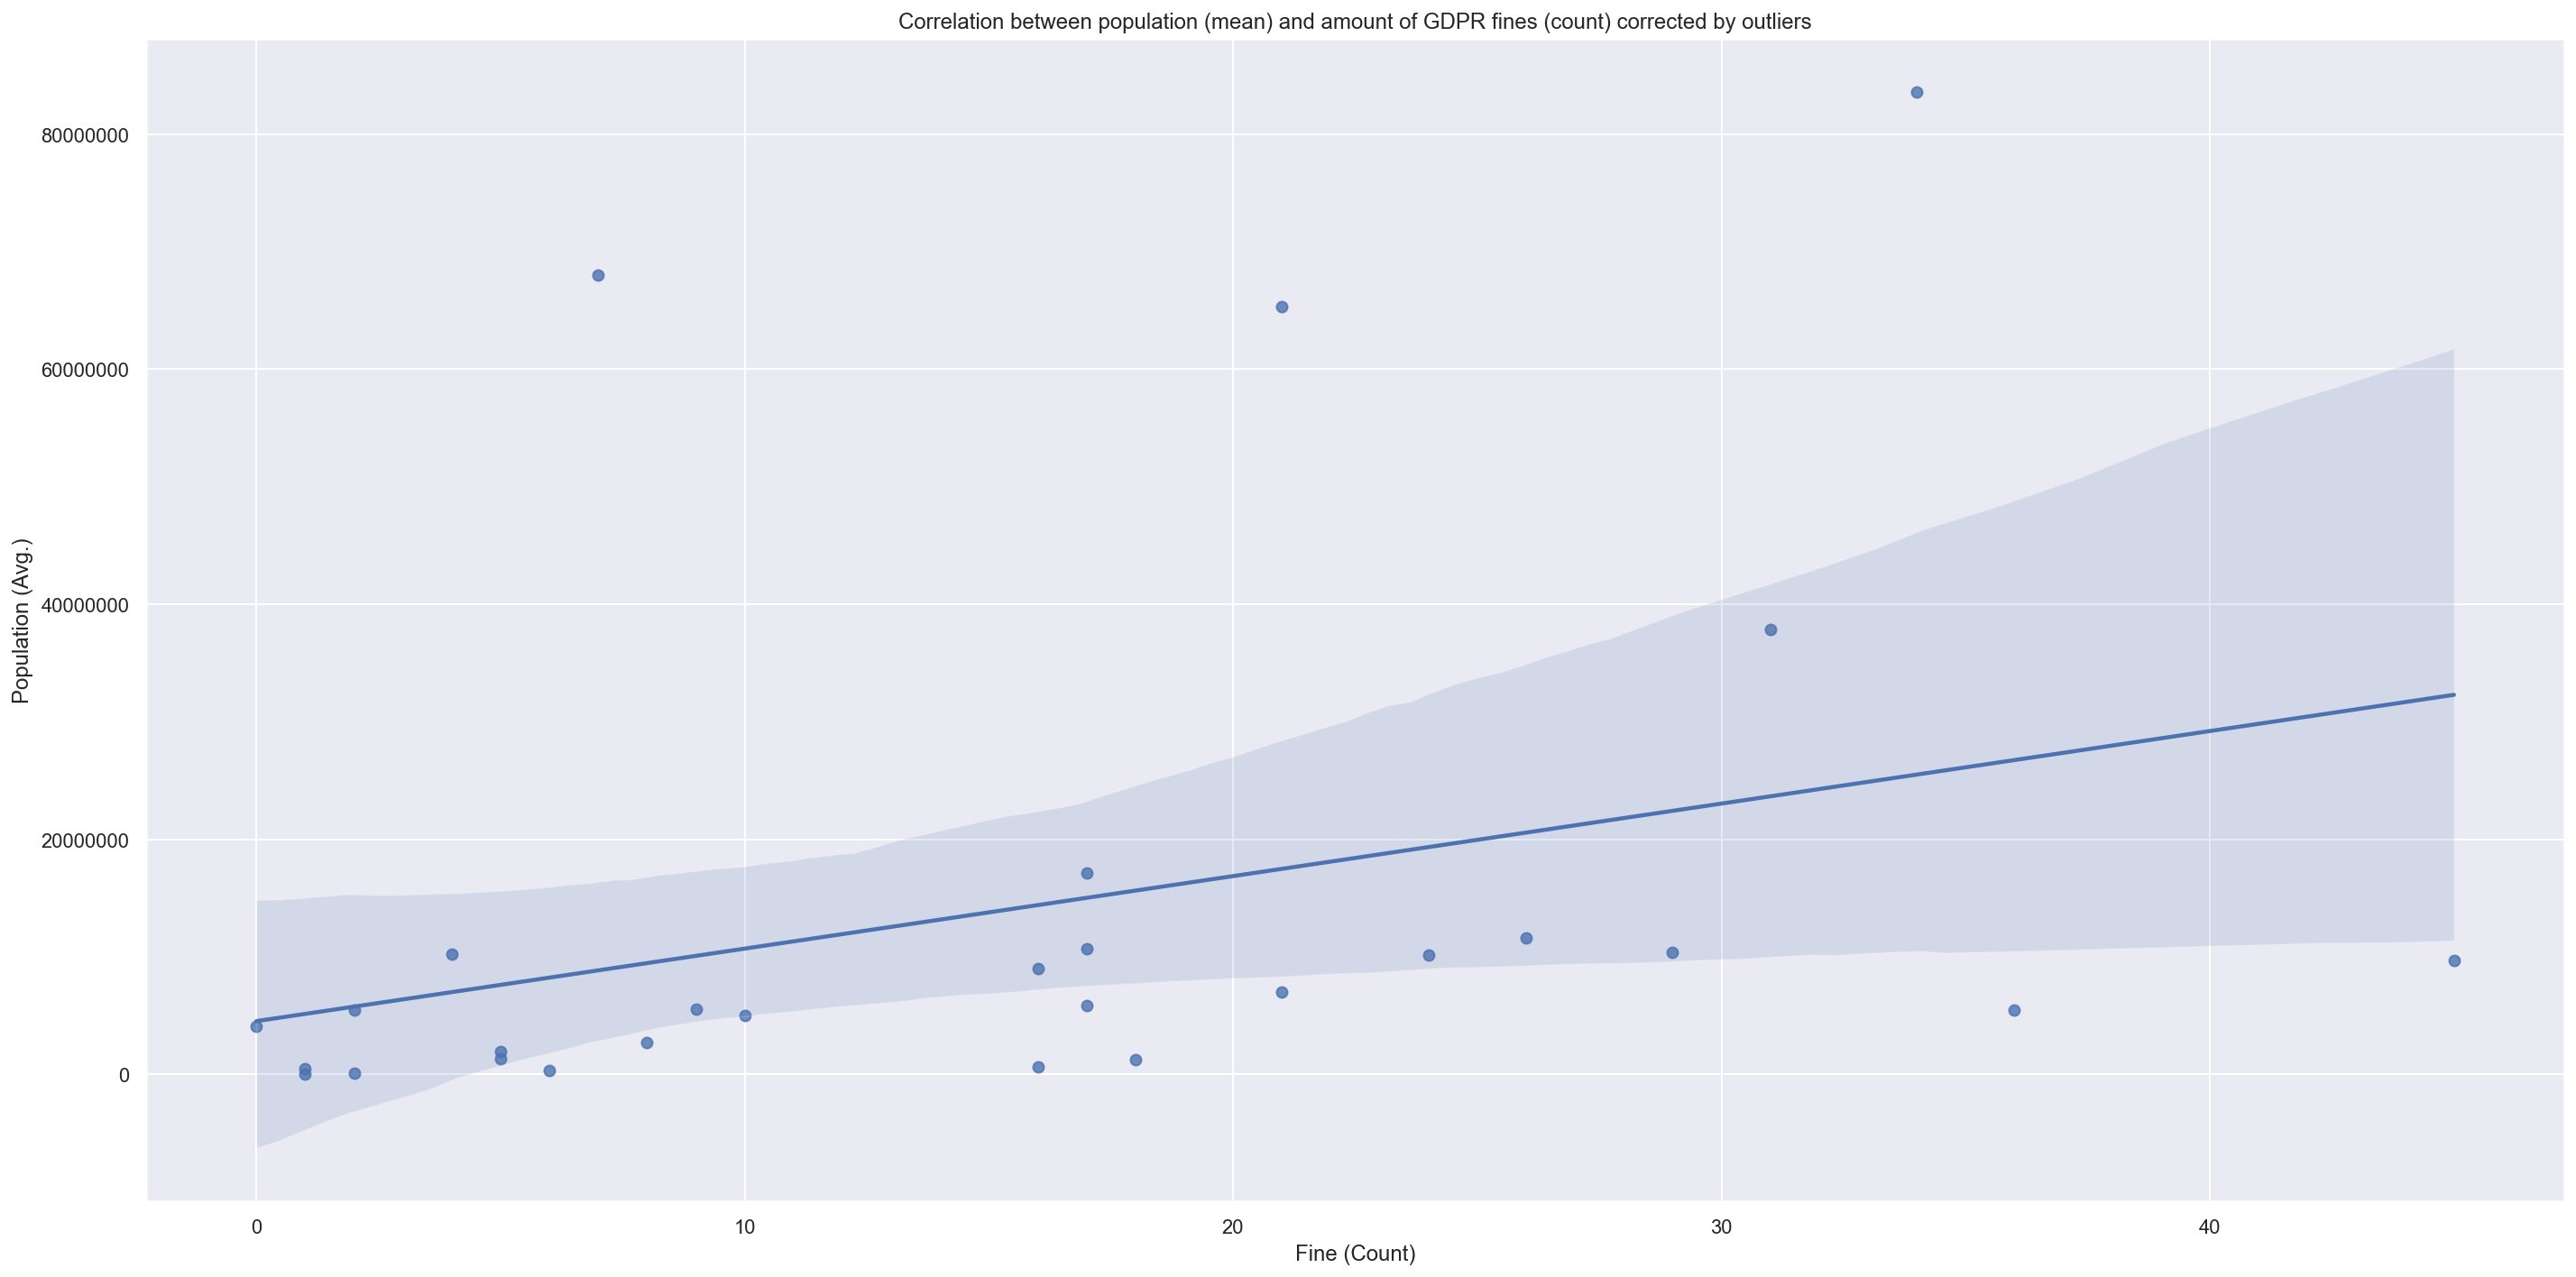

In [ ]:
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_ada_grouped_flatten_adjusted, x="fine_count", y="population_mean");
chart.set(title='Correlation between population (mean) and amount of GDPR fines (count) corrected by outliers', xlabel='Fine (Count)', ylabel="Population (Avg.)");

In [ ]:
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_ada_grouped_flatten_adjusted.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

#### **Conclusion**

...

## Additional Questions Identified During Analysis

### Focus on the Sector "Health Care"

# Watermark

In [ ]:
%watermark

Last updated: 2022-01-21T13:41:53.597353+01:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.30.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
CPU cores   : 16
Architecture: 64bit



In [ ]:
%watermark --iversions

numpy     : 1.21.4
seaborn   : 0.11.2
matplotlib: 3.5.0
pandas    : 1.3.5
sqlite3   : 2.6.0
altair    : 4.1.0
sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:15:42) [MSC v.1916 64 bit (AMD64)]



-----
